<a href="https://colab.research.google.com/github/RaphaelCarvalh/BootCampAVANTI_machine_learning_Ativ04-01/blob/main/Et01_analise_dataset_refatorado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Projeto Clothing Co-Parsing - Etapa 1 - Notebook: Análise do Dataset - TIV-04-ET-01


# Pipeline para Organização do Dataset (Clothing Co-Parsing)

# MÓDULO 0: Setup e Download do Dataset

In [3]:
# ==========================
# BLOCO 0 - INSTALAÇÃO E DOWNLOAD DO DATASET
# ==========================
!pip install opendatasets opencv-python-headless pandas pillow matplotlib imagehash seaborn --quiet

import os
import zipfile
import pandas as pd
from collections import Counter
import ast
import opendatasets as od # Import opendatasets

BASE_DIR = "/content/clothing-coparsing-dataset" # Update BASE_DIR
DATASET_NAME = "https://www.kaggle.com/datasets/balraj98/clothing-coparsing-dataset" # Update DATASET_NAME

# Check if dataset is already downloaded based on the opendatasets structure
if not os.path.exists(BASE_DIR):
    print("Dataset não encontrado. Fazendo download...")
    print("IMPORTANTE: Você precisará inserir suas credenciais do Kaggle")
    od.download(DATASET_NAME, data_dir="/content/") # Download to /content/

    print(f"Dataset baixado em: {BASE_DIR}")
else:
    print(f"Dataset já extraído em: {BASE_DIR}")

# Find the CSV file within the downloaded dataset structure
csv_files = [os.path.join(root, f)
             for root, _, files in os.walk(BASE_DIR) # Walk through the new BASE_DIR
             for f in files if f.endswith(".csv")]

if not csv_files:
    raise FileNotFoundError("Nenhum arquivo CSV encontrado no dataset.")

CSV_FILE = csv_files[0]
print(f"Usando CSV: {CSV_FILE}")

df_original = pd.read_csv(CSV_FILE)
print(f"CSV carregado: {len(df_original)} registros, {len(df_original.columns)} colunas")

# Keep the rest of the original code for processing the DataFrame
possible_class_cols = [col for col in df_original.columns if "class" in col.lower() or "label" in col.lower()]
if not possible_class_cols:
    raise ValueError("Não foi possível identificar a coluna de classes.")
CLASS_COL = possible_class_cols[0]

def parse_classes(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return [x]
    elif isinstance(x, list):
        return x
    else:
        return []

df_original[CLASS_COL] = df_original[CLASS_COL].apply(parse_classes)

all_classes = [cls for sublist in df_original[CLASS_COL] for cls in sublist]
top_5_classes = [cls for cls, _ in Counter(all_classes).most_common(5)]
print(f"Top 5 classes: {top_5_classes}")

def keep_top5(classes_list):
    return [cls for cls in classes_list if cls in top_5_classes]

df_filtered = df_original.copy()
df_filtered[CLASS_COL] = df_filtered[CLASS_COL].apply(keep_top5)
df_filtered['num_classes'] = df_filtered[CLASS_COL].apply(len)
df_filtered = df_filtered[df_filtered['num_classes'] > 0].reset_index(drop=True)
print(f"Dataset filtrado: {len(df_filtered)} imagens com top 5 classes")


Dataset já extraído em: /content/clothing-coparsing-dataset
Usando CSV: /content/clothing-coparsing-dataset/class_dict.csv
CSV carregado: 59 registros, 4 colunas
Top 5 classes: ['accessories', 'bag', 'belt', 'blazer', 'blouse']
Dataset filtrado: 5 imagens com top 5 classes


# MÓDULO 1: Criação do DataFrame completo

In [ ]:
# ------------------- 0.2 - Criação do DataFrame completo -------------------
import os
import pandas as pd
from PIL import Image
import hashlib
import numpy as np

# ------------------- Diretórios -------------------
# Update BASE_DIR and EXTRACT_DIR to match where the dataset was extracted
BASE_DIR = "/content/clothing-coparsing-dataset"
EXTRACT_DIR = BASE_DIR # The dataset is extracted directly into BASE_DIR
IMAGES_DIR = os.path.join(EXTRACT_DIR, "images")
LABELS_DIR = os.path.join(EXTRACT_DIR, "labels/pixel_level_labels_colored")
CLASS_CSV = os.path.join(EXTRACT_DIR, "class_dict.csv")

# ------------------- Listagem de arquivos -------------------
image_files = sorted([f for f in os.listdir(IMAGES_DIR) if f.lower().endswith((".jpg", ".png"))])
label_files = sorted([f for f in os.listdir(LABELS_DIR) if f.lower().endswith(".png")])

# ------------------- Criar DataFrame base -------------------
df = pd.DataFrame({
    "image_path_full": [os.path.join(IMAGES_DIR, f) for f in image_files],
    "image_path_relative": [f"images/{f}" for f in image_files],
    "label_path_full": [os.path.join(LABELS_DIR, f.replace(".jpg", ".png")) for f in image_files],
    "label_path_relative": [f"labels/pixel_level_labels_colored/{f.replace('.jpg', '.png')}" for f in image_files]
})

# ------------------- Verificação de existência -------------------
df["image_exists"] = df["image_path_full"].apply(os.path.exists)
df["label_exists"] = df["label_path_full"].apply(os.path.exists)

# ------------------- Checagem de imagens corrompidas e informações -------------------
image_info = []
for path in df["image_path_full"]:
    try:
        with Image.open(path) as img:
            img.verify()
        with Image.open(path) as img:  # reabre para infos
            width, height = img.size
            channels = len(img.getbands())
            img_format = img.format.lower()
        corrupted = False
    except:
        width = height = channels = 0
        img_format = None
        corrupted = True
    try:
        with open(path, "rb") as f:
            img_hash = hashlib.md5(f.read()).hexdigest()
    except:
        img_hash = None
    image_info.append((corrupted, img_hash, img_format, width, height, channels))

df[["corrupted", "image_hash", "image_format", "width", "height", "channels"]] = pd.DataFrame(image_info)

# ------------------- Duplicatas -------------------
df["is_duplicate"] = df.duplicated(subset=["image_hash"], keep=False)

# ------------------- Extração das classes das labels -------------------
class_df = pd.read_csv(CLASS_CSV)
rgb_to_class = {tuple(row[['r','g','b']]): row['class_name'] for idx, row in class_df.iterrows() if pd.notna(row['class_name'])}

def extract_classes(label_path):
    if not os.path.exists(label_path):
        return []
    try:
        with Image.open(label_path) as img:
            img = img.convert("RGB")
            colors = np.unique(np.array(img).reshape(-1, 3), axis=0)
            classes = [rgb_to_class[tuple(c)] for c in colors if tuple(c) in rgb_to_class]
        return classes
    except:
        return []

df["classes"] = df["label_path_full"].apply(extract_classes)
df["num_classes"] = df["classes"].apply(len)
df["image_id"] = range(1, len(df)+1)

# ------------------- Logs principais -------------------
print(f"Total imagens encontradas: {len(image_files)}")
print(f"Total labels encontradas: {len(label_files)}")
all_classes = [c for clist in df['classes'] for c in clist]
class_counts = pd.Series(all_classes).value_counts()
print(f"Total classes únicas: {len(class_counts)}")
top5_classes = class_counts.head(5)
print(f"Top 5 classes: {list(top5_classes.index)}")
print(f"DataFrame df_completo criado com {len(df)} registros")
print(f"Colunas: {list(df.columns)}")
print(f"Registros com labels válidos: {df['label_exists'].sum()} ({df['label_exists'].mean()*100:.1f}%)")
print(f"Registros corrompidos: {df['corrupted'].sum()}")
print(f"Imagens duplicadas: {df['is_duplicate'].sum()}")


# MÓDULO 2: DASHBOARD com apresentação

/tmp/ipython-input-4144676804.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,1].set_xticklabels(all_keys, rotation=90)


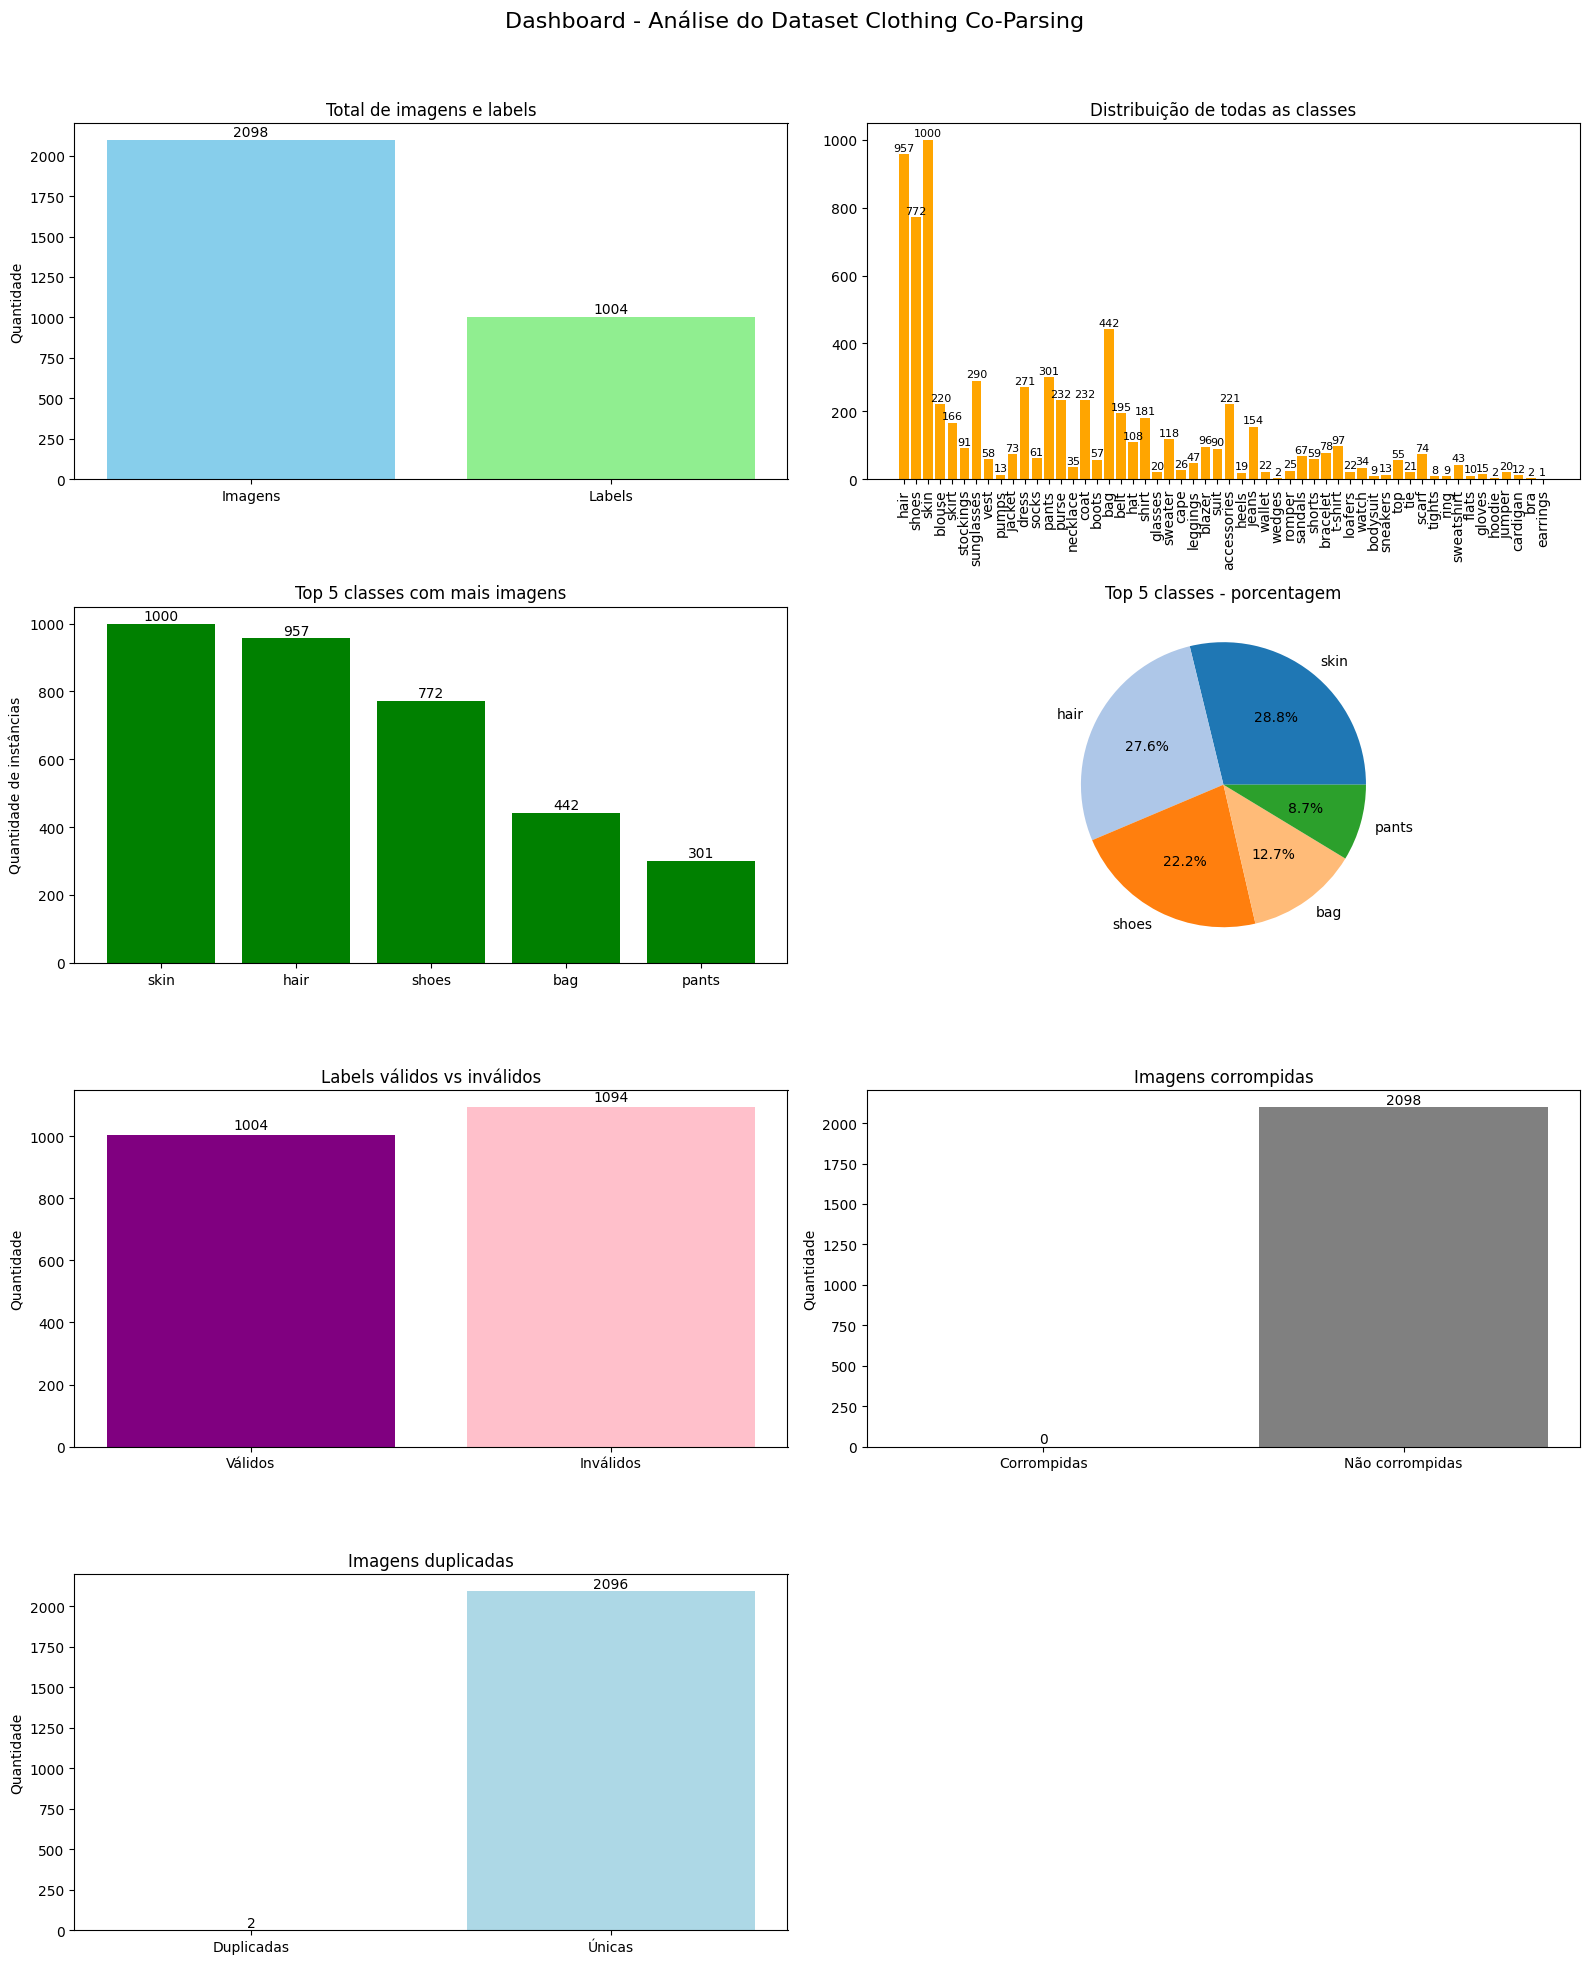

Total imagens: 2098
Labels válidos: 1004 (47.9%)
Imagens corrompidas: 0
Imagens duplicadas: 2
Top 5 classes: ('skin', 'hair', 'shoes', 'bag', 'pants')


In [73]:
# ------------------- 0.5 - Dashboard com duplicadas -------------------
import matplotlib.pyplot as plt
from collections import Counter

# Dados principais
df_dashboard = df.copy()
total_images = len(df_dashboard)
total_labels = df_dashboard['label_exists'].sum()
corrupted_count = df_dashboard['corrupted'].sum()
duplicate_count = df_dashboard['is_duplicate'].sum()

# Contagem de classes (apenas labels existentes)
all_classes = [c for clist in df_dashboard.loc[df_dashboard['label_exists'], 'classes'] for c in clist]
class_counts = Counter(all_classes)
top5_counts = dict(class_counts.most_common(5))

# ------------------- Criação do gráfico -------------------
fig, axes = plt.subplots(4, 2, figsize=(16, 20))  # linha extra para duplicadas
fig.suptitle("Dashboard - Análise do Dataset Clothing Co-Parsing", fontsize=16)

# Total imagens vs labels
axes[0,0].bar(["Imagens","Labels"], [total_images, total_labels], color=['skyblue','lightgreen'])
for i, v in enumerate([total_images, total_labels]):
    axes[0,0].text(i, v + total_images*0.01, f"{v}", ha='center', fontsize=10)
axes[0,0].set_title("Total de imagens e labels")
axes[0,0].set_ylabel("Quantidade")

# Todas as classes
all_keys, all_values = zip(*class_counts.items()) if class_counts else ([],[])
axes[0,1].bar(all_keys, all_values, color='orange')
for i, v in enumerate(all_values):
    axes[0,1].text(i, v + max(all_values)*0.01, f"{v}", ha='center', fontsize=8)
axes[0,1].set_title("Distribuição de todas as classes")
axes[0,1].set_xticklabels(all_keys, rotation=90)

# Top 5 classes (barras)
top_keys, top_values = zip(*top5_counts.items()) if top5_counts else ([],[])
axes[1,0].bar(top_keys, top_values, color='green')
for i, v in enumerate(top_values):
    axes[1,0].text(i, v + max(top_values)*0.01, f"{v}", ha='center', fontsize=10)
axes[1,0].set_title("Top 5 classes com mais imagens")
axes[1,0].set_ylabel("Quantidade de instâncias")

# Top 5 classes (pizza)
axes[1,1].pie(top_values, labels=top_keys, autopct="%1.1f%%", colors=plt.cm.tab20.colors)
axes[1,1].set_title("Top 5 classes - porcentagem")

# Labels válidos vs inválidos
axes[2,0].bar(["Válidos","Inválidos"], [total_labels, total_images-total_labels], color=['purple','pink'])
for i, v in enumerate([total_labels, total_images-total_labels]):
    axes[2,0].text(i, v + total_images*0.01, f"{v}", ha='center', fontsize=10)
axes[2,0].set_title("Labels válidos vs inválidos")
axes[2,0].set_ylabel("Quantidade")

# Imagens corrompidas vs não corrompidas
axes[2,1].bar(["Corrompidas","Não corrompidas"], [corrupted_count, total_images-corrupted_count], color=['red','gray'])
for i, v in enumerate([corrupted_count, total_images-corrupted_count]):
    axes[2,1].text(i, v + total_images*0.01, f"{v}", ha='center', fontsize=10)
axes[2,1].set_title("Imagens corrompidas")
axes[2,1].set_ylabel("Quantidade")

# Imagens duplicadas vs únicas
axes[3,0].bar(["Duplicadas","Únicas"], [duplicate_count, total_images-duplicate_count], color=['darkorange','lightblue'])
for i, v in enumerate([duplicate_count, total_images-duplicate_count]):
    axes[3,0].text(i, v + total_images*0.01, f"{v}", ha='center', fontsize=10)
axes[3,0].set_title("Imagens duplicadas")
axes[3,0].set_ylabel("Quantidade")

# eixo vazio
axes[3,1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# ------------------- Logs -------------------
# ------------------- Informações adicionais -------------------
print(f"Total imagens: {total_images}")
print(f"Labels válidos: {total_labels} ({total_labels/total_images*100:.1f}%)")
print(f"Imagens corrompidas: {corrupted_count}")
print(f"Imagens duplicadas: {duplicate_count}")
print(f"Top 5 classes: {top_keys}")


/tmp/ipython-input-315288718.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,1].set_xticklabels(all_keys, rotation=45, ha='right', fontsize=9)
/tmp/ipython-input-315288718.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,2].set_xticklabels(top_keys, rotation=45, ha='right', fontsize=10)
/tmp/ipython-input-315288718.py:155: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout(rect=[0, 0.02, 1, 0.96])
/tmp/ipython-input-315288718.py:155: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout(rect=[0, 0.02, 1, 0.96])
/tmp/ipython-input-315288718.py:155: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout(rect

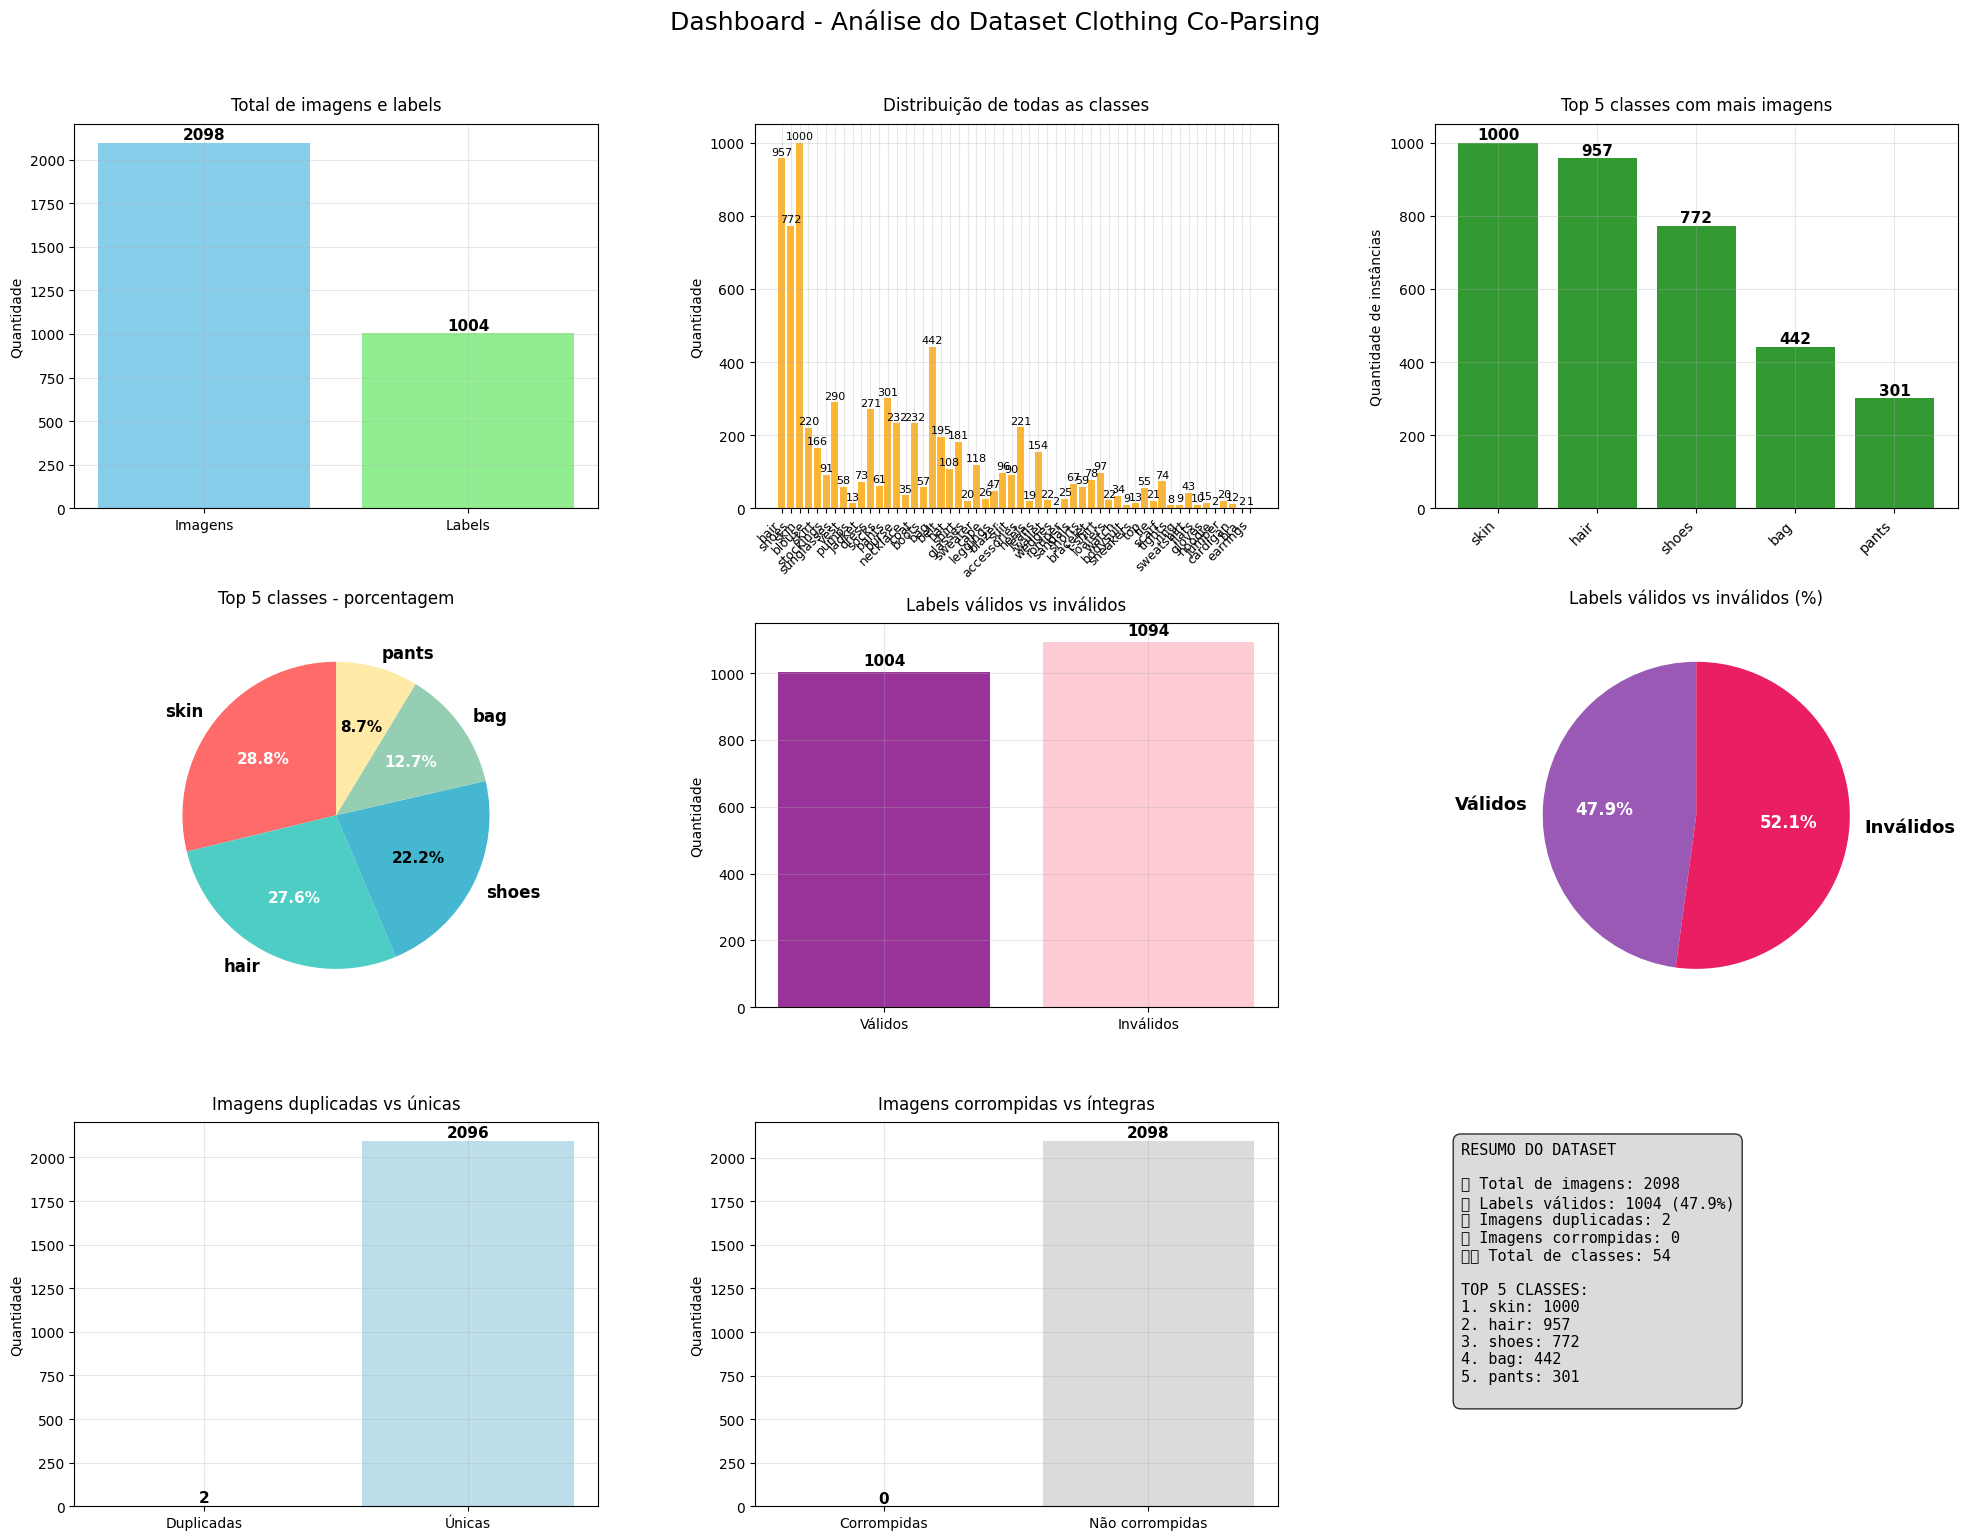

Total imagens: 2098
Labels válidos: 1004 (47.9%)
Imagens corrompidas: 0
Imagens duplicadas: 2
Top 5 classes: ['skin', 'hair', 'shoes', 'bag', 'pants']

🔄 2 imagem(ns) duplicada(s) encontrada(s):
  • images/0025.jpg | Classes: ['hair', 'shoes', 'dress', 'skin']
  • images/1707.jpg | Classes: []


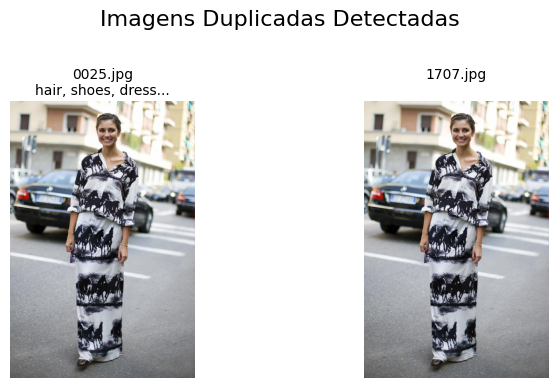

In [83]:
# ------------------- 0.5 - Dashboard com duplicadas (AJUSTADO) -------------------
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image

# Dados principais
df_dashboard = df.copy()
total_images = len(df_dashboard)
total_labels = df_dashboard['label_exists'].sum()
corrupted_count = df_dashboard['corrupted'].sum()
duplicate_count = df_dashboard['is_duplicate'].sum()

# Contagem de classes (apenas labels existentes)
all_classes = [c for clist in df_dashboard.loc[df_dashboard['label_exists'], 'classes'] for c in clist]
class_counts = Counter(all_classes)
top5_counts = dict(class_counts.most_common(5))

# ------------------- Criação do gráfico AJUSTADO -------------------
fig, axes = plt.subplots(3, 3, figsize=(20, 16))  # Mudou para 3x3 para melhor distribuição
fig.suptitle("Dashboard - Análise do Dataset Clothing Co-Parsing", fontsize=18, y=0.98)

# Total imagens vs labels
axes[0,0].bar(["Imagens","Labels"], [total_images, total_labels], color=['skyblue','lightgreen'])
for i, v in enumerate([total_images, total_labels]):
    axes[0,0].text(i, v + total_images*0.01, f"{v}", ha='center', fontsize=11, fontweight='bold')
axes[0,0].set_title("Total de imagens e labels", fontsize=12, pad=10)
axes[0,0].set_ylabel("Quantidade", fontsize=10)
axes[0,0].grid(True, alpha=0.3)

# Todas as classes
all_keys, all_values = zip(*class_counts.items()) if class_counts else ([],[])
bars = axes[0,1].bar(all_keys, all_values, color='orange', alpha=0.8)
if all_values:
    for i, v in enumerate(all_values):
        axes[0,1].text(i, v + max(all_values)*0.01, f"{v}", ha='center', fontsize=8)
axes[0,1].set_title("Distribuição de todas as classes", fontsize=12, pad=10)
axes[0,1].set_ylabel("Quantidade", fontsize=10)
axes[0,1].set_xticklabels(all_keys, rotation=45, ha='right', fontsize=9)
axes[0,1].grid(True, alpha=0.3)

# Top 5 classes (barras)
if top5_counts:
    top_keys, top_values = zip(*top5_counts.items())
    bars = axes[0,2].bar(top_keys, top_values, color='green', alpha=0.8)
    for i, v in enumerate(top_values):
        axes[0,2].text(i, v + max(top_values)*0.01, f"{v}", ha='center', fontsize=11, fontweight='bold')
    axes[0,2].set_title("Top 5 classes com mais imagens", fontsize=12, pad=10)
    axes[0,2].set_ylabel("Quantidade de instâncias", fontsize=10)
    axes[0,2].set_xticklabels(top_keys, rotation=45, ha='right', fontsize=10)
    axes[0,2].grid(True, alpha=0.3)
else:
    axes[0,2].text(0.5, 0.5, "Sem dados", ha='center', va='center')
    axes[0,2].set_title("Top 5 classes", fontsize=12)

# Top 5 classes (pizza)
if top5_counts:
    # Cores mais contrastantes para o texto
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
    wedges, texts, autotexts = axes[1,0].pie(top_values, labels=top_keys, autopct="%1.1f%%",
                                           colors=colors, startangle=90, textprops={'fontsize': 11})

    # Configurar texto das porcentagens com cor contrastante
    for i, autotext in enumerate(autotexts):
        # Usar cor escura para fatias claras e branca para fatias escuras
        if i in [2, 4]:  # Posições com cores mais claras
            autotext.set_color('black')
        else:
            autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(11)

    # Configurar texto das labels (nomes das classes)
    for text in texts:
        text.set_fontsize(12)
        text.set_fontweight('bold')
        text.set_color('black')

    axes[1,0].set_title("Top 5 classes - porcentagem", fontsize=12, pad=15)
else:
    axes[1,0].text(0.5, 0.5, "Sem dados", ha='center', va='center')
    axes[1,0].set_title("Top 5 classes - porcentagem", fontsize=12)

# Labels válidos vs inválidos (barras)
bars = axes[1,1].bar(["Válidos","Inválidos"], [total_labels, total_images-total_labels],
                     color=['purple','pink'], alpha=0.8)
for i, v in enumerate([total_labels, total_images-total_labels]):
    axes[1,1].text(i, v + total_images*0.01, f"{v}", ha='center', fontsize=11, fontweight='bold')
axes[1,1].set_title("Labels válidos vs inválidos", fontsize=12, pad=10)
axes[1,1].set_ylabel("Quantidade", fontsize=10)
axes[1,1].grid(True, alpha=0.3)

# Labels válidos vs inválidos (pizza)
colors_labels = ['#9B59B6', '#E91E63']  # Roxo e rosa mais vibrantes
wedges, texts, autotexts = axes[1,2].pie([total_labels, total_images-total_labels],
                                       labels=["Válidos","Inválidos"],
                                       autopct="%1.1f%%",
                                       colors=colors_labels,
                                       startangle=90,
                                       textprops={'fontsize': 12})

# Configurar texto das porcentagens
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

# Configurar texto das labels
for text in texts:
    text.set_fontsize(13)
    text.set_fontweight('bold')
    text.set_color('black')

axes[1,2].set_title("Labels válidos vs inválidos (%)", fontsize=12, pad=15)

# Imagens duplicadas vs únicas
bars = axes[2,0].bar(["Duplicadas","Únicas"], [duplicate_count, total_images-duplicate_count],
                     color=['darkorange','lightblue'], alpha=0.8)
for i, v in enumerate([duplicate_count, total_images-duplicate_count]):
    axes[2,0].text(i, v + total_images*0.01, f"{v}", ha='center', fontsize=11, fontweight='bold')
axes[2,0].set_title("Imagens duplicadas vs únicas", fontsize=12, pad=10)
axes[2,0].set_ylabel("Quantidade", fontsize=10)
axes[2,0].grid(True, alpha=0.3)

# Imagens corrompidas vs não corrompidas
bars = axes[2,1].bar(["Corrompidas","Não corrompidas"], [corrupted_count, total_images-corrupted_count],
                     color=['red','lightgray'], alpha=0.8)
for i, v in enumerate([corrupted_count, total_images-corrupted_count]):
    axes[2,1].text(i, v + total_images*0.01, f"{v}", ha='center', fontsize=11, fontweight='bold')
axes[2,1].set_title("Imagens corrompidas vs íntegras", fontsize=12, pad=10)
axes[2,1].set_ylabel("Quantidade", fontsize=10)
axes[2,1].grid(True, alpha=0.3)

# Resumo textual no último subplot
axes[2,2].axis('off')
summary_text = f"""RESUMO DO DATASET

📊 Total de imagens: {total_images}
✅ Labels válidos: {total_labels} ({total_labels/total_images*100:.1f}%)
🔄 Imagens duplicadas: {duplicate_count}
❌ Imagens corrompidas: {corrupted_count}
🏷️ Total de classes: {len(class_counts)}

TOP 5 CLASSES:
"""

if top5_counts:
    for i, (classe, count) in enumerate(top5_counts.items(), 1):
        summary_text += f"{i}. {classe}: {count}\n"

axes[2,2].text(0.05, 0.95, summary_text, transform=axes[2,2].transAxes, fontsize=11,
               verticalalignment='top', fontfamily='monospace',
               bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))

# Ajustar layout
plt.tight_layout(rect=[0, 0.02, 1, 0.96])
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

# ------------------- Logs -------------------
print(f"Total imagens: {total_images}")
print(f"Labels válidos: {total_labels} ({total_labels/total_images*100:.1f}%)")
print(f"Imagens corrompidas: {corrupted_count}")
print(f"Imagens duplicadas: {duplicate_count}")
if top5_counts:
    top_keys, top_values = zip(*top5_counts.items())
    print(f"Top 5 classes: {list(top_keys)}")

# ------------------- Mostrar duplicadas lado a lado (CORRIGIDO) -------------------
duplicates_df = df_dashboard[df_dashboard['is_duplicate']]
if not duplicates_df.empty:
    print(f"\n🔄 {len(duplicates_df)} imagem(ns) duplicada(s) encontrada(s):")

    # Calcular número de colunas (máximo 5 por linha)
    n_duplicates = len(duplicates_df)
    n_cols = min(5, n_duplicates)
    n_rows = (n_duplicates + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    fig.suptitle("Imagens Duplicadas Detectadas", fontsize=16, y=0.98)

    # Função para obter o axis correto independente da estrutura
    def get_axis(axes, row_idx, col_idx, n_rows, n_cols):
        if n_duplicates == 1:
            return axes
        elif n_rows == 1:
            return axes[col_idx]
        else:
            return axes[row_idx, col_idx]

    for i, (idx, row) in enumerate(duplicates_df.iterrows()):
        row_idx = i // n_cols
        col_idx = i % n_cols
        ax = get_axis(axes, row_idx, col_idx, n_rows, n_cols)

        print(f"  • {row['image_path_relative']} | Classes: {row['classes']}")

        try:
            img = Image.open(row['image_path_full'])
            ax.imshow(img)
            ax.axis('off')
            # Título mais compacto
            filename = row['image_path_relative'].split('/')[-1]
            classes_str = ', '.join(row['classes'][:3]) + ('...' if len(row['classes']) > 3 else '')
            ax.set_title(f"{filename}\n{classes_str}", fontsize=10, pad=5)
        except Exception as e:
            ax.text(0.5, 0.5, f"Erro ao carregar\n{str(e)}", ha='center', va='center',
                   fontsize=10, transform=ax.transAxes)
            ax.set_title(row['image_path_relative'].split('/')[-1], fontsize=10)
            ax.axis('off')

    # Esconder subplots vazios se necessário
    if n_duplicates < n_rows * n_cols:
        for i in range(n_duplicates, n_rows * n_cols):
            row_idx = i // n_cols
            col_idx = i % n_cols
            ax = get_axis(axes, row_idx, col_idx, n_rows, n_cols)
            ax.axis('off')

    plt.tight_layout(rect=[0, 0.02, 1, 0.96])
    plt.show()
else:
    print("\n✅ Nenhuma imagem duplicada encontrada.")

# MÓDULO 3: MAPEAMENTO DA TAREFA

In [75]:
import pandas as pd

# ------------------- Dados da cobertura -------------------
coverage_data = [
    ["Integridade - imagens existem",
     "df['image_exists'] = df['image_path_full'].apply(os.path.exists)",
     "Gráfico 'Total de imagens vs Labels', print(total_images)"],

    ["Integridade - labels existem",
     "df['label_exists'] = df['label_path_full'].apply(os.path.exists)",
     "Gráfico 'Total de imagens vs Labels', print(total_labels)"],

    ["Integridade - formatos consistentes",
     "img_format obtido no loop Image.open(path).format.lower()",
     "df['image_format'].value_counts()"],

    ["Consistência - valores ausentes",
     "Tratamento: width=0, height=0, channels=0 se falhar",
     "df.isna().sum(), df.describe()"],

    ["Consistência - valores inconsistentes",
     "Verificação width, height, channels no loop",
     "df.describe()"],

    ["Qualidade - imagens corrompidas",
     "corrupted obtido no try-except com Image.open().verify()",
     "Gráfico 'Imagens corrompidas vs não corrompidas', print(corrupted_count)"],

    ["Distribuição das classes - geral",
     "all_classes = [c for clist in df.loc[df['label_exists'], 'classes'] for c in clist]",
     "Gráfico barras 'Distribuição de todas as classes', Counter(all_classes)"],

    ["Distribuição das classes - Top 5",
     "top5_counts = dict(class_counts.most_common(5))",
     "Gráfico barras 'Top 5 classes', pizza 'Top 5 classes'"],

    ["Duplicatas - identificar",
     "df['is_duplicate'] = df.duplicated(subset=['image_hash'], keep=False)",
     "Print das imagens duplicadas com classes, gráfico 'Duplicadas vs Únicas'"],

    ["Duplicatas - labels duplicadas",
     "Mesma checagem de df['is_duplicate'] focando em imagens com label existente",
     "Print / inspeção direta dos duplicados"],

    ["Dashboard / Logs",
     "Todos os prints e gráficos do bloco 0.5",
     "Resumo completo: total imagens, labels válidos, corrompidas, duplicadas, distribuição de classes"]
]

df_coverage = pd.DataFrame(coverage_data, columns=["Requisito", "Código responsável", "Gráfico / Log"])

# ------------------- Estilização -------------------
def highlight_col(col):
    return ['background-color: #dff0d8' if v else '' for v in col]

styled_table = (
    df_coverage.style
    .set_properties(**{'text-align': 'left'})
    .set_table_styles([{'selector':'th','props':[('text-align','left')]}])
    .set_caption("✅ Cobertura do ATIV-04-ET-01 - Dataset Clothing Co-Parsing")
)

styled_table


# MÓDULO 4: INSPEÇÃO DO DATAFRAME

 INFORMAÇÕES GERAIS
Total de imagens: 2098
Labels válidos: 1004 (47.9%)
Labels inválidos: 1094 (52.1%)
Imagens corrompidas: 0
Imagens duplicadas: 2
Total de classes únicas: 54
Top 5 classes: [('skin', 1000), ('hair', 957), ('shoes', 772), ('bag', 442), ('pants', 301)]

 ESTATÍSTICAS DAS IMAGENS
        width       height  channels
count  2098.0  2098.000000    2098.0
mean    550.0   828.497140       3.0
std       0.0    10.728418       0.0
min     550.0   786.000000       3.0
25%     550.0   822.000000       3.0
50%     550.0   827.000000       3.0
75%     550.0   834.000000       3.0
max     550.0   877.000000       3.0



/tmp/ipython-input-2024669865.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(keys, rotation=90)


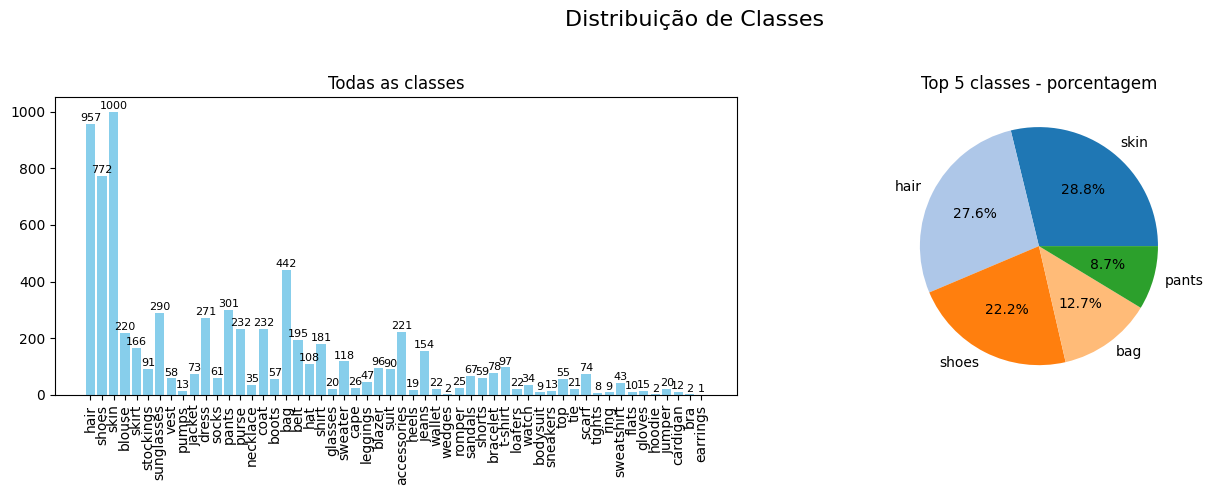

Imagens duplicadas encontradas:
- images/0025.jpg | Classes: ['hair', 'shoes', 'dress', 'skin']
- images/1707.jpg | Classes: []

Nenhuma imagem corrompida encontrada.

Imagens sem labels válidos:
- images/1005.jpg | Classes: []
- images/1006.jpg | Classes: []
- images/1007.jpg | Classes: []
- images/1008.jpg | Classes: []
- images/1009.jpg | Classes: []
- images/1010.jpg | Classes: []
- images/1011.jpg | Classes: []
- images/1012.jpg | Classes: []
- images/1013.jpg | Classes: []
- images/1014.jpg | Classes: []
- images/1015.jpg | Classes: []
- images/1016.jpg | Classes: []
- images/1017.jpg | Classes: []
- images/1018.jpg | Classes: []
- images/1019.jpg | Classes: []
- images/1020.jpg | Classes: []
- images/1021.jpg | Classes: []
- images/1022.jpg | Classes: []
- images/1023.jpg | Classes: []
- images/1024.jpg | Classes: []
- images/1025.jpg | Classes: []
- images/1026.jpg | Classes: []
- images/1027.jpg | Classes: []
- images/1028.jpg | Classes: []
- images/1029.jpg | Classes: []
- im

image_path_relative                         label_path_relative  \
726      images/0727.jpg  labels/pixel_level_labels_colored/0727.png   
90       images/0091.jpg  labels/pixel_level_labels_colored/0091.png   
1521     images/1522.jpg  labels/pixel_level_labels_colored/1522.png   
392      images/0393.jpg  labels/pixel_level_labels_colored/0393.png   
1070     images/1071.jpg  labels/pixel_level_labels_colored/1071.png   

                                                classes  num_classes  \
726   [pants, hair, flats, coat, bracelet, skin, bag...            8   
90                    [pants, hair, shoes, dress, skin]            5   
1521                                                 []            0   
392   [jumper, hair, shoes, dress, skin, bag, sungla...            7   
1070                                                 []            0   

      corrupted  is_duplicate  
726       False         False  
90        False         False  
1521      False         False  
392       False         False  
1070      False         False

In [76]:
# ------------------- 0.6 - Inspeção Detalhada do DataFrame -------------------
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import random

# Usar df existente (df_completo ou df_dashboard)
df_inspect = df.copy()

# ------------------- Informações gerais -------------------
total_images = len(df_inspect)
total_labels = df_inspect['label_exists'].sum()
corrupted_count = df_inspect['corrupted'].sum()
duplicate_count = df_inspect['is_duplicate'].sum()
unique_classes = set([c for clist in df_inspect['classes'] for c in clist])
labels_invalid = total_images - total_labels

print(" INFORMAÇÕES GERAIS")
print("==============================")
print(f"Total de imagens: {total_images}")
print(f"Labels válidos: {total_labels} ({total_labels/total_images*100:.1f}%)")
print(f"Labels inválidos: {labels_invalid} ({labels_invalid/total_images*100:.1f}%)")
print(f"Imagens corrompidas: {corrupted_count}")
print(f"Imagens duplicadas: {duplicate_count}")
print(f"Total de classes únicas: {len(unique_classes)}")
print(f"Top 5 classes: {Counter([c for clist in df_inspect['classes'] for c in clist]).most_common(5)}")
print()

# ------------------- 2Estatísticas das imagens -------------------
print(" ESTATÍSTICAS DAS IMAGENS")
print("==============================")
print(df_inspect[['width', 'height', 'channels']].describe())
print()

# ------------------- Distribuição de classes -------------------
all_classes = [c for clist in df_inspect['classes'] for c in clist]
class_counts = Counter(all_classes)
top5_counts = dict(class_counts.most_common(5))

fig, axes = plt.subplots(1,2, figsize=(14,5))
fig.suptitle("Distribuição de Classes", fontsize=16)

# Todas as classes
keys, values = zip(*class_counts.items()) if class_counts else ([],[])
axes[0].bar(keys, values, color='skyblue')
axes[0].set_title("Todas as classes")
axes[0].set_xticklabels(keys, rotation=90)
for i, v in enumerate(values):
    axes[0].text(i, v + max(values)*0.01, f"{v}", ha='center', fontsize=8)

# Top 5 classes (pizza)
top_keys, top_values = zip(*top5_counts.items()) if top5_counts else ([],[])
axes[1].pie(top_values, labels=top_keys, autopct="%1.1f%%", colors=plt.cm.tab20.colors)
axes[1].set_title("Top 5 classes - porcentagem")

plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

# ------------------- Imagens duplicadas -------------------
duplicates = df_inspect[df_inspect['is_duplicate']]
if not duplicates.empty:
    print("Imagens duplicadas encontradas:")
    for idx, row in duplicates.iterrows():
        print(f"- {row['image_path_relative']} | Classes: {row['classes']}")
else:
    print("Nenhuma imagem duplicada encontrada.")
print()

# ------------------- Imagens corrompidas -------------------
corrupted = df_inspect[df_inspect['corrupted']]
if not corrupted.empty:
    print("Imagens corrompidas:")
    for idx, row in corrupted.iterrows():
        print(f"- {row['image_path_relative']} | Classes: {row['classes']}")
else:
    print("Nenhuma imagem corrompida encontrada.")
print()

# ------------------- Labels inválidos -------------------
invalid_labels = df_inspect[~df_inspect['label_exists']]
if not invalid_labels.empty:
    print("Imagens sem labels válidos:")
    for idx, row in invalid_labels.iterrows():
        print(f"- {row['image_path_relative']} | Classes: {row['classes']}")
else:
    print("Todos os registros possuem label válido.")
print()

# ------------------- Amostras aleatórias -------------------
print("AMOSTRAS ALEATÓRIAS (5 registros)")
print("==============================")
sample = df_inspect.sample(min(5,len(df_inspect)))
display(sample[['image_path_relative','label_path_relative','classes','num_classes','corrupted','is_duplicate']])


# MÓDULO 5: VISUALIZAÇÕES EXEMPLO


 Visualização de exemplos
Visualizando 4 exemplos aleatórios do dataset:


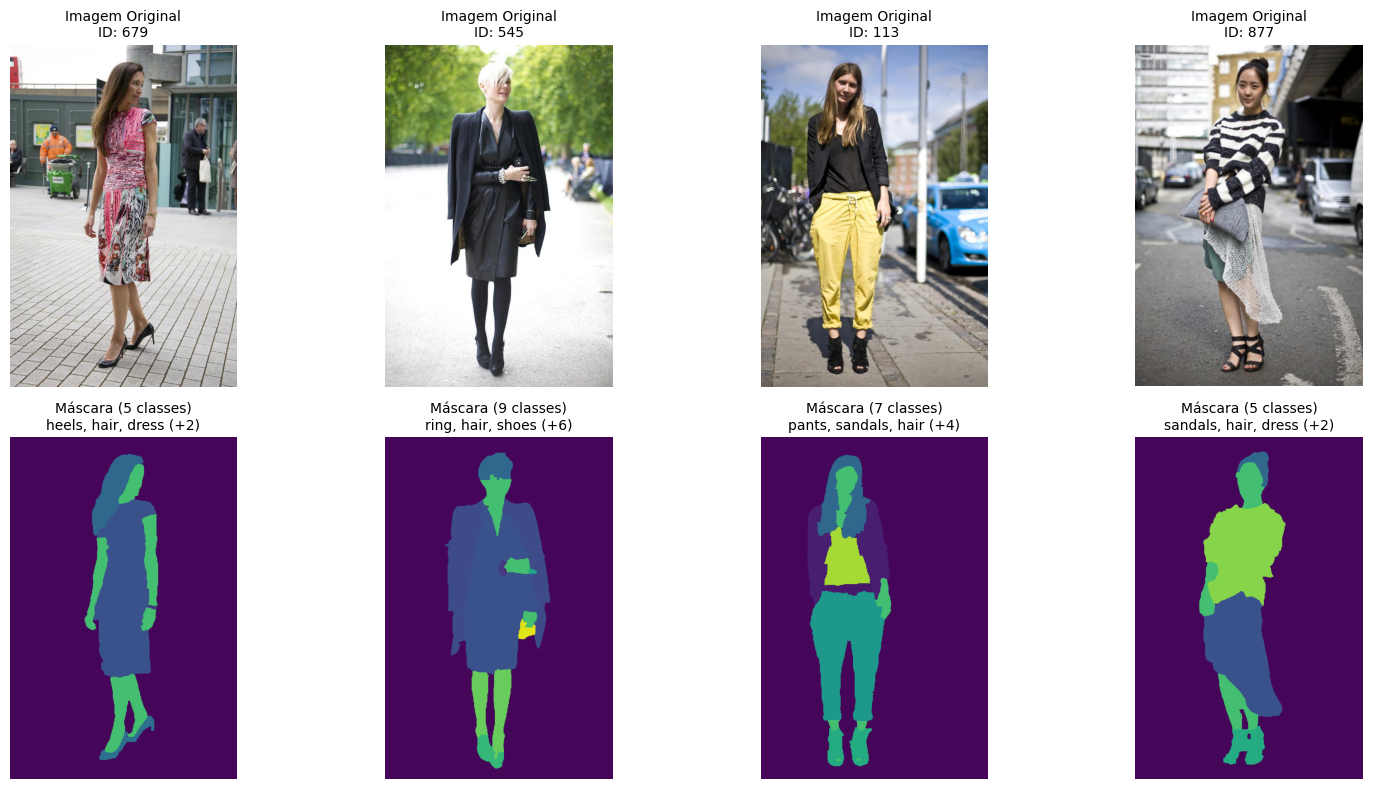

In [77]:
import matplotlib.pyplot as plt
import cv2
from PIL import Image

print("\n Visualização de exemplos")
print("=" * 40)

def visualizar_exemplos_dataset(df, num_exemplos=4):

    print(f"Visualizando {num_exemplos} exemplos aleatórios do dataset:")

    # Selecionar exemplos com pelo menos 2 classes
    df_com_classes = df[df['num_classes'] >= 2].copy()
    exemplos = df_com_classes.sample(n=min(num_exemplos, len(df_com_classes)))

    fig, axes = plt.subplots(2, num_exemplos, figsize=(4*num_exemplos, 8))

    for i, (_, row) in enumerate(exemplos.iterrows()):
        try:
            # Carregar imagem original
            img_original = cv2.imread(row['image_path_full'])
            img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

            # Carregar máscara
            mask = Image.open(row['label_path_full'])

            # Plotar imagem original
            axes[0, i].imshow(img_original)
            axes[0, i].set_title(f'Imagem Original\nID: {row["image_id"]}', fontsize=10)
            axes[0, i].axis('off')

            # Plotar máscara
            axes[1, i].imshow(mask)
            classes_texto = ', '.join(row['classes'][:3])  # Mostrar apenas 3 primeiras
            if len(row['classes']) > 3:
                classes_texto += f" (+{len(row['classes'])-3})"
            axes[1, i].set_title(f'Máscara ({len(row["classes"])} classes)\n{classes_texto}', fontsize=10)
            axes[1, i].axis('off')

        except Exception as e:
            axes[0, i].text(0.5, 0.5, 'Erro ao\ncarregar\nimagem', ha='center', va='center', transform=axes[0, i].transAxes)
            axes[1, i].text(0.5, 0.5, f'Erro: {str(e)[:20]}...', ha='center', va='center', transform=axes[1, i].transAxes)
            axes[0, i].axis('off')
            axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Executar visualização
visualizar_exemplos_dataset(df, num_exemplos=4)


# MÓDULO 6: EXPLORAÇÕES AVANÇADAS


MÓDULO 11: Explorações Avançadas do Dataset


/tmp/ipython-input-2825924365.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=contagem_subpasta.index, y=contagem_subpasta.values, ax=axes[0,0], palette=colors_list)
/tmp/ipython-input-2825924365.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,0].set_xticklabels(contagem_subpasta.index, rotation=45, ha='right')
/tmp/ipython-input-2825924365.py:89: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[2,1].boxplot([df['width'], df['height']], labels=['Largura','Altura'])


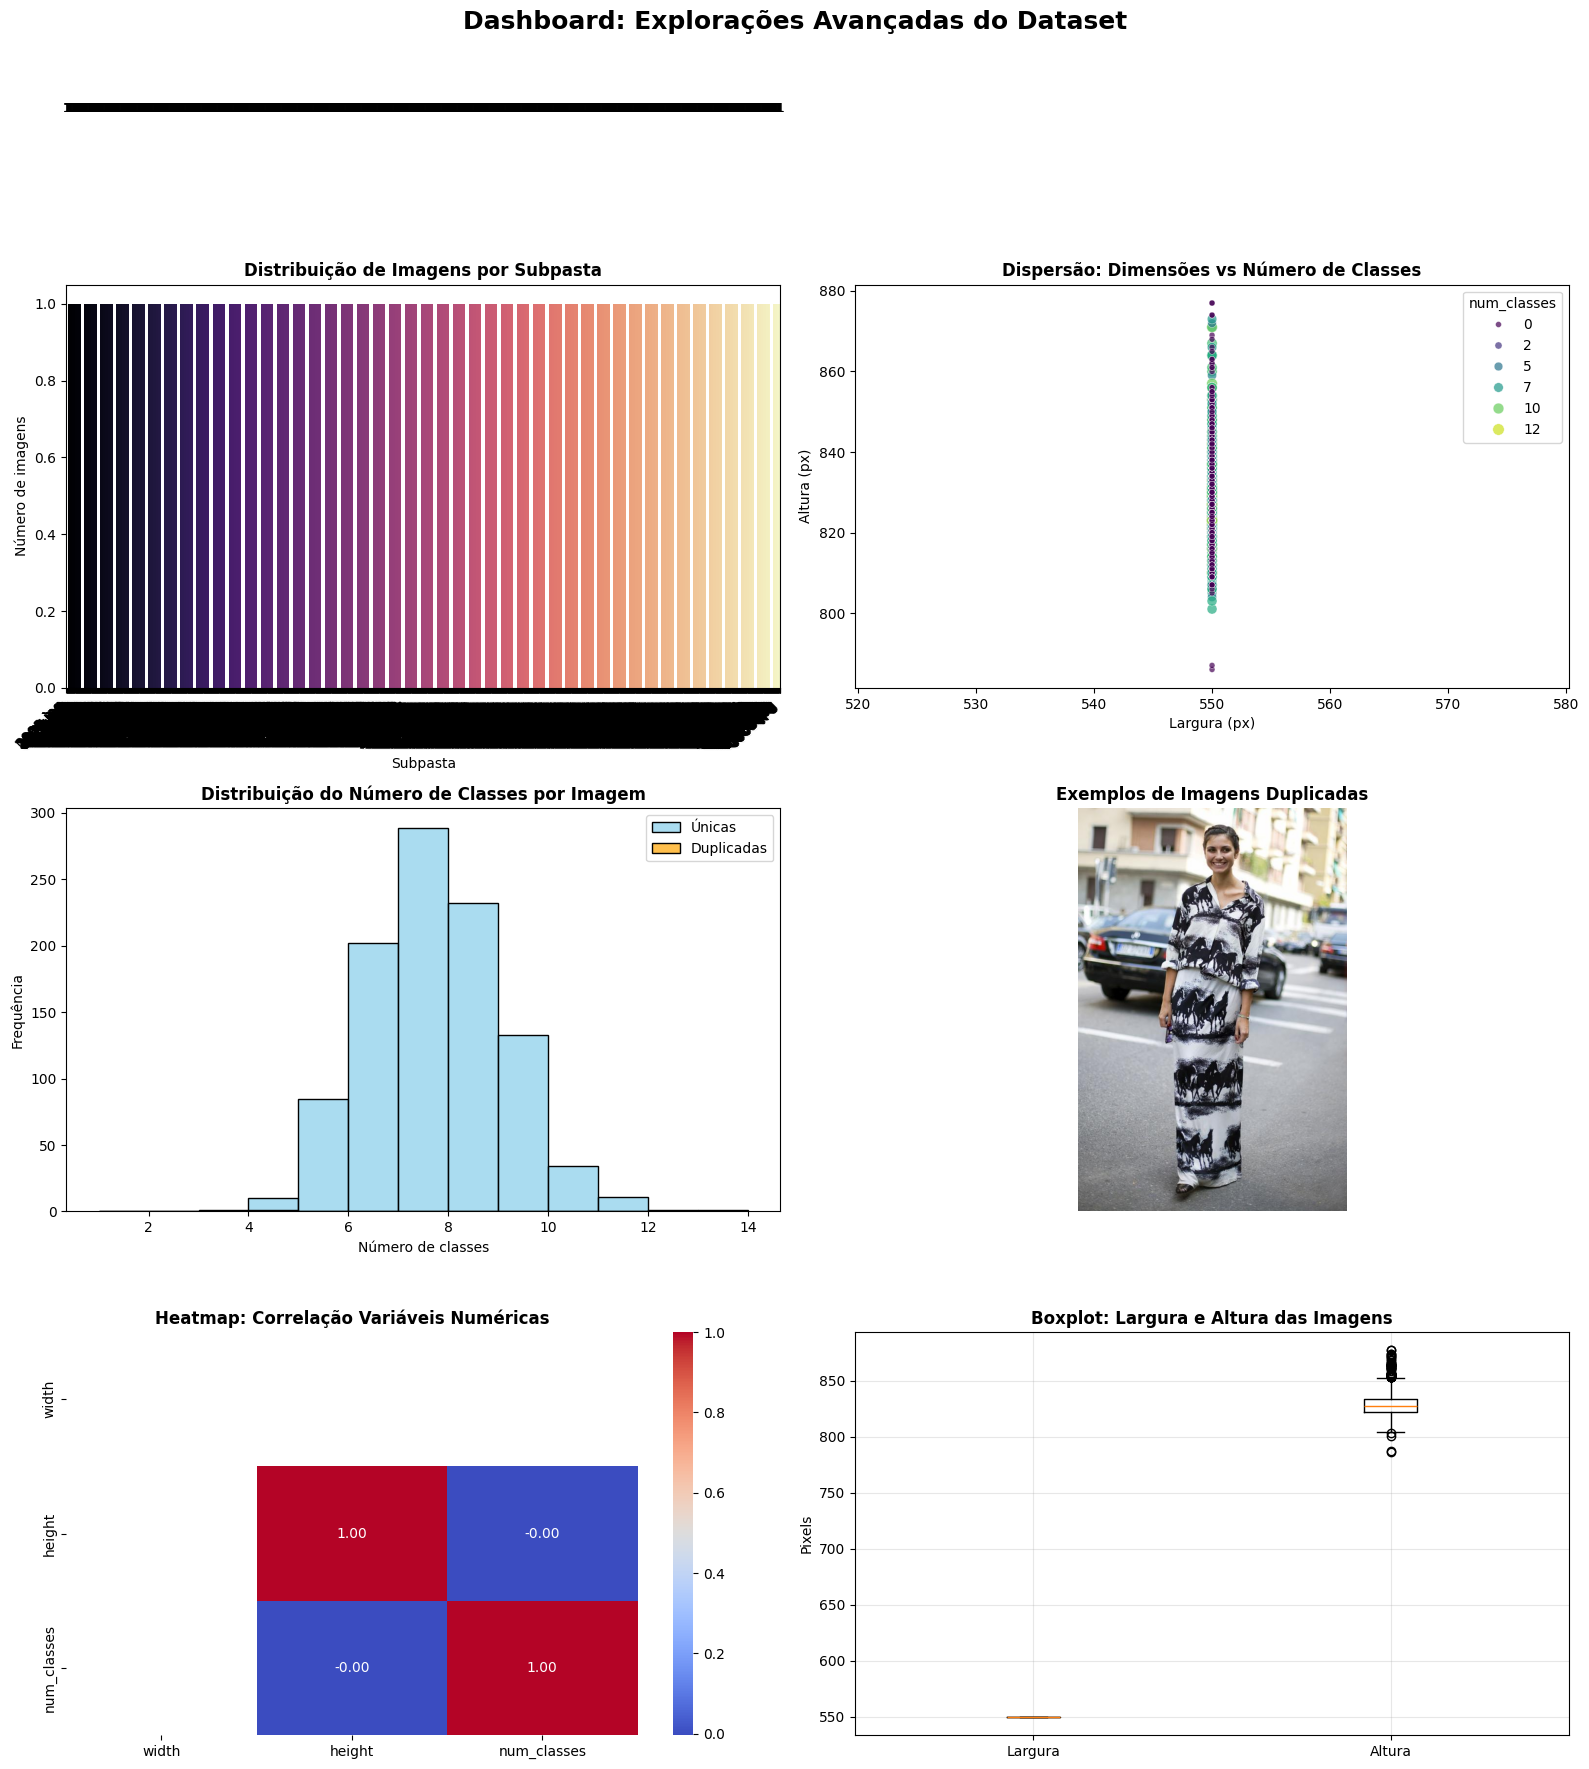

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import cv2

print("\nMÓDULO 11: Explorações Avançadas do Dataset")
print("="*60)

def exploracoes_avancadas_dashboard(num_exemplos=4):
    """Dashboard avançado do dataset"""

    df['num_classes'] = df['classes'].apply(len)

    # Preparar duplicadas
    if 'is_duplicate' in df.columns:
        df_duplicatas = df[df['is_duplicate']]
    else:
        df_duplicatas = pd.DataFrame(columns=df.columns)

    # Preparar subpastas
    if 'image_path_relative' in df.columns:
        subpastas = df['image_path_relative'].apply(lambda x: x.split('/')[1] if '/' in x else 'root')
        contagem_subpasta = subpastas.value_counts()
    else:
        contagem_subpasta = pd.Series(dtype=int)

    # ------------------- Criar figura geral -------------------
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    fig.suptitle("Dashboard: Explorações Avançadas do Dataset", fontsize=18, fontweight='bold')

    # ------------------- Gráfico 1: Distribuição por subpasta -------------------
    if len(contagem_subpasta) > 0:
        colors_list = plt.cm.magma(np.linspace(0, 1, len(contagem_subpasta))).tolist()  # converte para lista
        sns.barplot(x=contagem_subpasta.index, y=contagem_subpasta.values, ax=axes[0,0], palette=colors_list)
        axes[0,0].set_title("Distribuição de Imagens por Subpasta", fontsize=12, fontweight='bold')
        axes[0,0].set_ylabel("Número de imagens")
        axes[0,0].set_xlabel("Subpasta")
        axes[0,0].set_xticklabels(contagem_subpasta.index, rotation=45, ha='right')
        # Adicionar valores nas barras
        for i, v in enumerate(contagem_subpasta.values):
            axes[0,0].text(i, v + 0.5, str(v), ha='center', fontsize=9)

    # ------------------- Gráfico 2: Dispersão Classes vs Dimensões -------------------
    sns.scatterplot(x='width', y='height', size='num_classes', hue='num_classes',
                    data=df, palette='viridis', alpha=0.7, ax=axes[0,1])
    axes[0,1].set_title("Dispersão: Dimensões vs Número de Classes", fontsize=12, fontweight='bold')
    axes[0,1].set_xlabel("Largura (px)")
    axes[0,1].set_ylabel("Altura (px)")

    # ------------------- Gráfico 3: Histogramas de classes por imagem -------------------
    sns.histplot(df[~df['is_duplicate']]['num_classes'], color='skyblue', label='Únicas',
                 bins=range(1, df['num_classes'].max()+2), alpha=0.7, ax=axes[1,0])
    sns.histplot(df[df['is_duplicate']]['num_classes'], color='orange', label='Duplicadas',
                 bins=range(1, df['num_classes'].max()+2), alpha=0.7, ax=axes[1,0])
    axes[1,0].set_title("Distribuição do Número de Classes por Imagem", fontsize=12, fontweight='bold')
    axes[1,0].set_xlabel("Número de classes")
    axes[1,0].set_ylabel("Frequência")
    axes[1,0].legend()

    # ------------------- Gráfico 4: Miniaturas de duplicadas -------------------
    if len(df_duplicatas) > 0:
        exemplos_dup = df_duplicatas.sample(n=min(num_exemplos, len(df_duplicatas)))
        for i, (_, row) in enumerate(exemplos_dup.iterrows()):
            try:
                img = cv2.imread(row['image_path_full'])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                axes[1,1].imshow(img)
            except:
                axes[1,1].text(0.5, 0.5, 'Erro ao carregar imagem', ha='center', va='center')
        axes[1,1].axis('off')
        axes[1,1].set_title("Exemplos de Imagens Duplicadas", fontsize=12, fontweight='bold')
    else:
        axes[1,1].text(0.5,0.5,"Nenhuma duplicada encontrada", ha='center', va='center', fontsize=12)
        axes[1,1].axis('off')
        axes[1,1].set_title("Exemplos de Imagens Duplicadas", fontsize=12, fontweight='bold')

    # ------------------- Gráfico 5: Pairplot simplificado (scatter matrix) -------------------
    numeric_cols = ['width','height','num_classes']
    df_numeric = df[numeric_cols].dropna()
    if len(df_numeric) > 1:
        sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f", ax=axes[2,0])
        axes[2,0].set_title("Heatmap: Correlação Variáveis Numéricas", fontsize=12, fontweight='bold')
    else:
        axes[2,0].text(0.5,0.5,"Dados insuficientes para correlação", ha='center', va='center', fontsize=12)
        axes[2,0].axis('off')

    # ------------------- Gráfico 6: Boxplots de dimensões -------------------
    axes[2,1].boxplot([df['width'], df['height']], labels=['Largura','Altura'])
    axes[2,1].set_title("Boxplot: Largura e Altura das Imagens", fontsize=12, fontweight='bold')
    axes[2,1].set_ylabel("Pixels")
    axes[2,1].grid(True, alpha=0.3)

    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()

# Executar dashboard avançado
exploracoes_avancadas_dashboard(num_exemplos=4)


# MÓDULO 7: MAPEAMENTO NOVO DF VÁLIDO

In [2]:
import os
import pandas as pd

# Supondo que você já tenha lido o seu dataset original em df
# df = pd.read_csv("caminho/para/seu_csv.csv") ou já carregado de outra forma

df_inspect = df.copy()

def validar_df_atual(df, col_image='image_path_full', col_label='label_path_full'):
    """
    Adiciona colunas de verificação ao df atual:
    - image_exists
    - label_exists
    - both_exist
    """
    for col in [col_image, col_label]:
        if col not in df.columns:
            raise ValueError(f"Coluna '{col}' não encontrada no DataFrame.")

    df['image_exists_check'] = df[col_image].apply(lambda x: os.path.exists(x))
    df['label_exists_check'] = df[col_label].apply(lambda x: os.path.exists(x))
    df['both_exist_check'] = df['image_exists_check'] & df['label_exists_check']

    print(f"Total linhas: {len(df)}")
    print(f"Imagens válidas: {df['image_exists_check'].sum()}")
    print(f"Labels válidos: {df['label_exists_check'].sum()}")
    print(f"Linhas completamente válidas: {df['both_exist_check'].sum()}")

    return df

def filtrar_validas(df):
    """ Retorna apenas linhas com imagem e label existentes """
    return df[df['both_exist_check']].reset_index(drop=True)

# --- Criação do df_valido ---
df_validacao = validar_df_atual(df_inspect.copy())
df_valido = filtrar_validas(df_validacao)

print("Exemplo de linhas válidas:")
display(df_valido.head())


NameError: name 'df' is not defined

# MÓDULO 8: SEGMENTAÇÃO DE IMAGENS

🧪 EXECUTANDO TESTE DAS MÉTRICAS COM CLOTHING DATASET


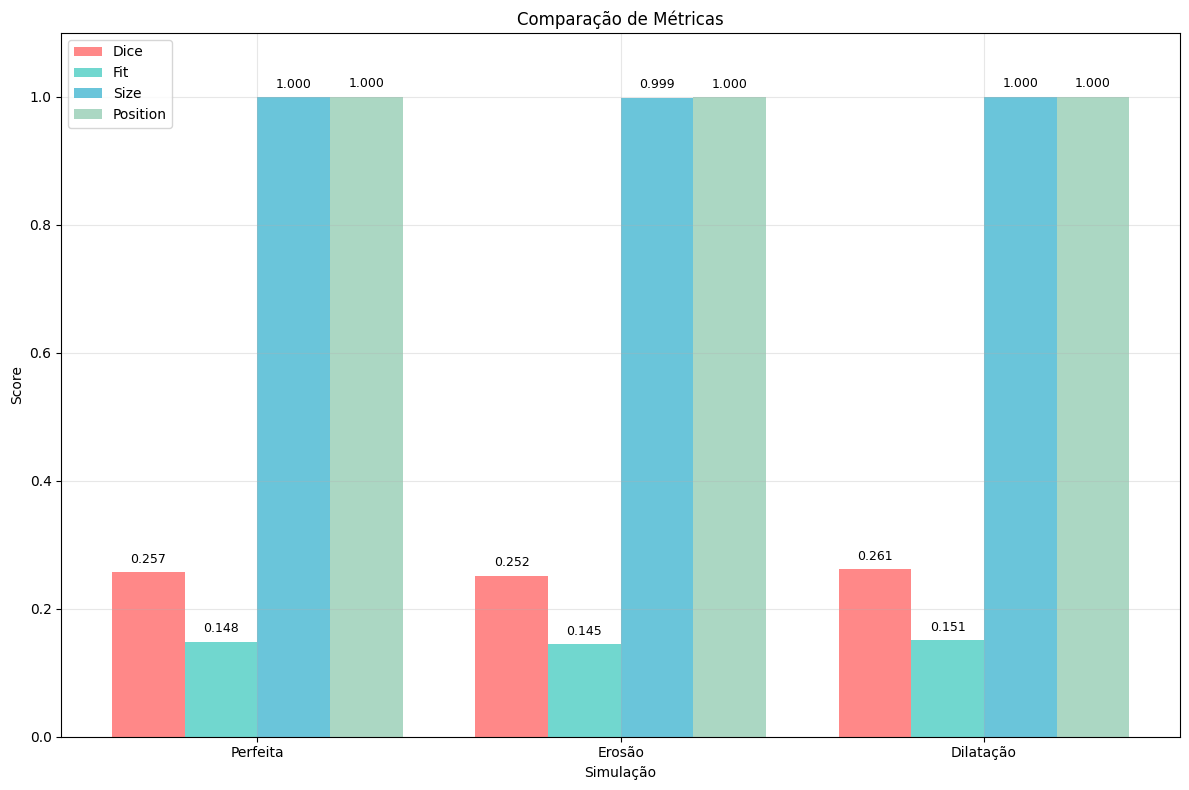

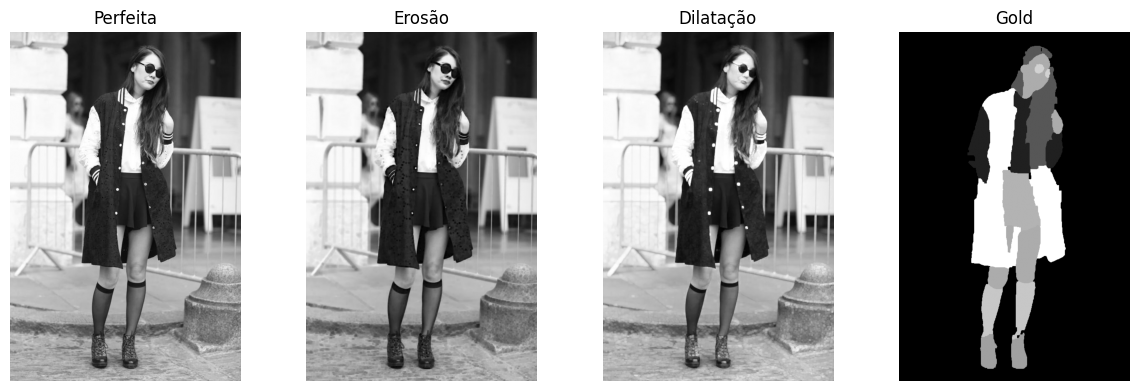

In [52]:

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# MÉTRICAS
# -------------------------
def compute_dice_similarity(array, arrayRef):
    imand = np.bitwise_and(array.astype("uint8"), arrayRef.astype("uint8"))
    sumand = 2 * np.sum(imand)
    sumor = np.sum(array) + np.sum(arrayRef)
    return sumand / float(sumor)

def compute_fit_adjust(array, arrayRef):
    imand = np.bitwise_and(array.astype("uint8"), arrayRef.astype("uint8"))
    imor = np.bitwise_or(array.astype("uint8"), arrayRef.astype("uint8"))
    return np.sum(imand) / float(np.sum(imor))

def compute_size_adjust(array, arrayRef):
    imArea1 = np.count_nonzero(arrayRef)
    imArea2 = np.count_nonzero(array)
    return 1 - abs(imArea1 - imArea2) / (imArea1 + imArea2)

def compute_position_adjust(arraySeg, arrayRef):
    indsSeg = np.where(arraySeg > 0)
    indsRef = np.where(arrayRef > 0)
    centroidRefY = indsRef[0].mean()
    centroidRefX = indsRef[1].mean()
    centroidSegY = indsSeg[0].mean()
    centroidSegX = indsSeg[1].mean()
    subCentroidY = abs(centroidSegY - centroidRefY) / arrayRef.shape[0]
    subCentroidX = abs(centroidSegX - centroidRefX) / arrayRef.shape[1]
    return 1 - (subCentroidY + subCentroidX) / 3

# -------------------------
# FUNÇÕES AUXILIARES
# -------------------------
def ler_imagem_gray(path):
    if os.path.exists(path):
        return cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return None

def aplicar_simulacao(img, tipo="original"):
    if tipo == "erosao":
        kernel = np.ones((3,3), np.uint8)
        return cv2.erode(img, kernel, iterations=1)
    elif tipo == "dilatacao":
        kernel = np.ones((3,3), np.uint8)
        return cv2.dilate(img, kernel, iterations=1)
    return img.copy()

def calcular_metricas_imagem(img, lbl):
    if img is None or lbl is None:
        return None
    return {
        "dice": compute_dice_similarity(img, lbl),
        "fit": compute_fit_adjust(img, lbl),
        "size": compute_size_adjust(img, lbl),
        "position": compute_position_adjust(img, lbl)
    }

# -------------------------
# PIPELINE
# -------------------------
def testar_metricas_clothing_dataset(df_valido, n=10):
    results = []
    seg_erosao = []
    seg_dilatacao = []
    gold_imgs = []

    df_teste = df_valido.head(n)

    for _, row in df_teste.iterrows():
        img = ler_imagem_gray(row['image_path_full'])
        lbl = ler_imagem_gray(row['label_path_full'])
        if img is None or lbl is None:
            continue
        results.append(calcular_metricas_imagem(img, lbl))
        gold_imgs.append(lbl)
        seg_erosao.append(aplicar_simulacao(img, "erosao"))
        seg_dilatacao.append(aplicar_simulacao(img, "dilatacao"))

    return {
        "results": results,
        "seg_erosao": seg_erosao,
        "seg_dilatacao": seg_dilatacao,
        "gold": gold_imgs
    }

def evaluate_segmentation_complete(seg_list, gold_list):
    metrics = {"dice": [], "fit": [], "size": [], "position": []}
    for img, lbl in zip(seg_list, gold_list):
        m = calcular_metricas_imagem(img, lbl)
        if m is not None:
            for k in metrics:
                metrics[k].append(m[k])
    return {f"mean_{k}": np.mean(v) if v else 0 for k, v in metrics.items()}

def plot_metrics_comparison(results_list, labels=["Perfeita","Erosão","Dilatação"]):
    metrics = ['mean_dice','mean_fit','mean_size','mean_position']
    metric_labels = ['Dice','Fit','Size','Position']
    x = range(len(results_list))
    width = 0.2
    colors = ['#FF6B6B','#4ECDC4','#45B7D1','#96CEB4']

    fig, ax = plt.subplots(figsize=(12,8))
    for i, metrica in enumerate(metrics):
        values = [res[metrica] if res else 0 for res in results_list]
        positions = [pos + width*i for pos in x]
        bars = ax.bar(positions, values, width, label=metric_labels[i], color=colors[i], alpha=0.8)
        for bar, value in zip(bars, values):
            ax.text(bar.get_x()+bar.get_width()/2., value+0.01,f'{value:.3f}', ha='center', va='bottom', fontsize=9)
    ax.set_xlabel('Simulação')
    ax.set_ylabel('Score')
    ax.set_title('Comparação de Métricas')
    ax.set_xticks([pos+width*1.5 for pos in x])
    ax.set_xticklabels(labels)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0,1.1)
    plt.tight_layout()
    plt.show()

def visualizar_comparacao_clothing(dados_teste, idx=0):
    plt.figure(figsize=(12,4))
    imgs = [
        ler_imagem_gray(df_valido.iloc[idx]['image_path_full']),
        dados_teste['seg_erosao'][idx],
        dados_teste['seg_dilatacao'][idx],
        dados_teste['gold'][idx]
    ]
    titles = ["Perfeita","Erosão","Dilatação","Gold"]
    for i, img in enumerate(imgs):
        plt.subplot(1,4,i+1)
        plt.imshow(img, cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# -------------------------
# EXECUÇÃO DIRETA
# -------------------------
print("🧪 EXECUTANDO TESTE DAS MÉTRICAS COM CLOTHING DATASET")
print("="*60)

# Testar com 10 imagens
dados_teste = testar_metricas_clothing_dataset(df_valido, n=10)

if dados_teste and dados_teste['results']:
    # Avaliar todas as simulações
    results_list = [
        evaluate_segmentation_complete(
            [ler_imagem_gray(df_valido.iloc[i]['image_path_full']) for i in range(10)],
            dados_teste['gold']
        ),
        evaluate_segmentation_complete(dados_teste['seg_erosao'], dados_teste['gold']),
        evaluate_segmentation_complete(dados_teste['seg_dilatacao'], dados_teste['gold'])
    ]
    plot_metrics_comparison(results_list)
    visualizar_comparacao_clothing(dados_teste, 0)
else:
    print("❌ Não foi possível executar o teste. Verifique df_valido e caminhos de imagem.")


# MÓDULO 9: SEGMENTAÇÃO DE IMAGENS aMOSTRAS

EXECUTANDO TESTE DAS MÉTRICAS COM CLOTHING DATASET


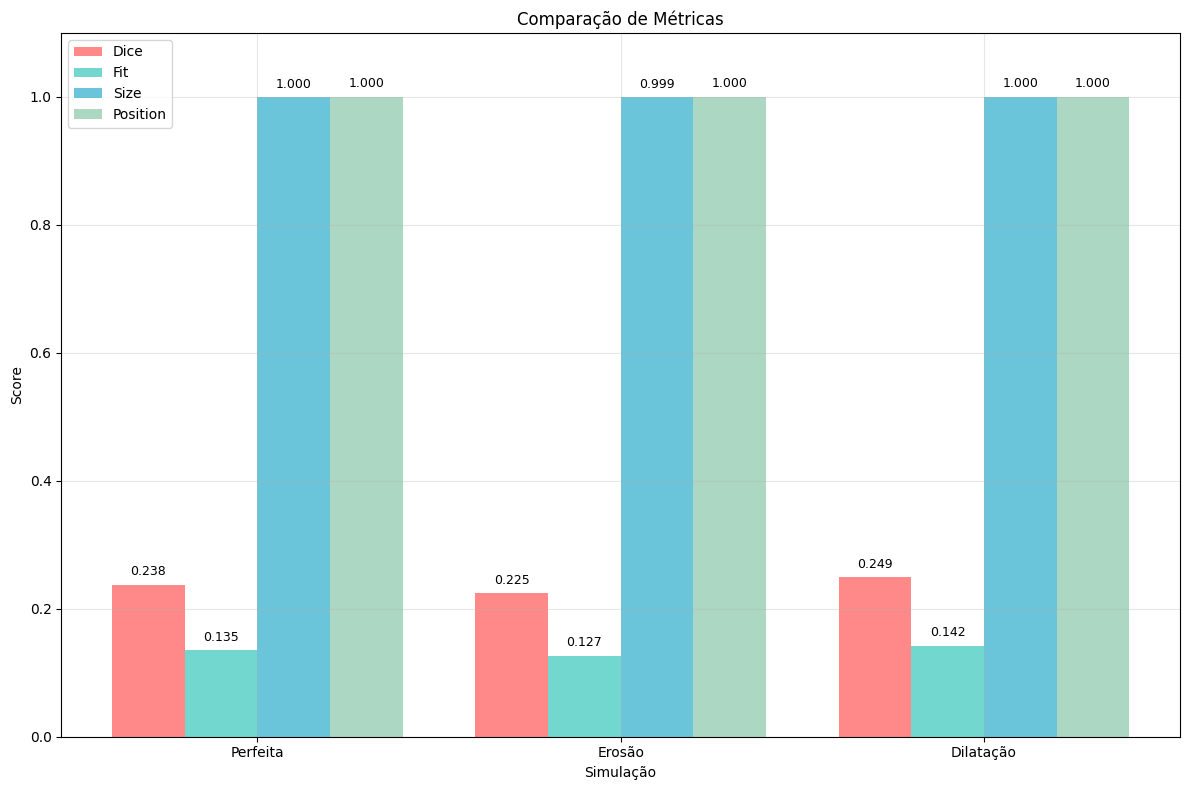

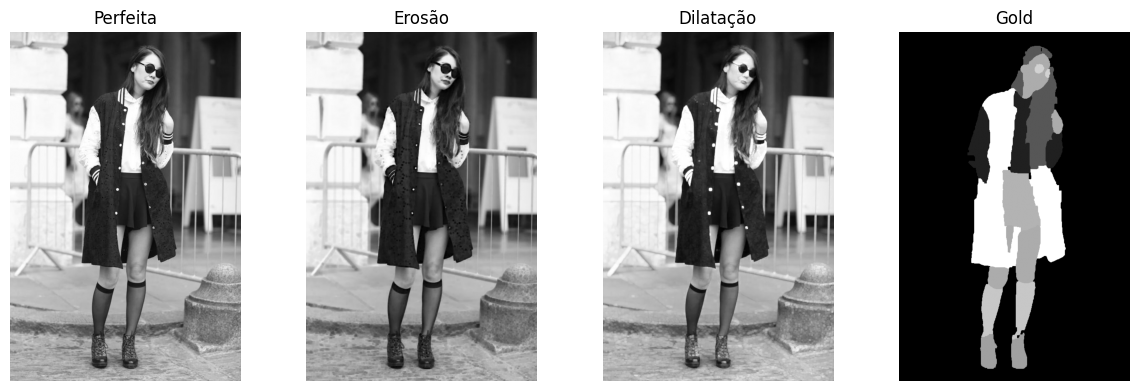

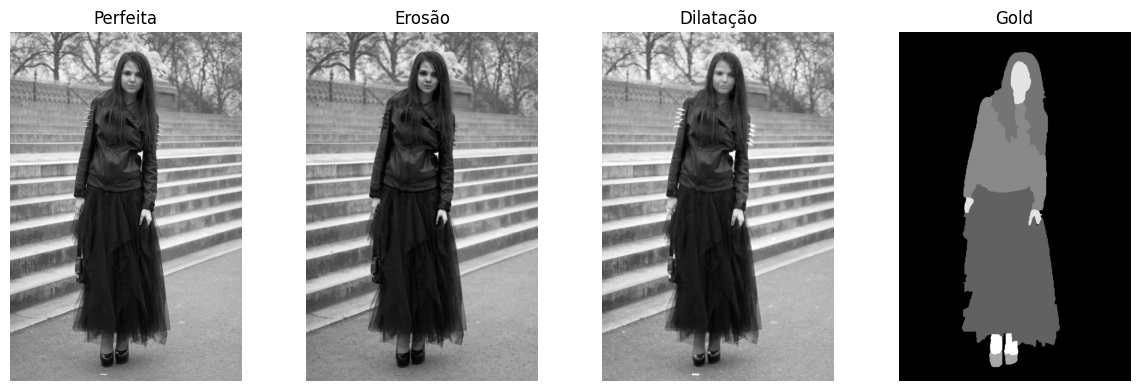

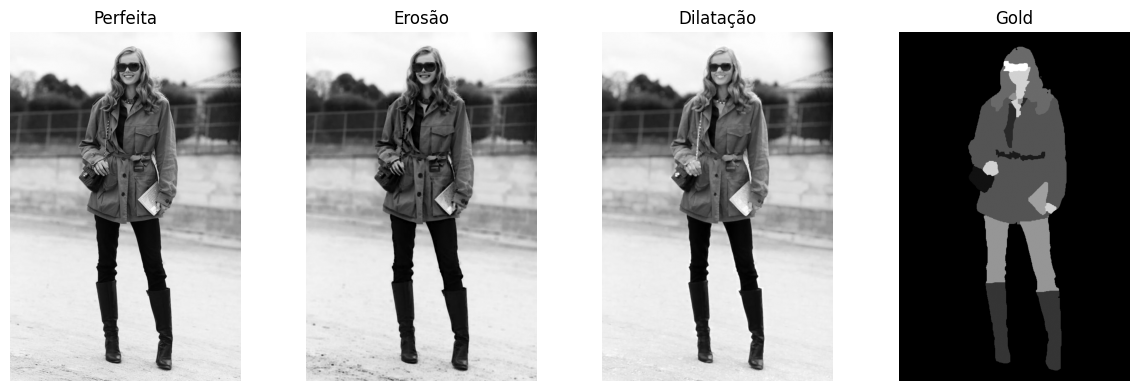

In [62]:

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# MÉTRICAS
# -------------------------
def compute_dice_similarity(array, arrayRef):
    imand = np.bitwise_and(array.astype("uint8"), arrayRef.astype("uint8"))
    sumand = 2 * np.sum(imand)
    sumor = np.sum(array) + np.sum(arrayRef)
    return sumand / float(sumor)

def compute_fit_adjust(array, arrayRef):
    imand = np.bitwise_and(array.astype("uint8"), arrayRef.astype("uint8"))
    imor = np.bitwise_or(array.astype("uint8"), arrayRef.astype("uint8"))
    return np.sum(imand) / float(np.sum(imor))

def compute_size_adjust(array, arrayRef):
    imArea1 = np.count_nonzero(arrayRef)
    imArea2 = np.count_nonzero(array)
    return 1 - abs(imArea1 - imArea2) / (imArea1 + imArea2)

def compute_position_adjust(arraySeg, arrayRef):
    indsSeg = np.where(arraySeg > 0)
    indsRef = np.where(arrayRef > 0)
    centroidRefY = indsRef[0].mean()
    centroidRefX = indsRef[1].mean()
    centroidSegY = indsSeg[0].mean()
    centroidSegX = indsSeg[1].mean()
    subCentroidY = abs(centroidSegY - centroidRefY) / arrayRef.shape[0]
    subCentroidX = abs(centroidSegX - centroidRefX) / arrayRef.shape[1]
    return 1 - (subCentroidY + subCentroidX) / 3

# -------------------------
# FUNÇÕES AUXILIARES
# -------------------------
def ler_imagem_gray(path):
    if os.path.exists(path):
        return cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return None

def aplicar_simulacao(img, tipo="original"):
    if tipo == "erosao":
        kernel = np.ones((3,3), np.uint8)
        return cv2.erode(img, kernel, iterations=1)
    elif tipo == "dilatacao":
        kernel = np.ones((3,3), np.uint8)
        return cv2.dilate(img, kernel, iterations=1)
    return img.copy()

def calcular_metricas_imagem(img, lbl):
    if img is None or lbl is None:
        return None
    return {
        "dice": compute_dice_similarity(img, lbl),
        "fit": compute_fit_adjust(img, lbl),
        "size": compute_size_adjust(img, lbl),
        "position": compute_position_adjust(img, lbl)
    }

# -------------------------
# PIPELINE
# -------------------------
def testar_metricas_clothing_dataset(df_valido, n=3):
    results = []
    seg_erosao = []
    seg_dilatacao = []
    gold_imgs = []

    df_teste = df_valido.head(n)

    for _, row in df_teste.iterrows():
        img = ler_imagem_gray(row['image_path_full'])
        lbl = ler_imagem_gray(row['label_path_full'])
        if img is None or lbl is None:
            continue
        results.append(calcular_metricas_imagem(img, lbl))
        gold_imgs.append(lbl)
        seg_erosao.append(aplicar_simulacao(img, "erosao"))
        seg_dilatacao.append(aplicar_simulacao(img, "dilatacao"))

    return {
        "results": results,
        "seg_erosao": seg_erosao,
        "seg_dilatacao": seg_dilatacao,
        "gold": gold_imgs
    }

def evaluate_segmentation_complete(seg_list, gold_list):
    metrics = {"dice": [], "fit": [], "size": [], "position": []}
    for img, lbl in zip(seg_list, gold_list):
        m = calcular_metricas_imagem(img, lbl)
        if m is not None:
            for k in metrics:
                metrics[k].append(m[k])
    return {f"mean_{k}": np.mean(v) if v else 0 for k, v in metrics.items()}

def plot_metrics_comparison(results_list, labels=["Perfeita","Erosão","Dilatação"]):
    metrics = ['mean_dice','mean_fit','mean_size','mean_position']
    metric_labels = ['Dice','Fit','Size','Position']
    x = range(len(results_list))
    width = 0.2
    colors = ['#FF6B6B','#4ECDC4','#45B7D1','#96CEB4']

    fig, ax = plt.subplots(figsize=(12,8))
    for i, metrica in enumerate(metrics):
        values = [res[metrica] if res else 0 for res in results_list]
        positions = [pos + width*i for pos in x]
        bars = ax.bar(positions, values, width, label=metric_labels[i], color=colors[i], alpha=0.8)
        for bar, value in zip(bars, values):
            ax.text(bar.get_x()+bar.get_width()/2., value+0.01,f'{value:.3f}', ha='center', va='bottom', fontsize=9)
    ax.set_xlabel('Simulação')
    ax.set_ylabel('Score')
    ax.set_title('Comparação de Métricas')
    ax.set_xticks([pos+width*1.5 for pos in x])
    ax.set_xticklabels(labels)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0,1.1)
    plt.tight_layout()
    plt.show()

def visualizar_comparacao_clothing(dados_teste, idx=0):
    plt.figure(figsize=(12,4))
    imgs = [
        ler_imagem_gray(df_valido.iloc[idx]['image_path_full']),
        dados_teste['seg_erosao'][idx],
        dados_teste['seg_dilatacao'][idx],
        dados_teste['gold'][idx]
    ]
    titles = ["Perfeita","Erosão","Dilatação","Gold"]
    for i, img in enumerate(imgs):
        plt.subplot(1,4,i+1)
        plt.imshow(img, cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# -------------------------
# EXECUÇÃO DIRETA
# -------------------------
print("EXECUTANDO TESTE DAS MÉTRICAS COM CLOTHING DATASET")
print("="*60)

# Testar com 3 imagens
dados_teste = testar_metricas_clothing_dataset(df_valido, n=3)

if dados_teste and dados_teste['results']:
    # Avaliar todas as simulações
    results_list = [
        evaluate_segmentation_complete(
            [ler_imagem_gray(df_valido.iloc[i]['image_path_full']) for i in range(3)],
            dados_teste['gold']
        ),
        evaluate_segmentation_complete(dados_teste['seg_erosao'], dados_teste['gold']),
        evaluate_segmentation_complete(dados_teste['seg_dilatacao'], dados_teste['gold'])
    ]
    plot_metrics_comparison(results_list)
    for i in range(3):
        visualizar_comparacao_clothing(dados_teste, i)
else:
    print("Não foi possível executar o teste. Verifique df_valido e caminhos de imagem.")


# MÓDULO 9: SEGMENTAÇÃO DE IMAGENS CLASSES

EXECUTANDO TESTE DAS MÉTRICAS POR CLASSE


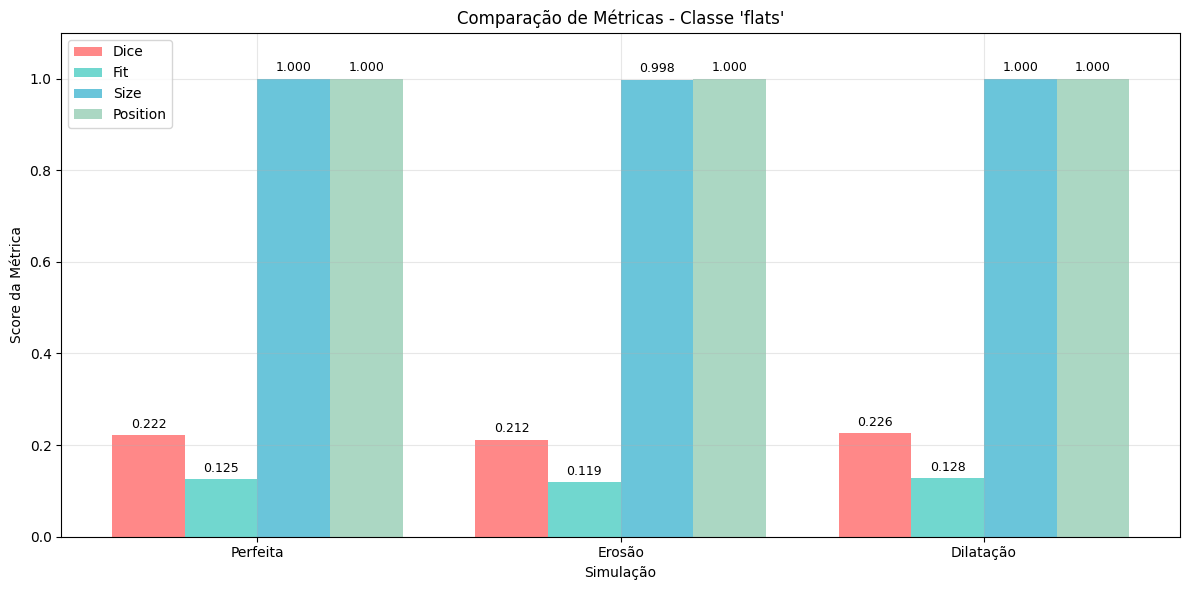

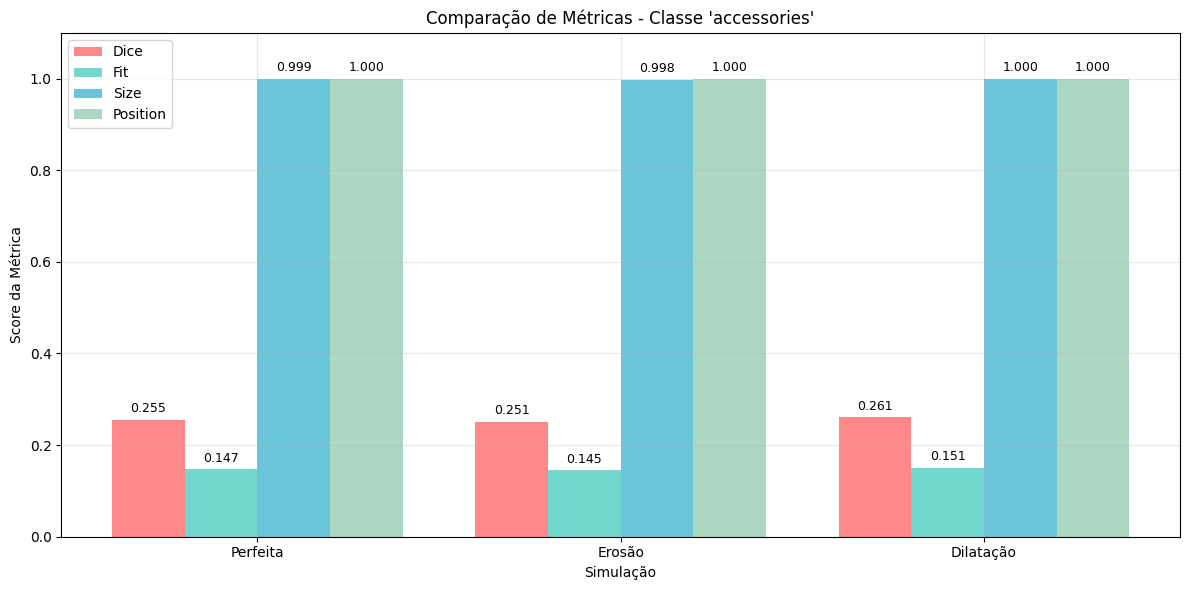

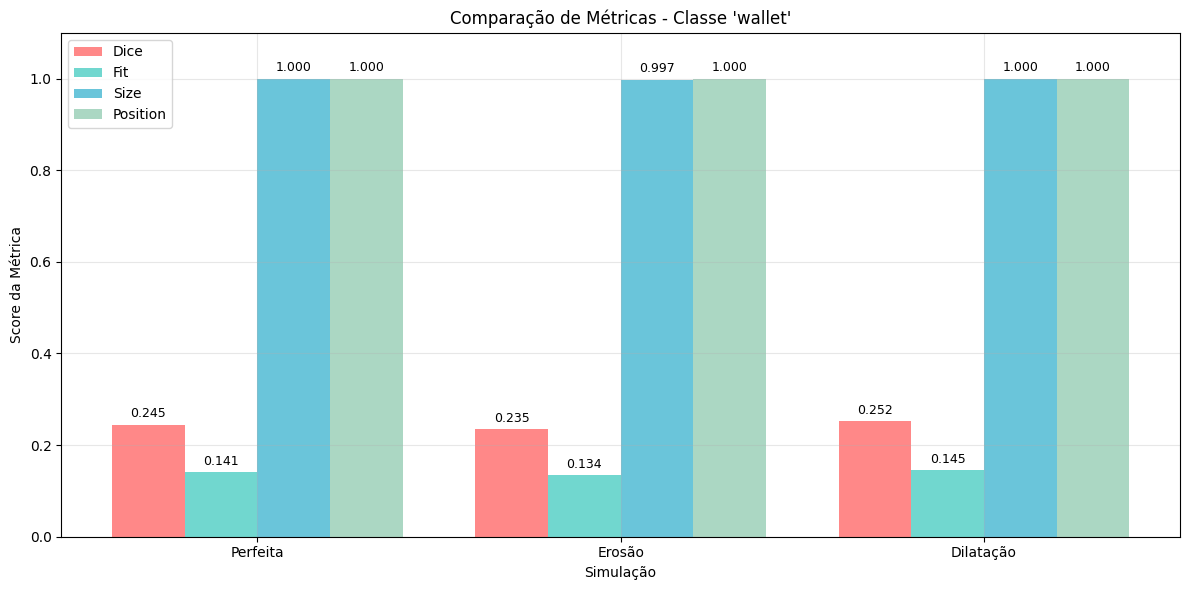

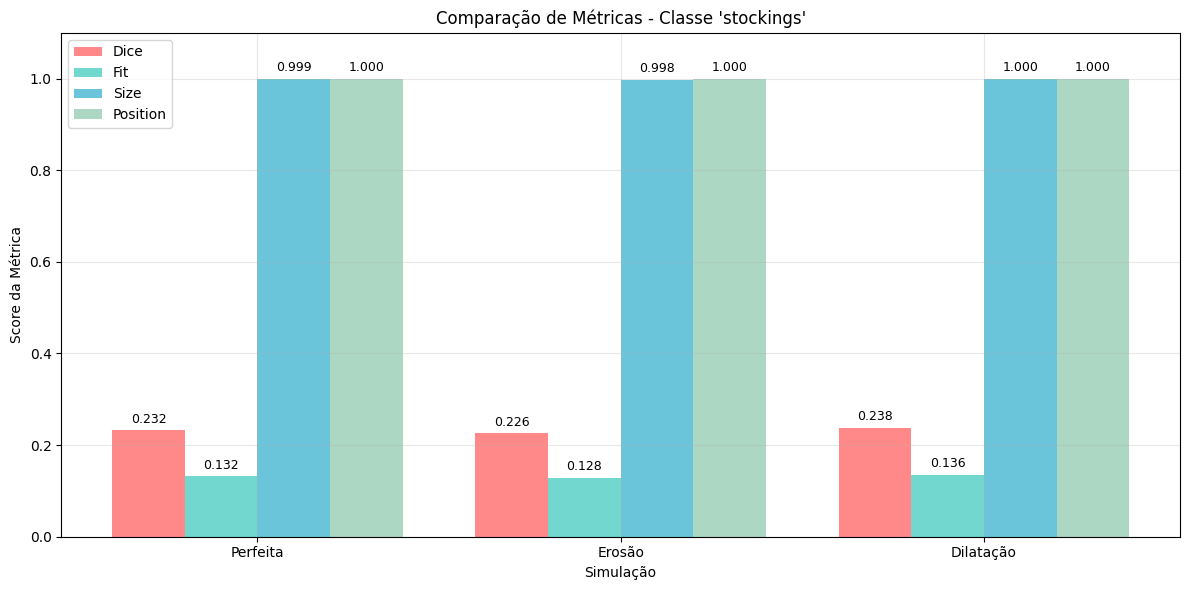

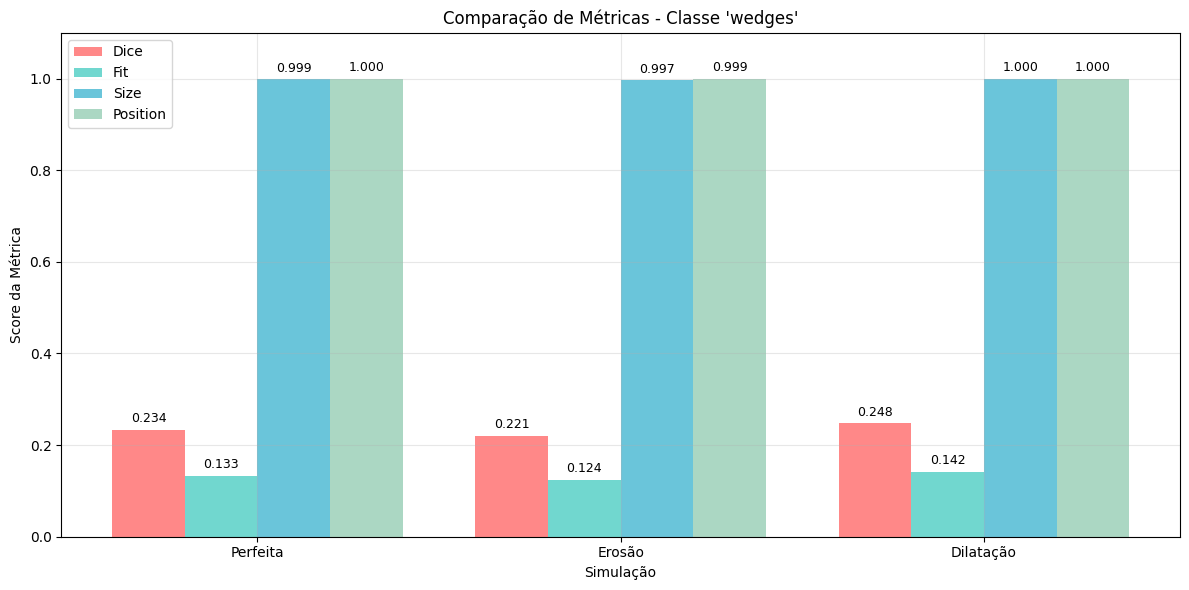

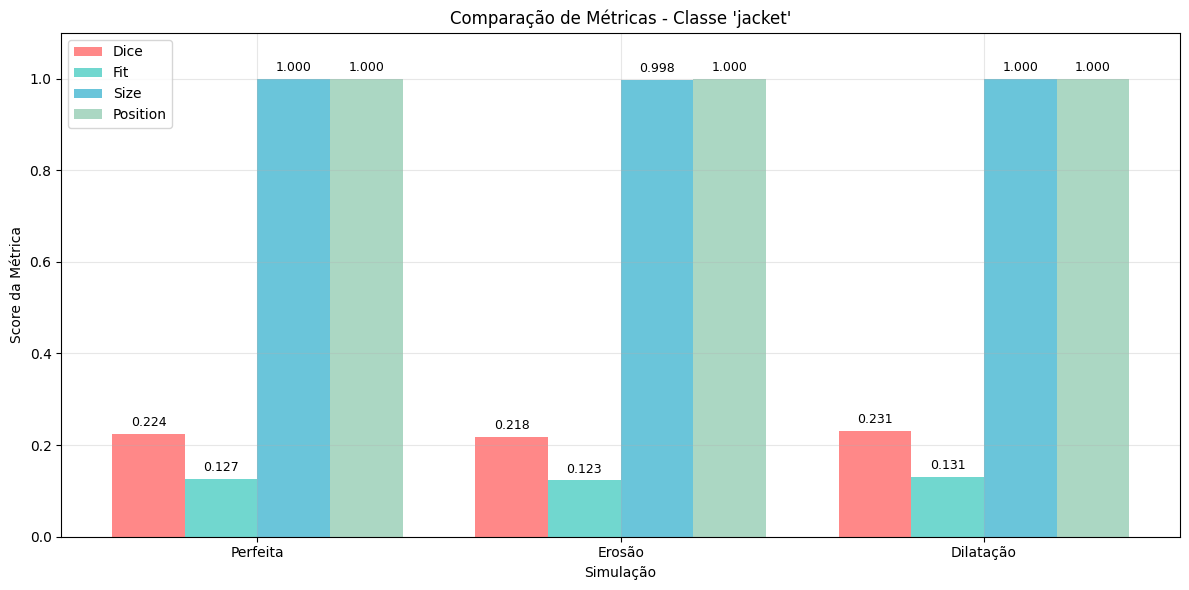

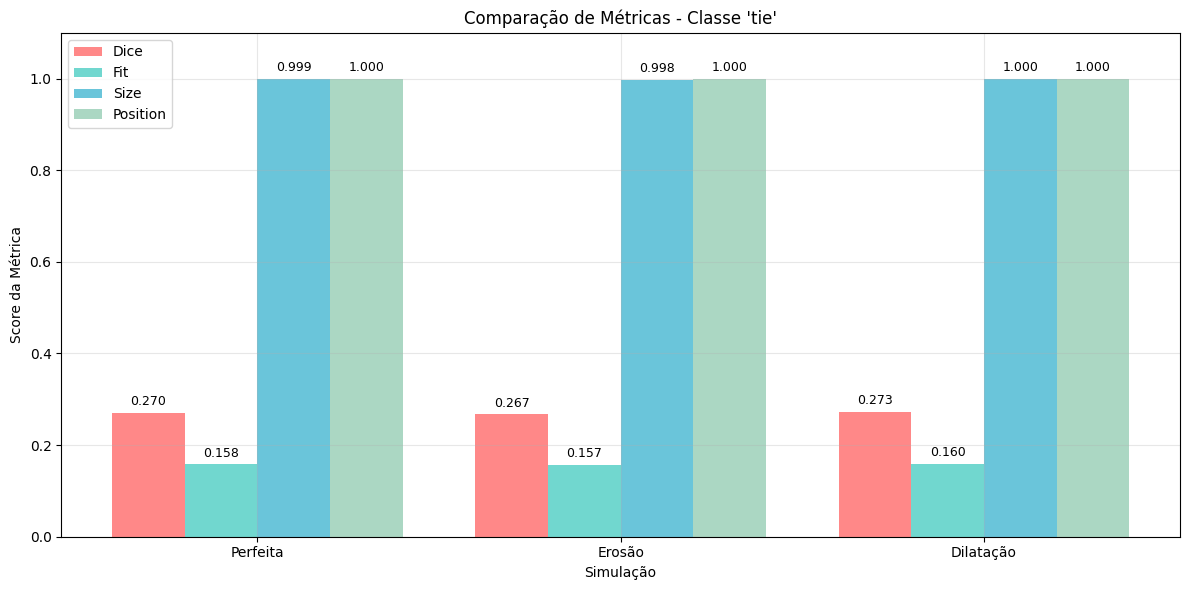

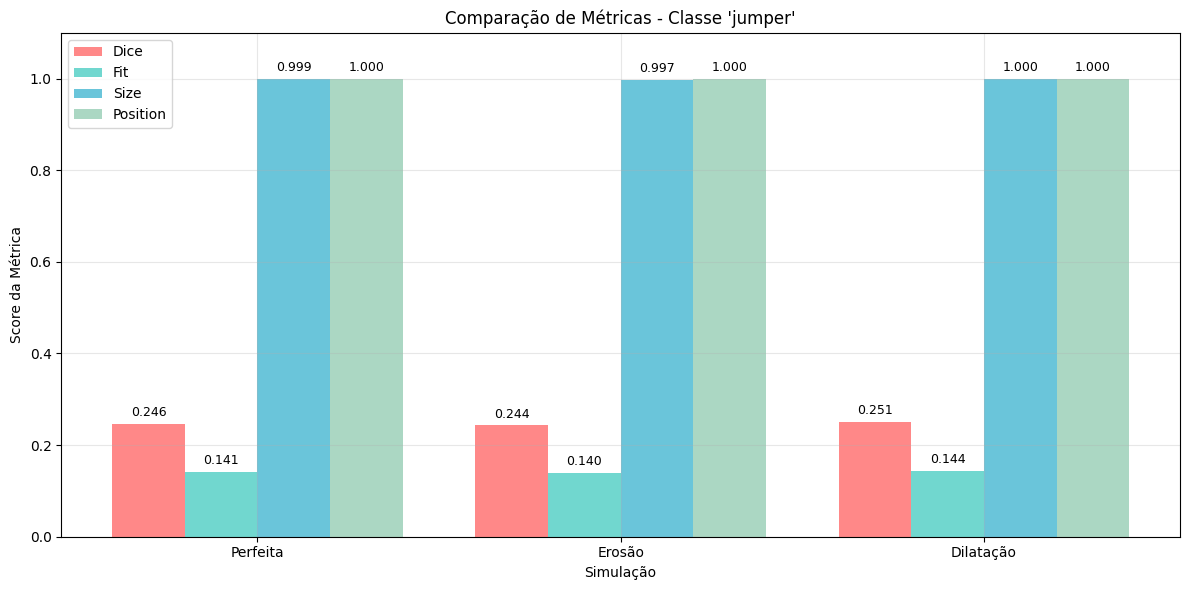

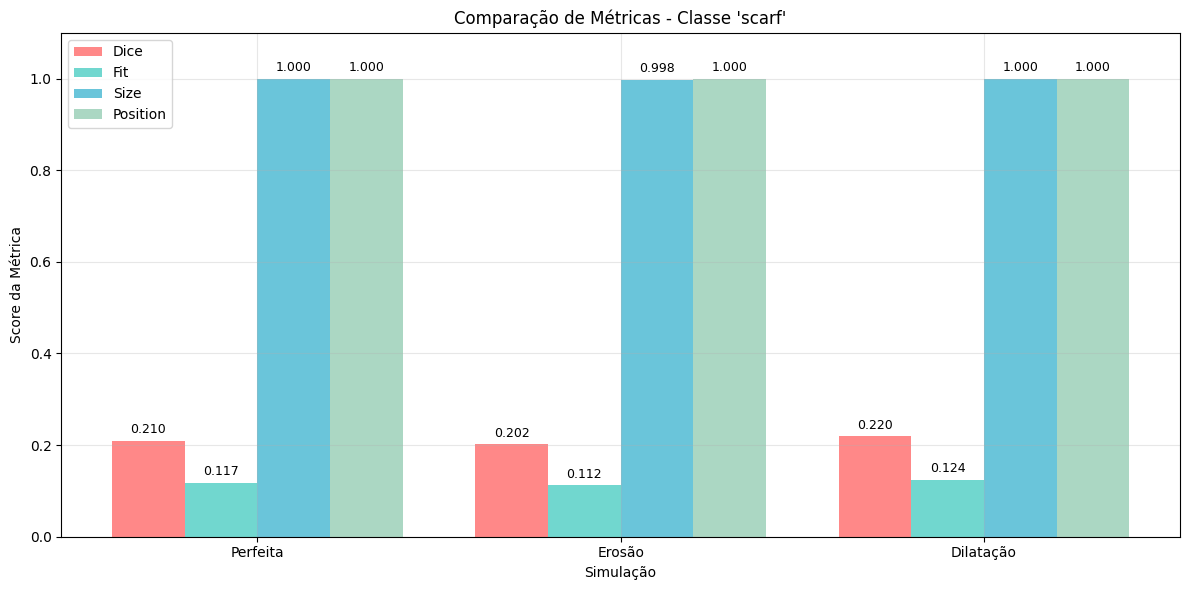

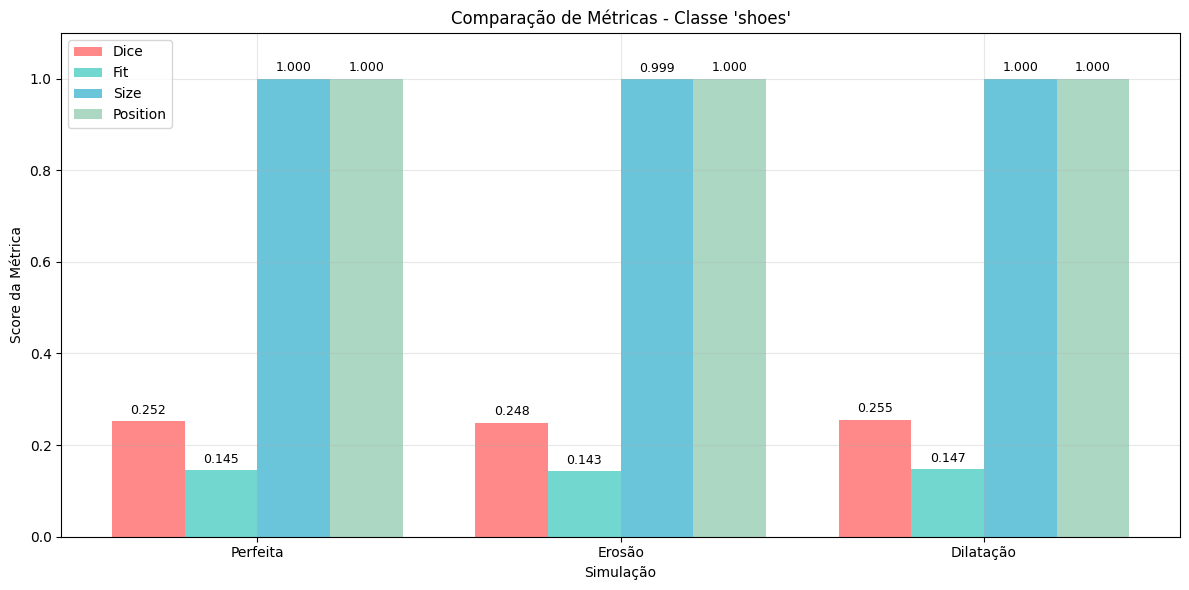

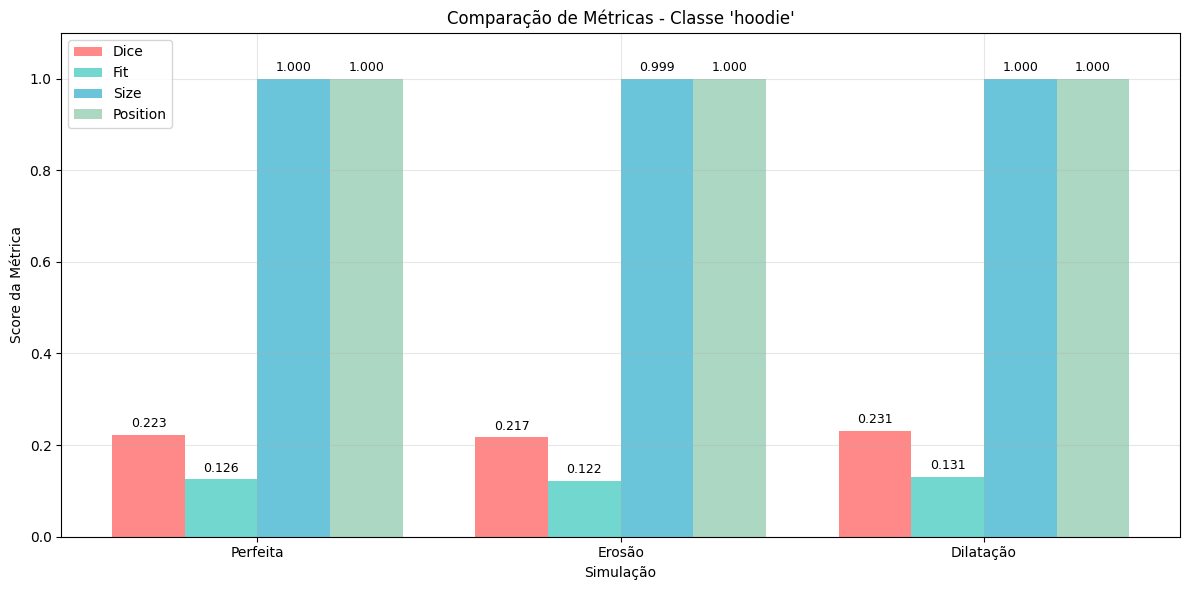

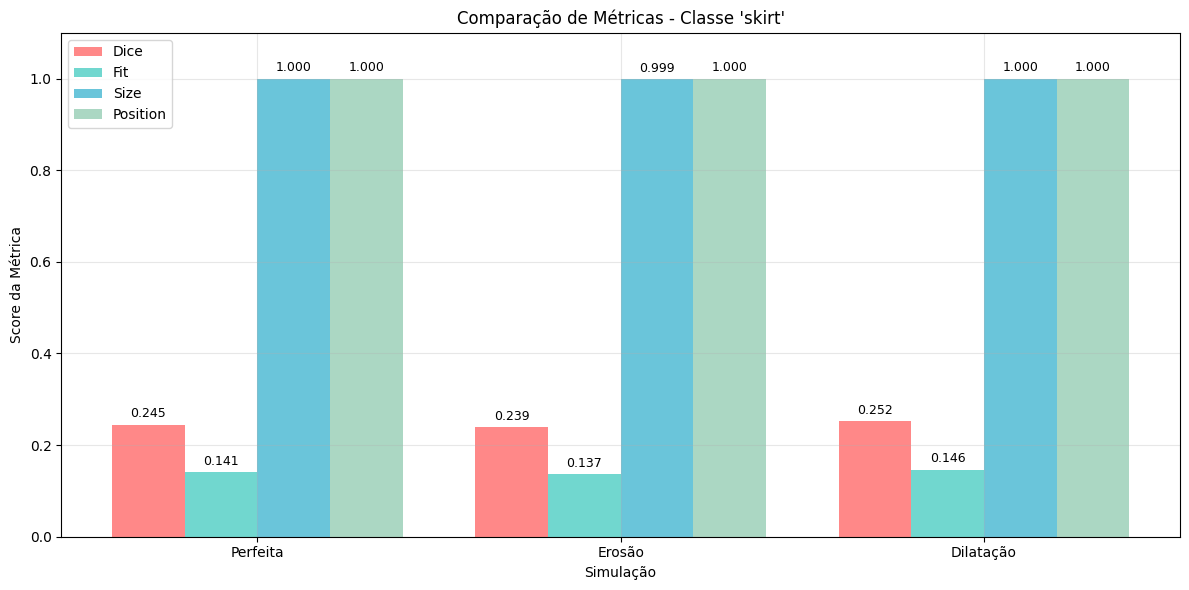

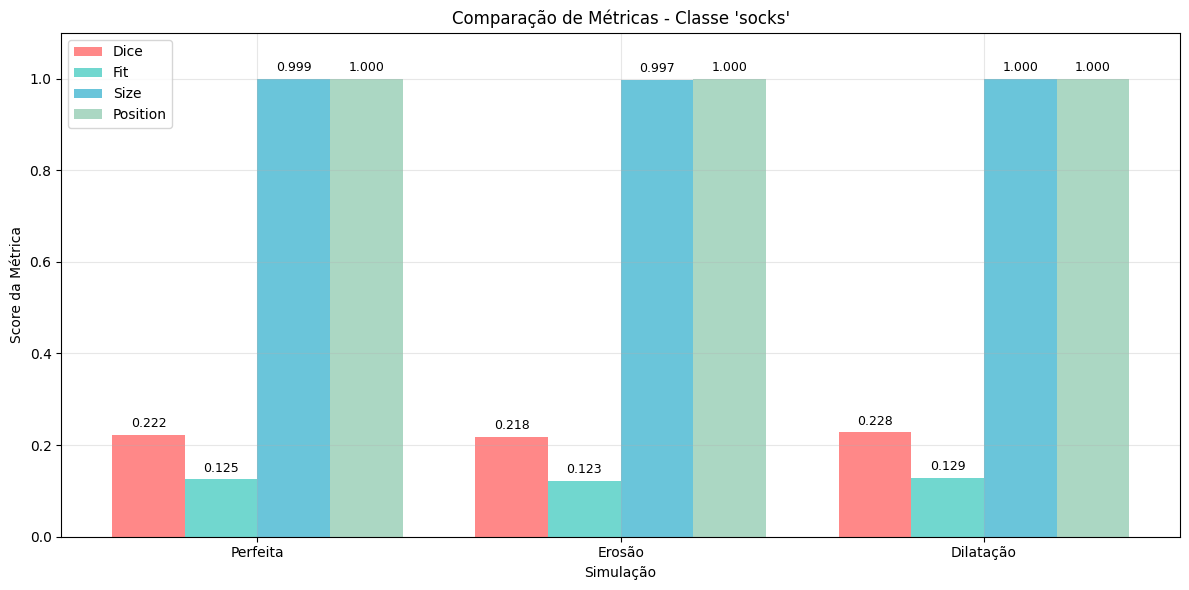

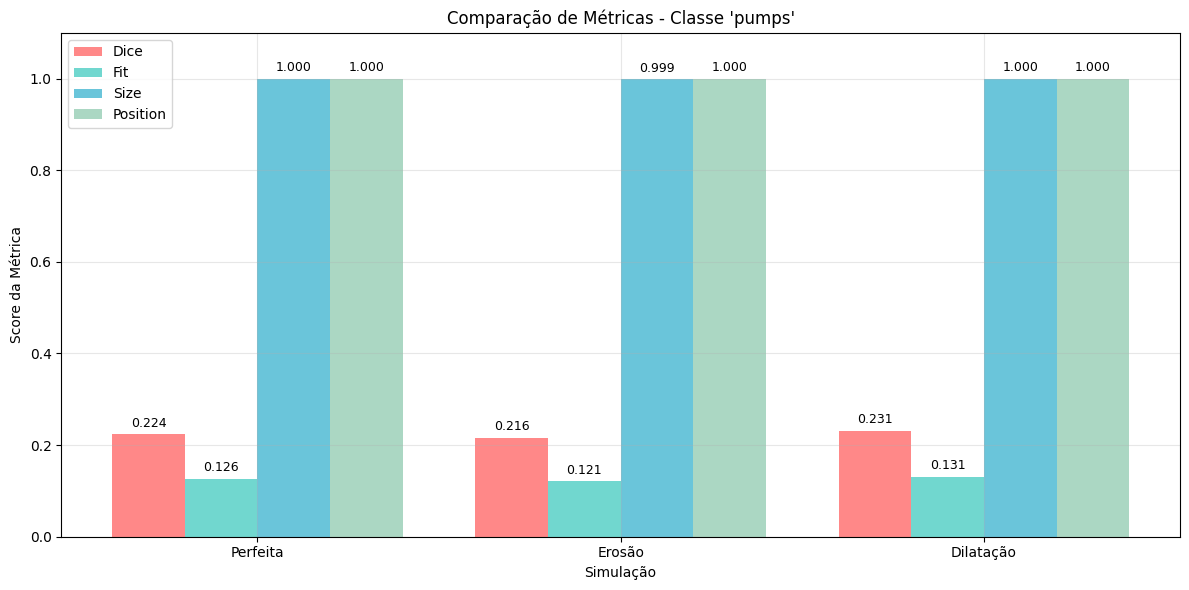

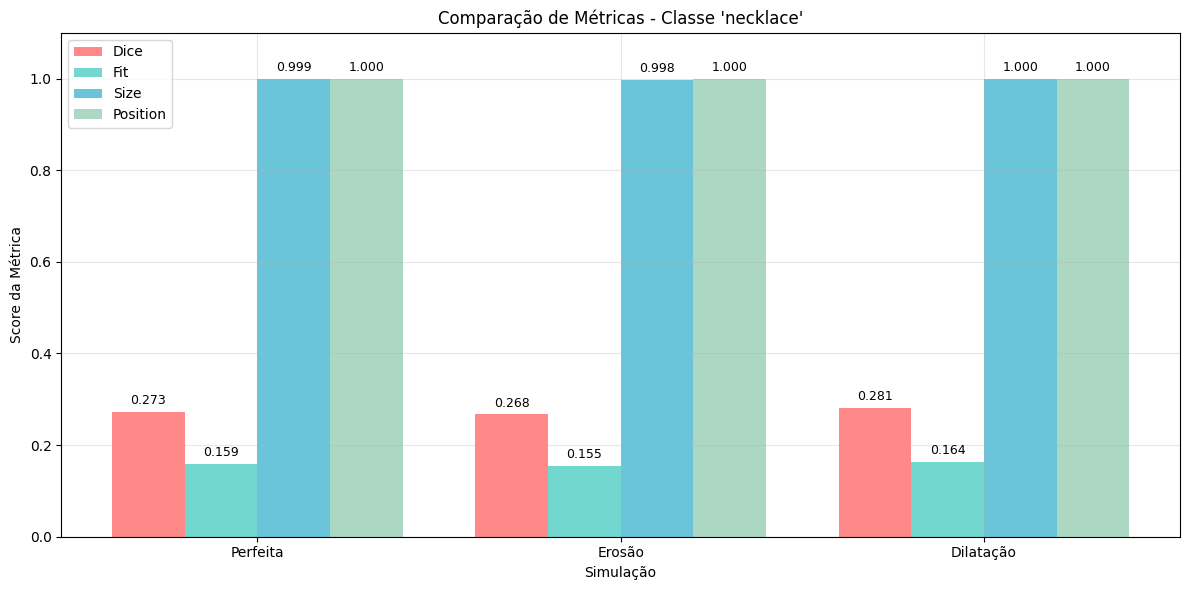

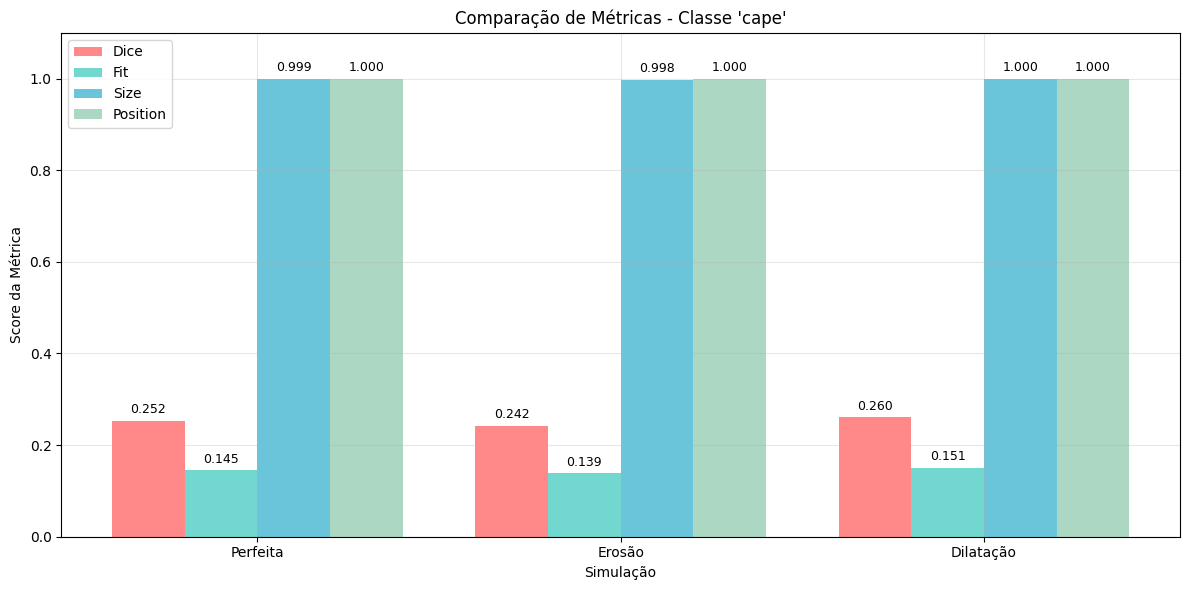

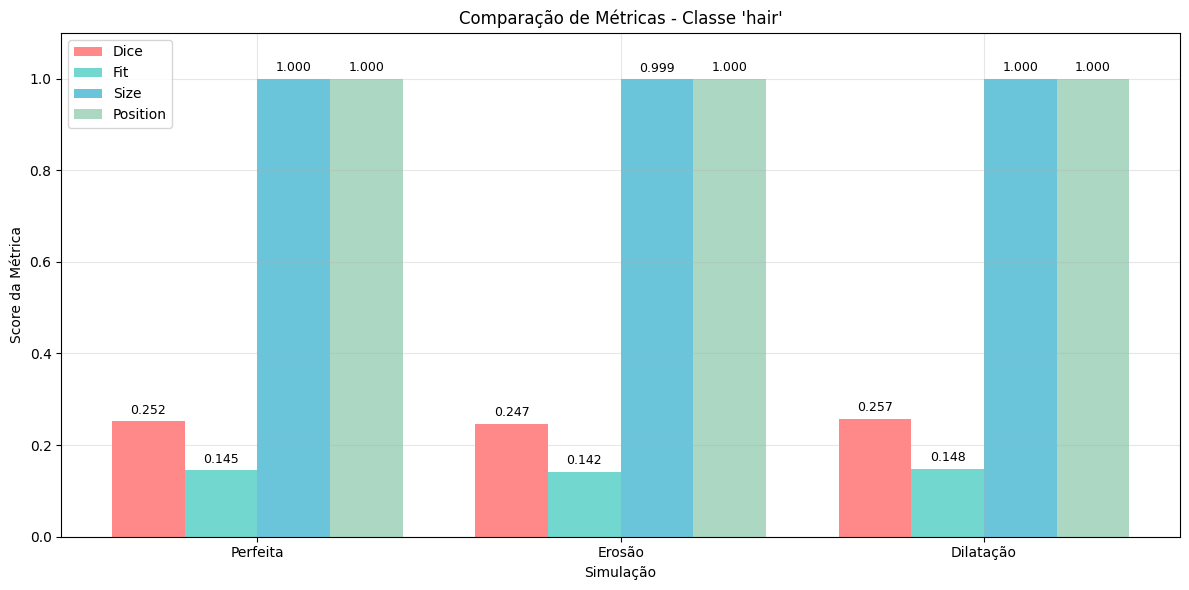

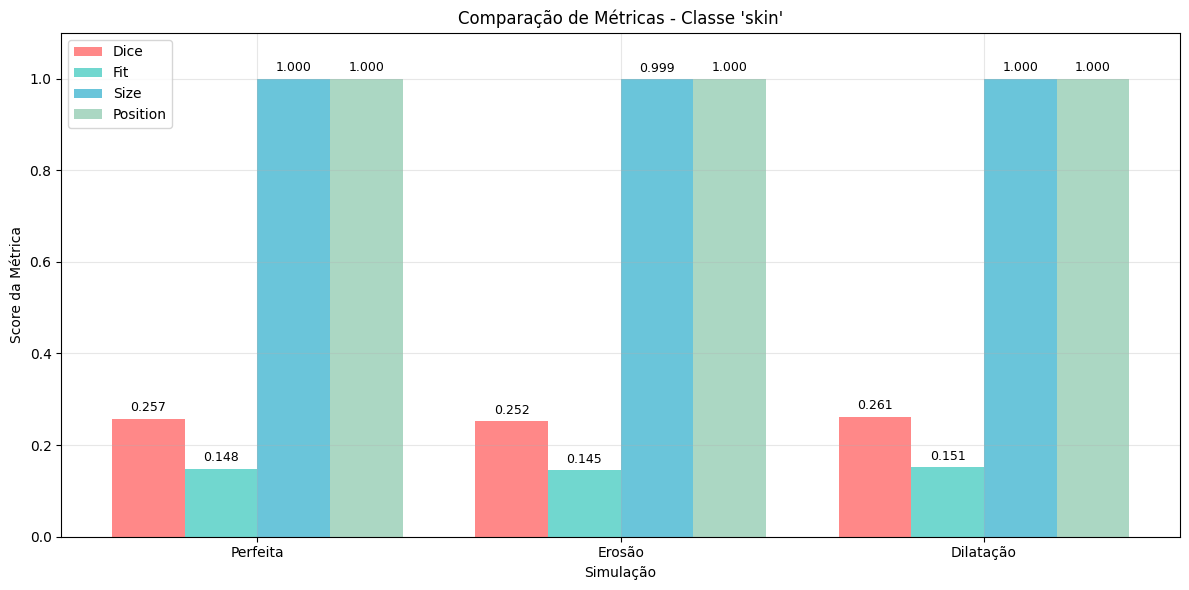

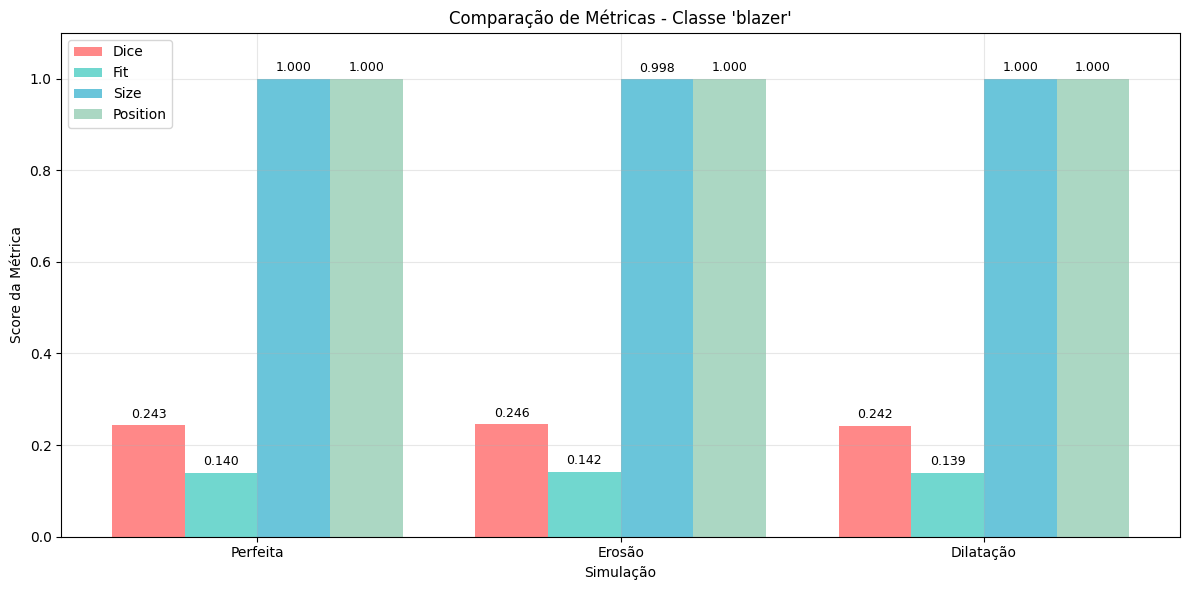

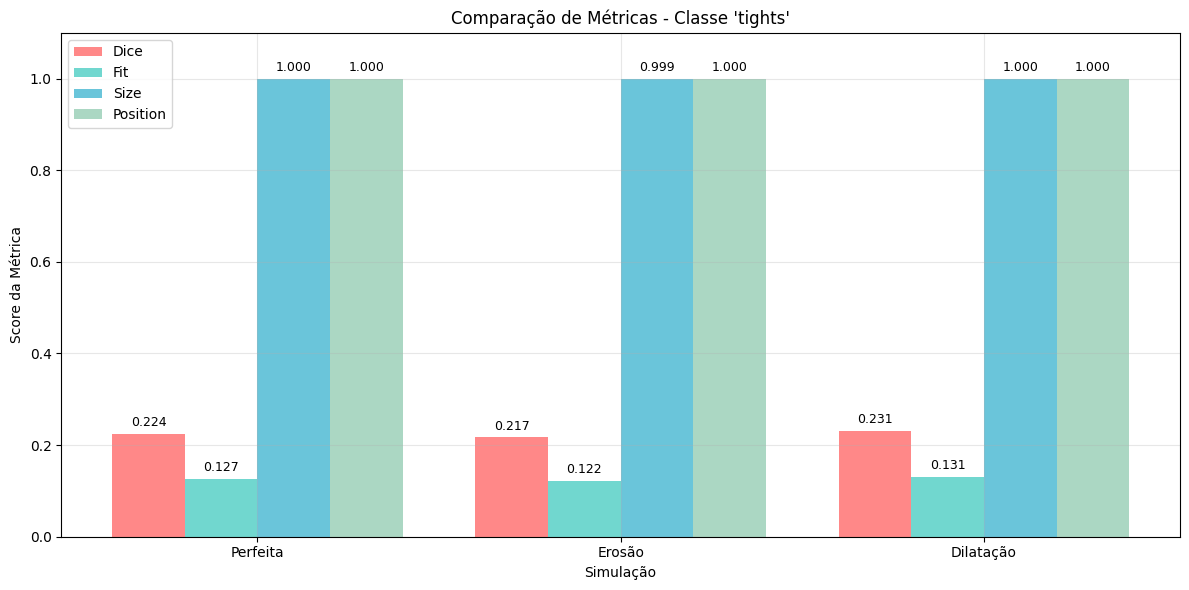

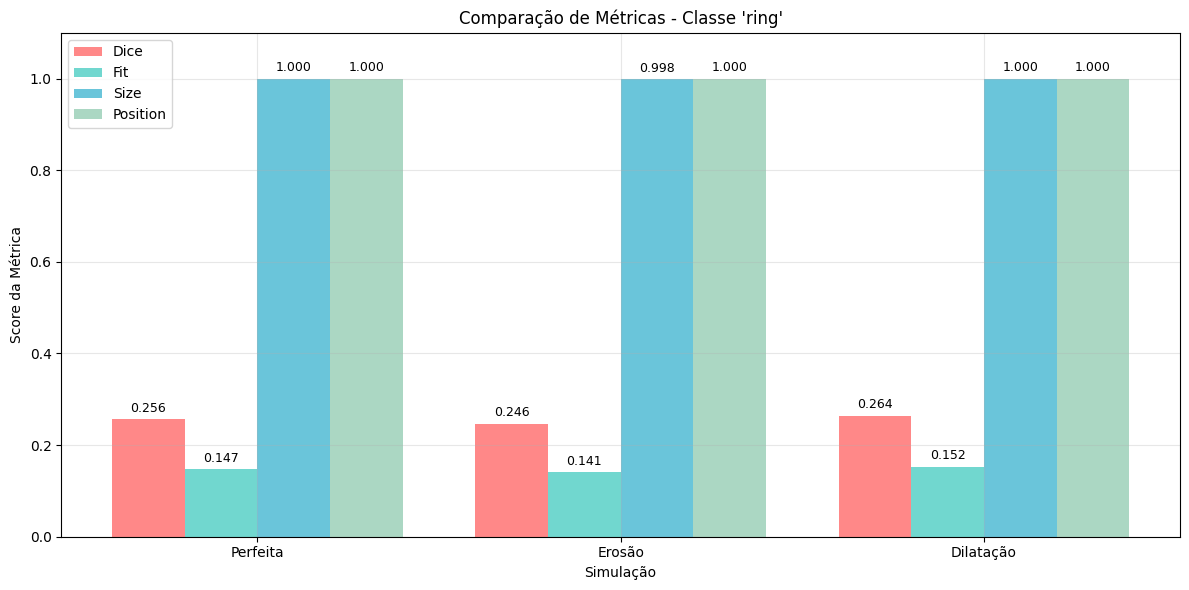

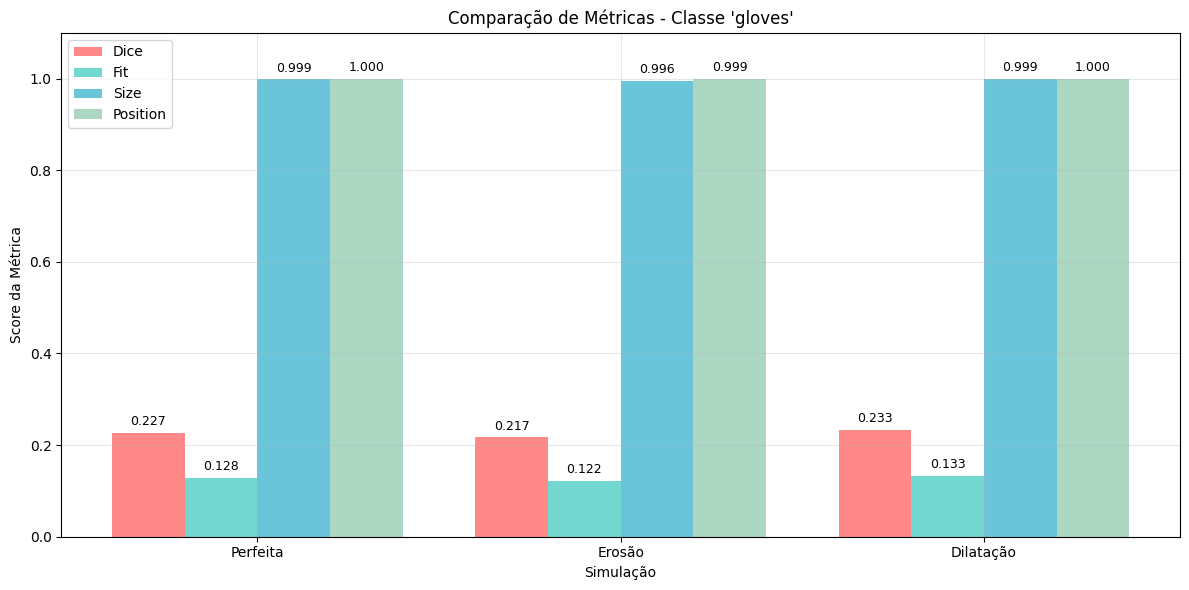

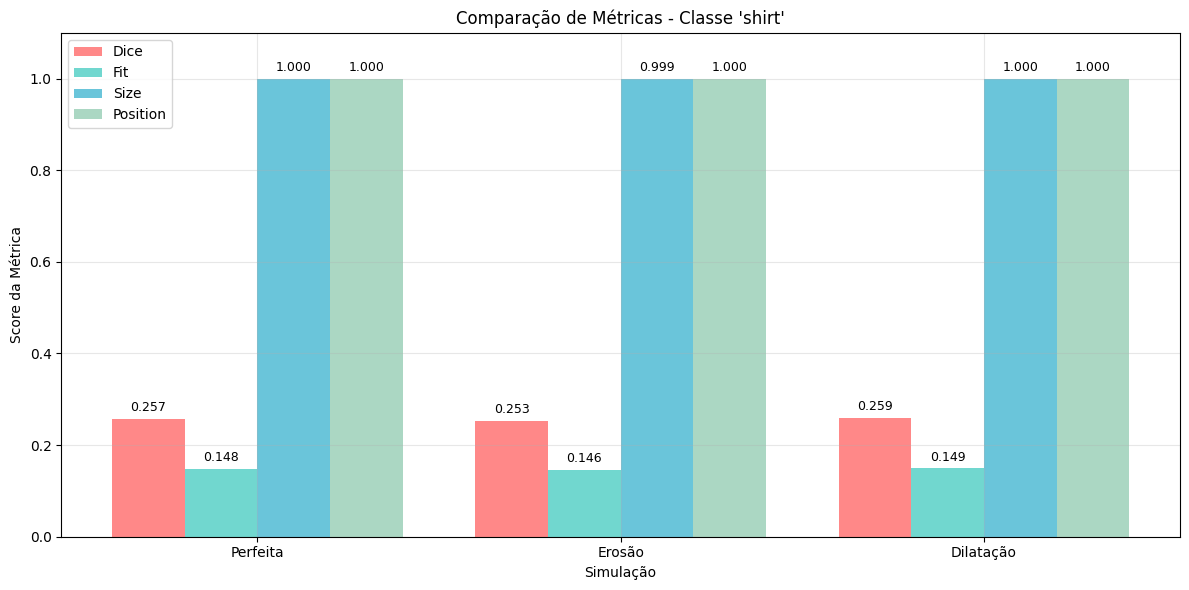

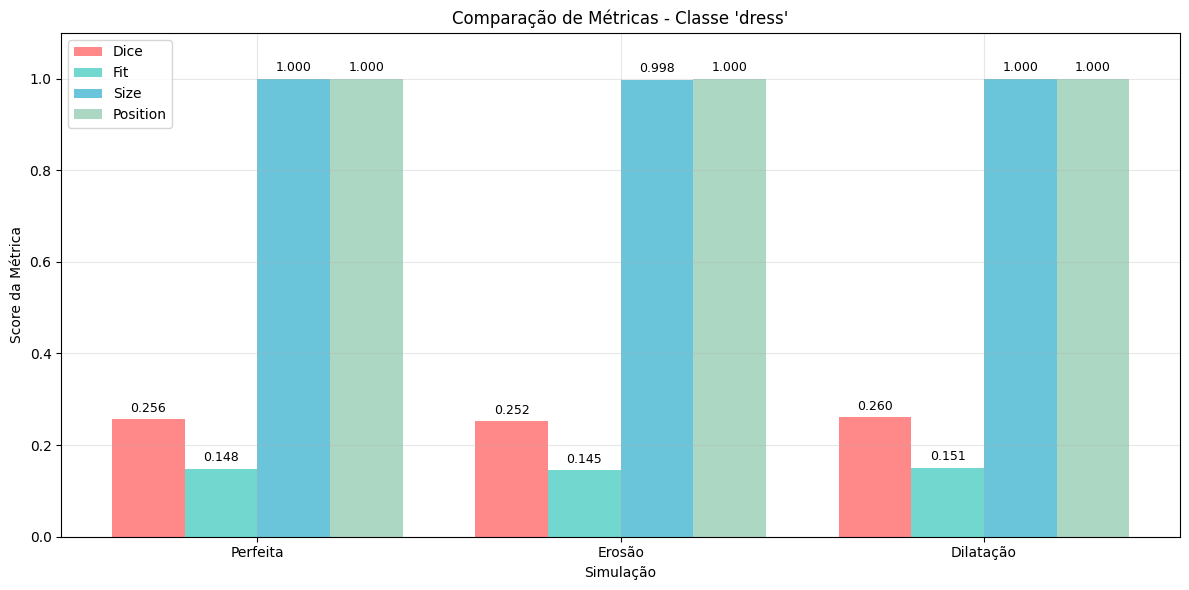

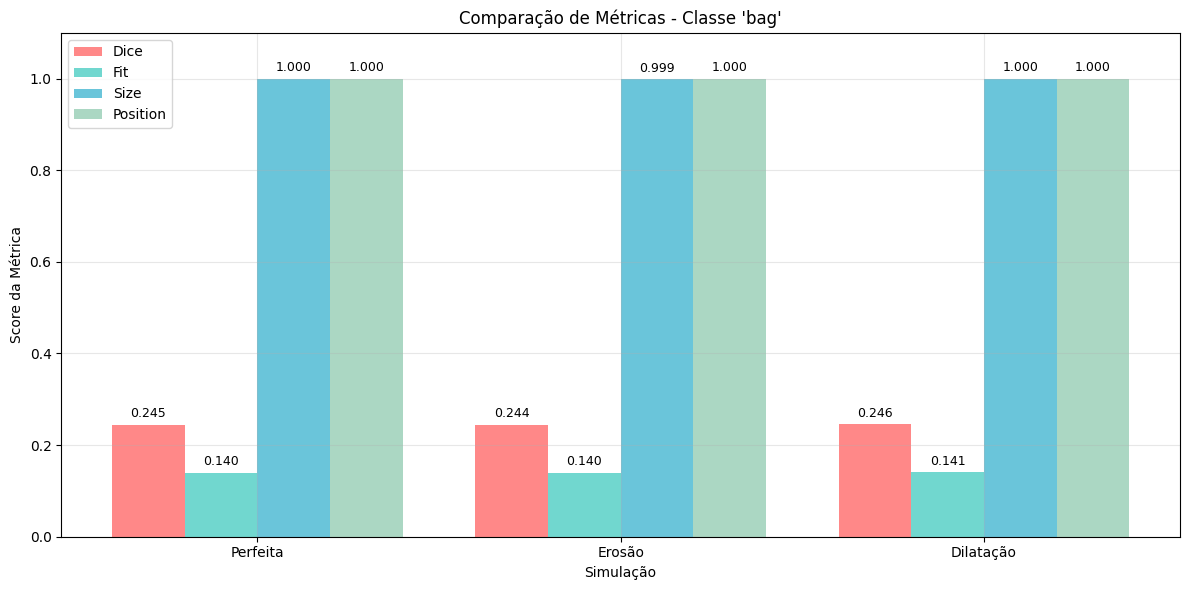

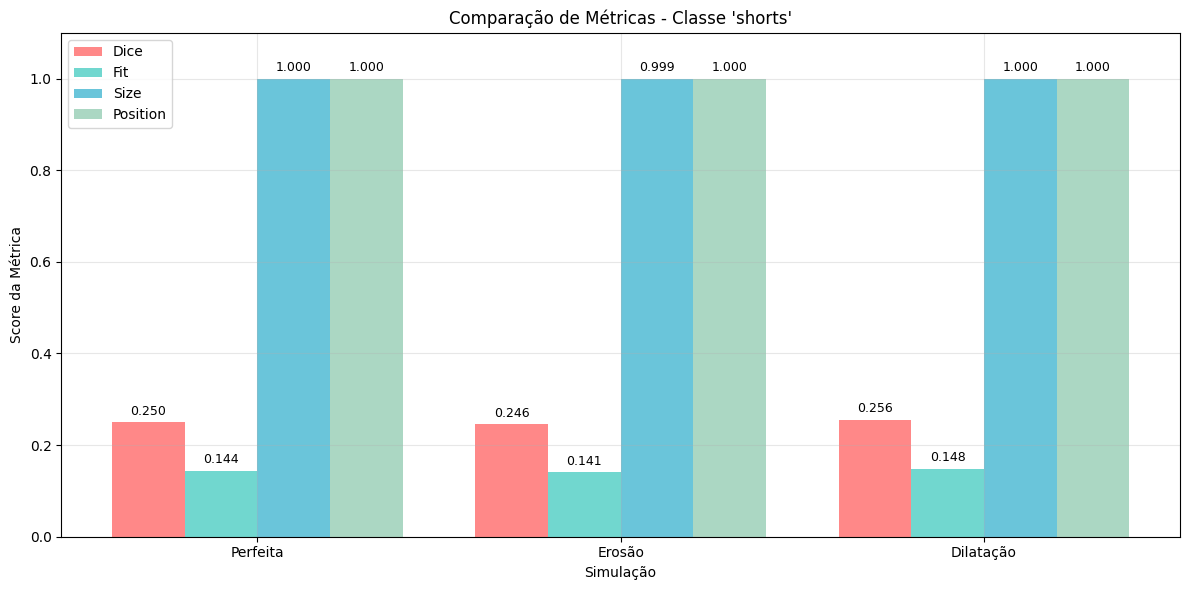

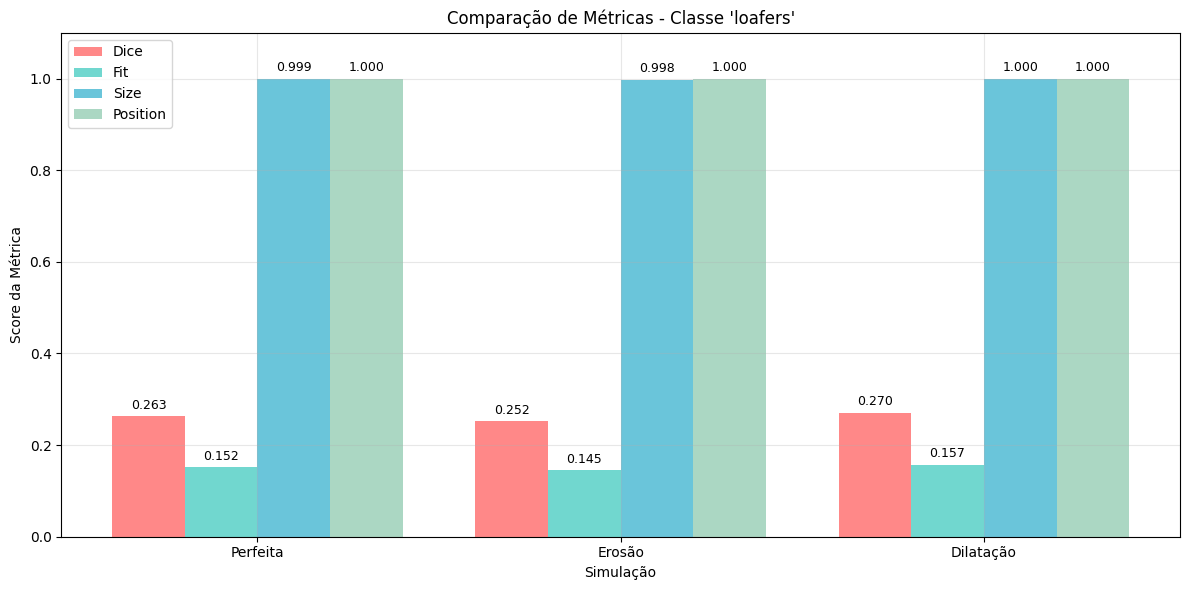

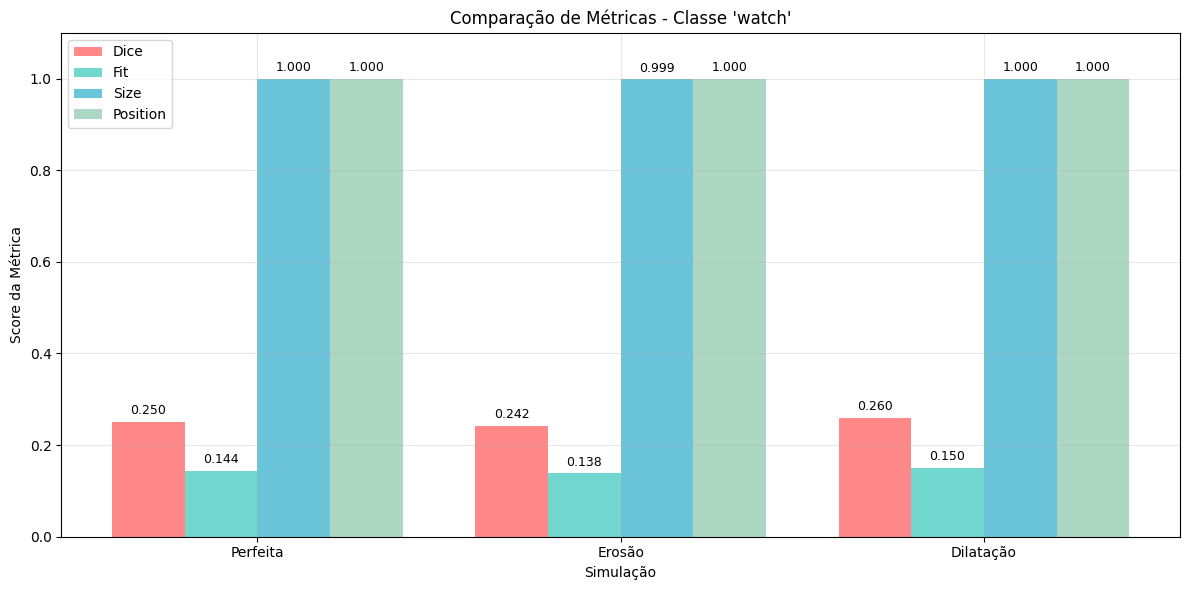

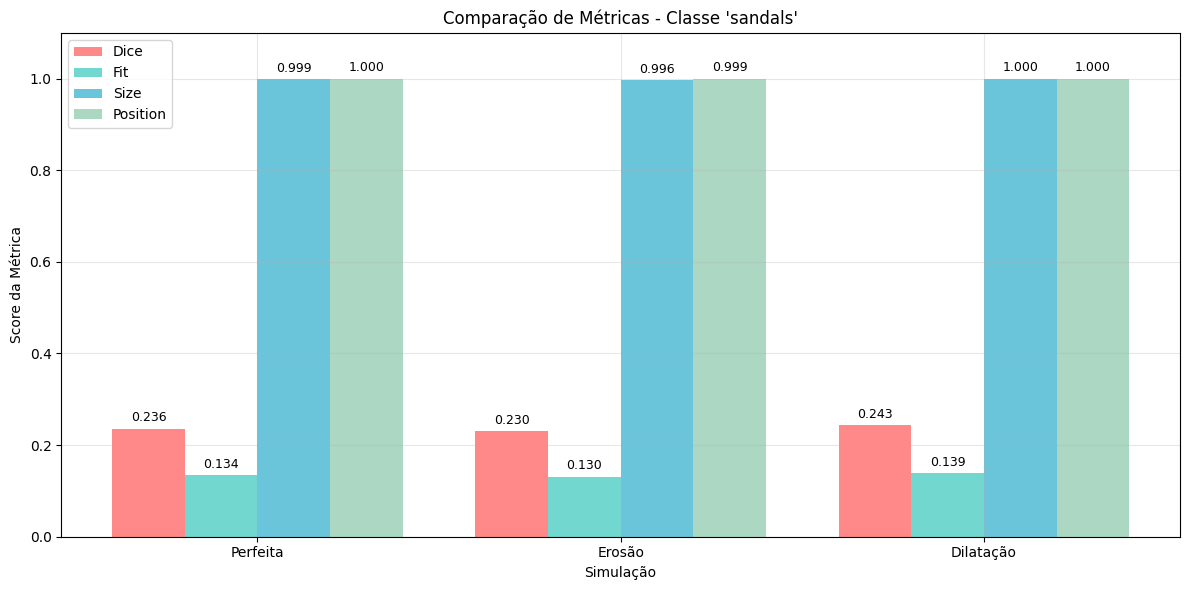

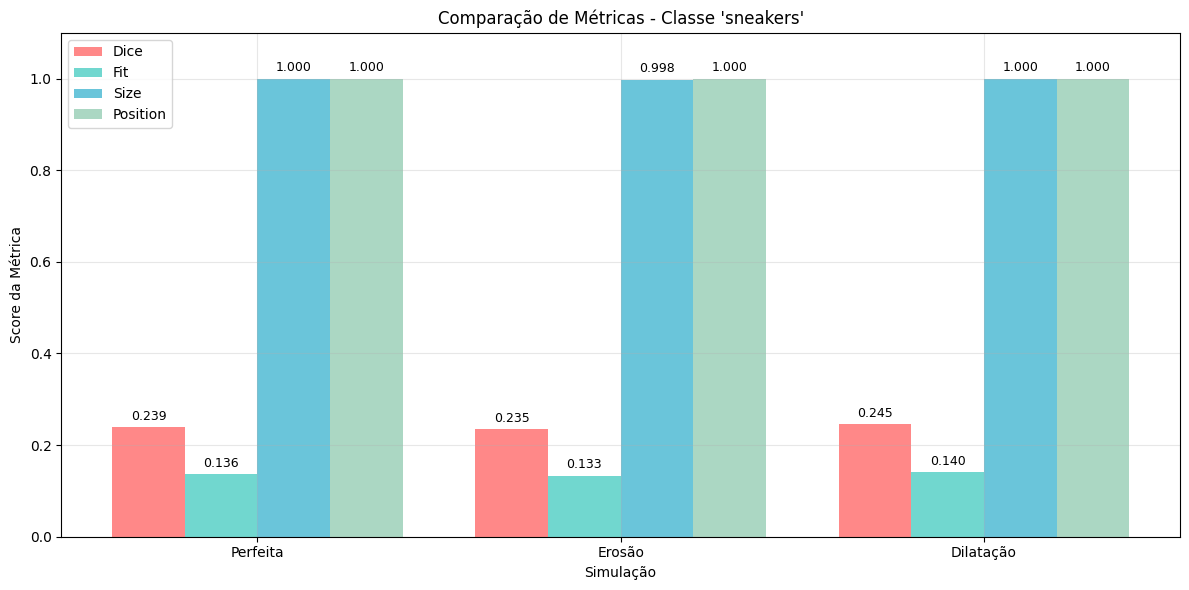

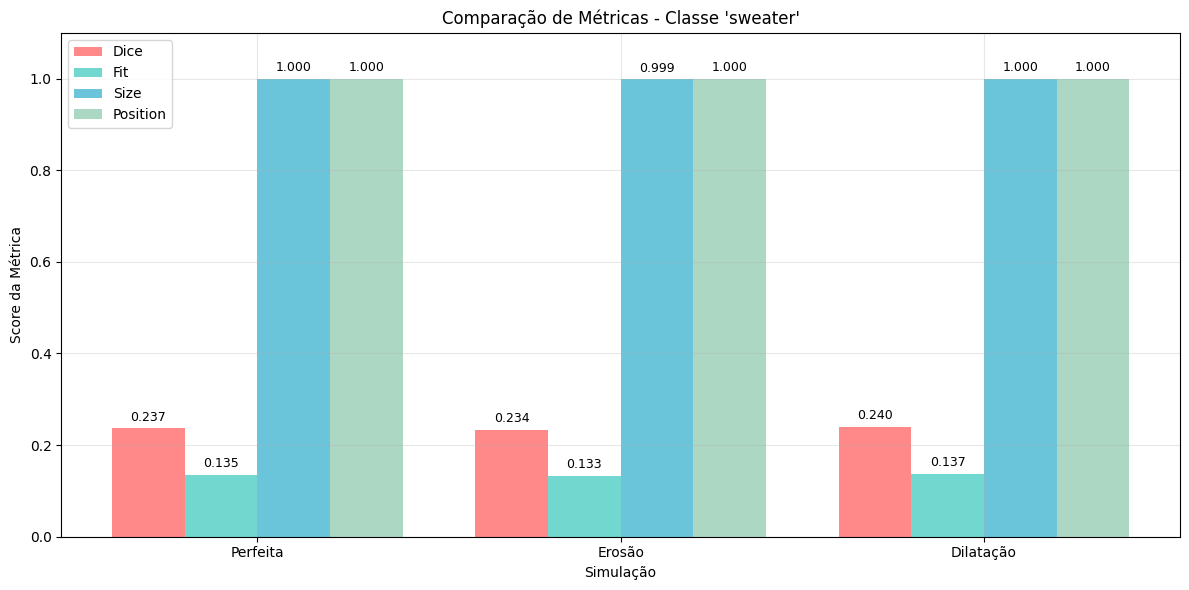

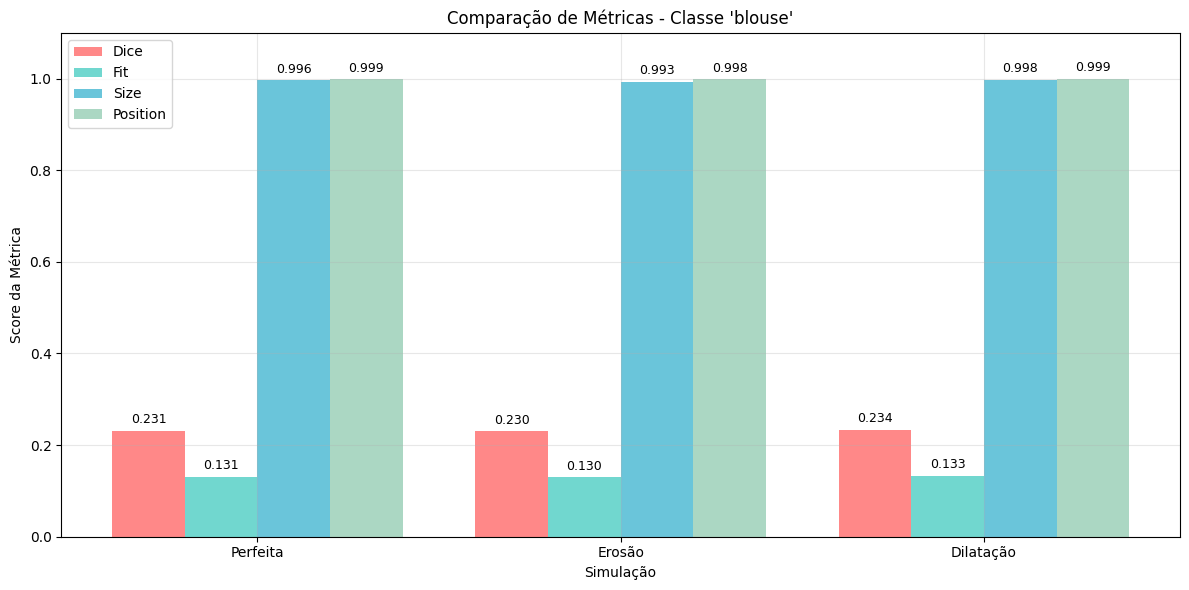

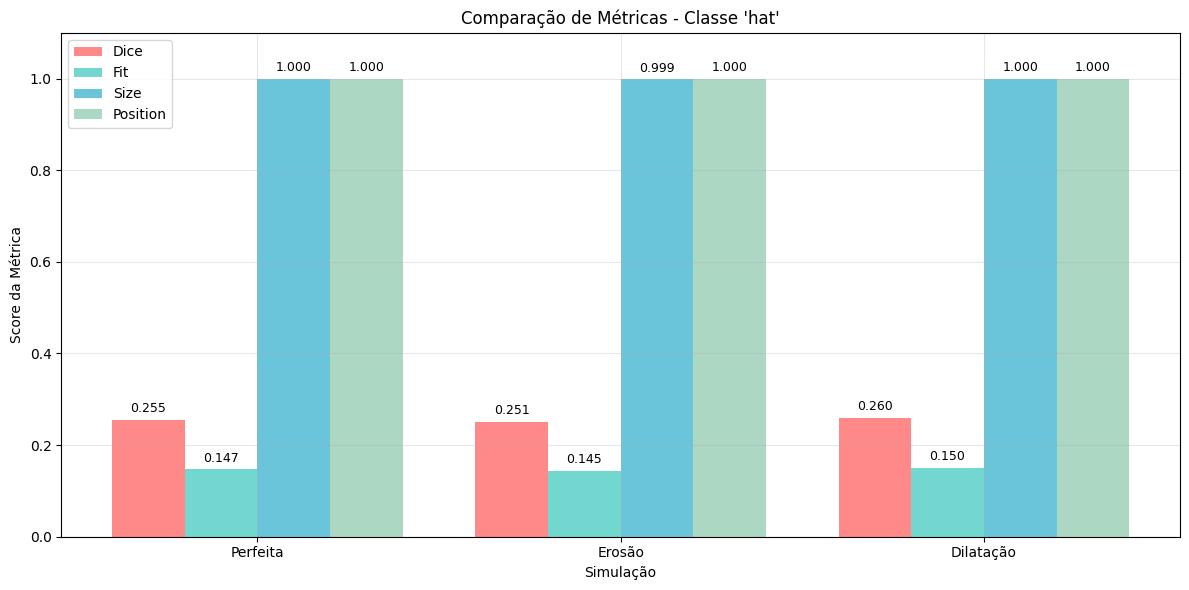

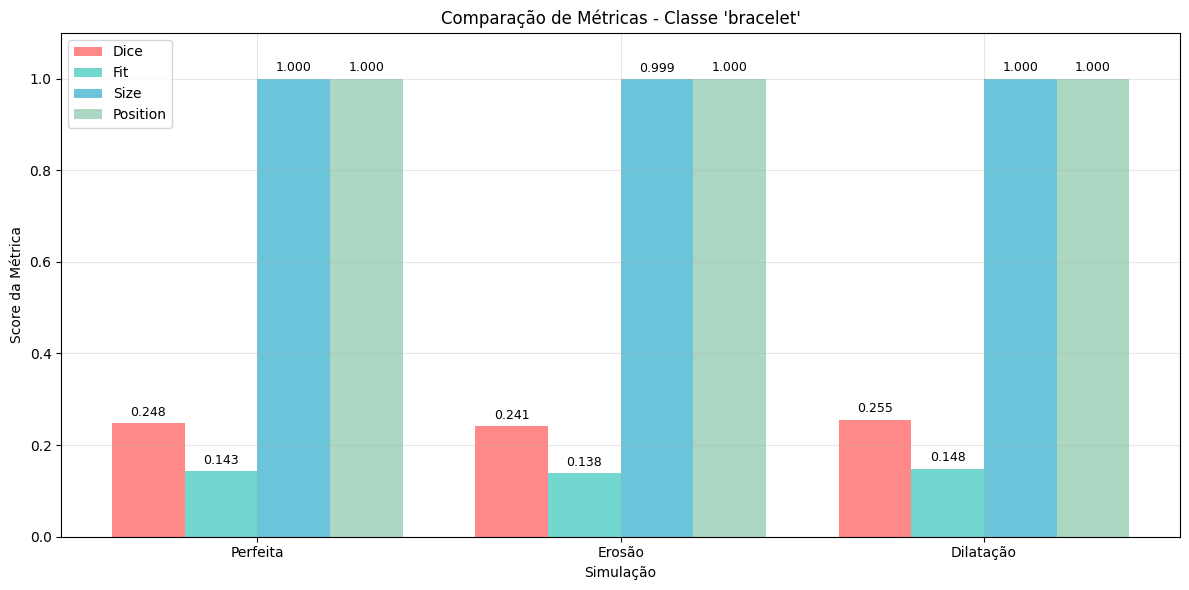

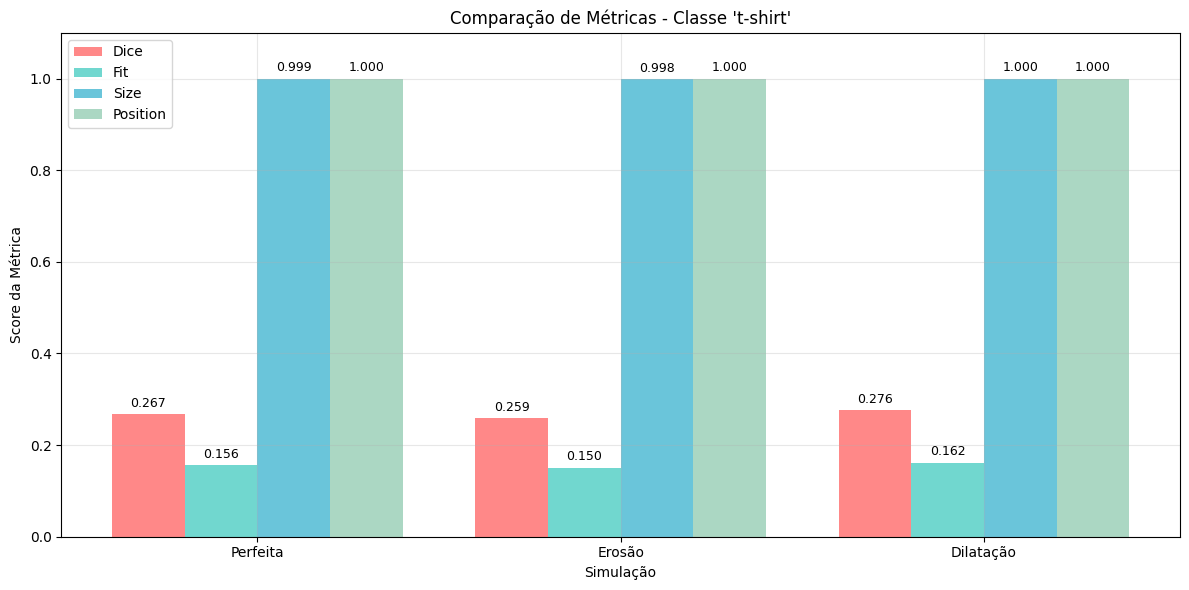

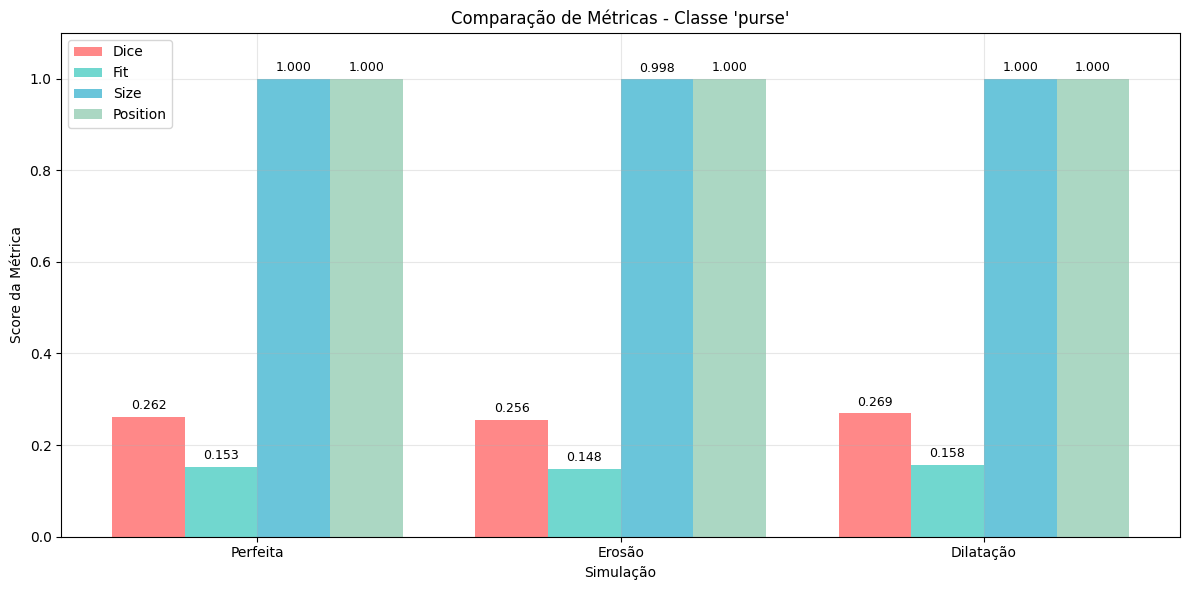

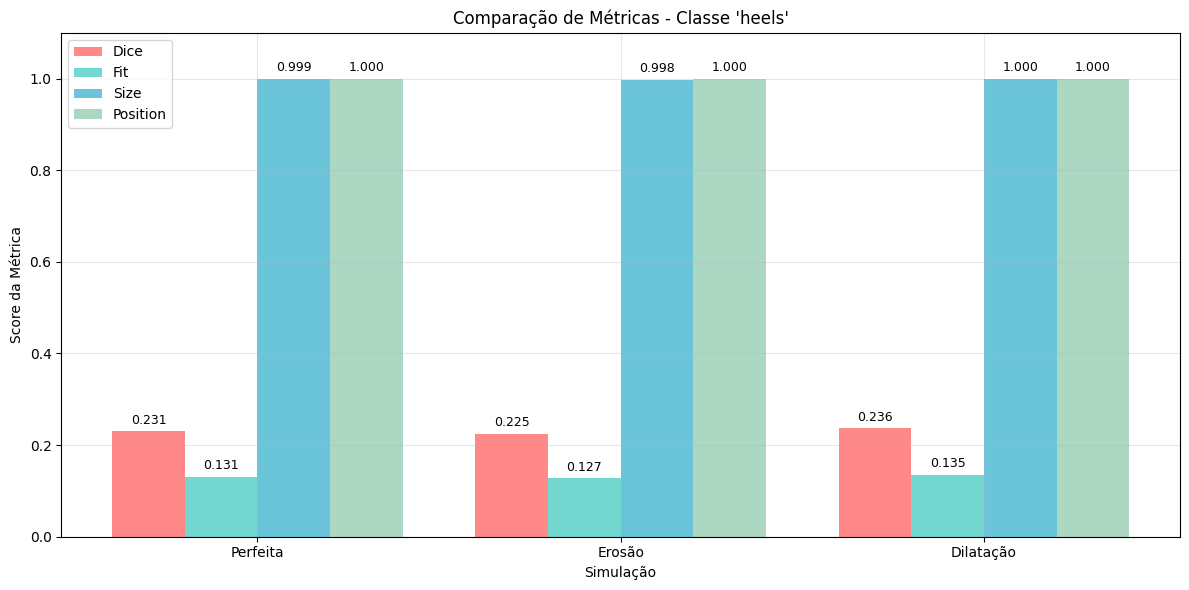

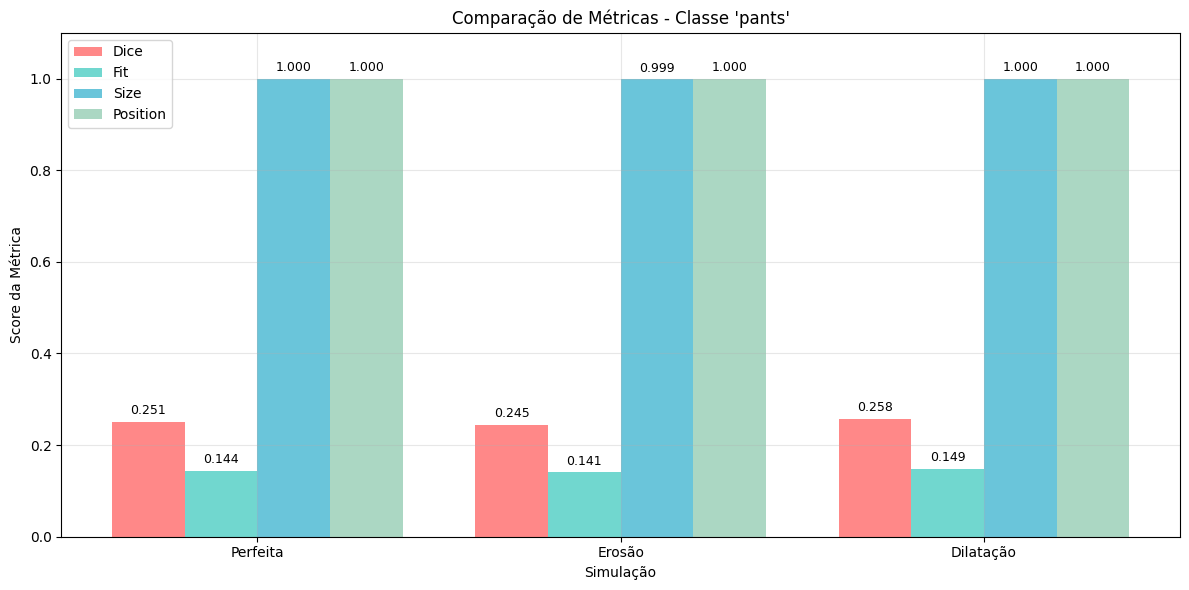

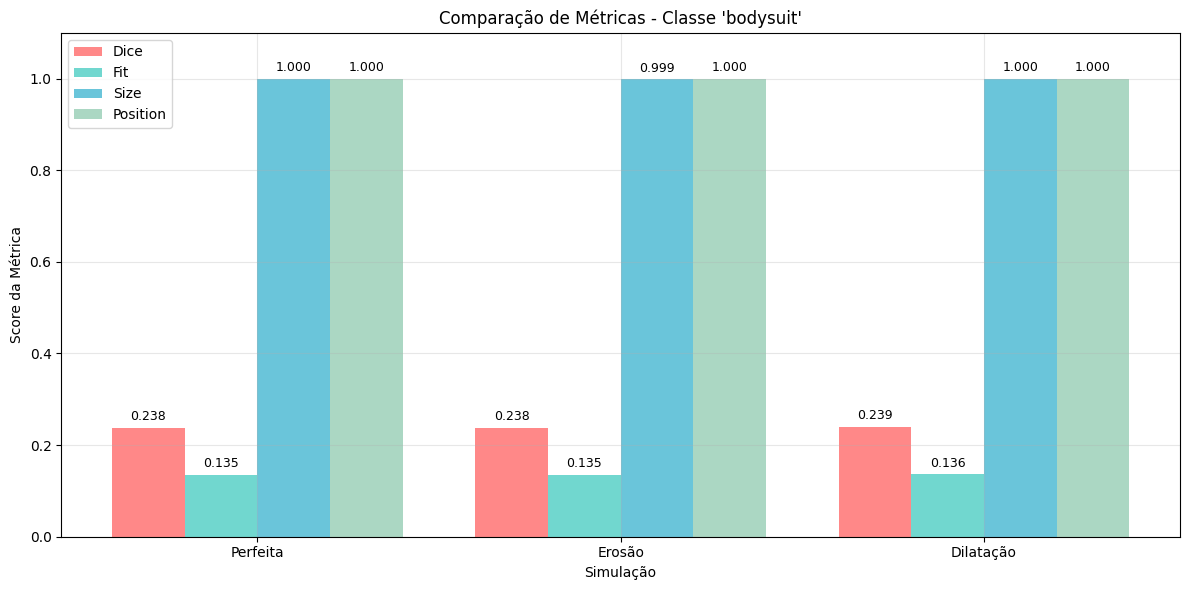

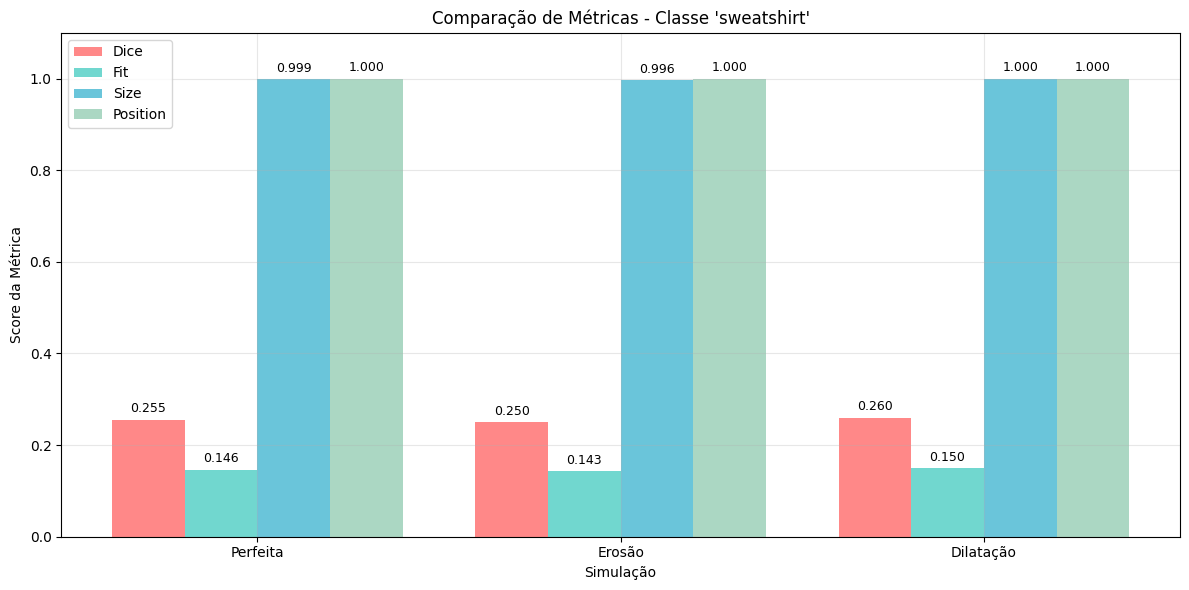

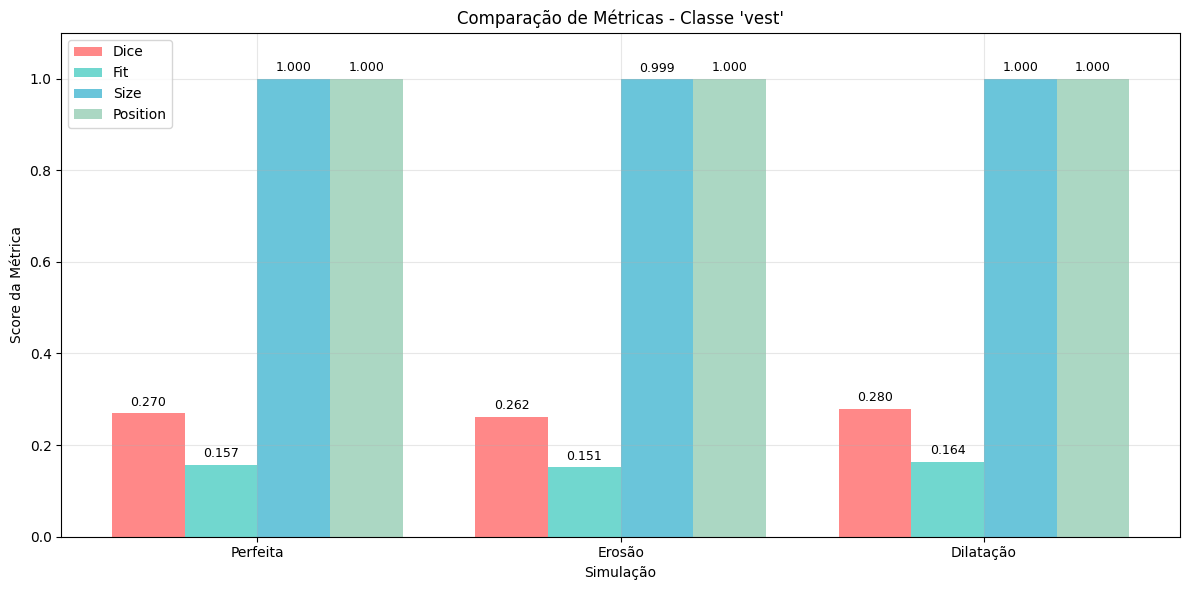

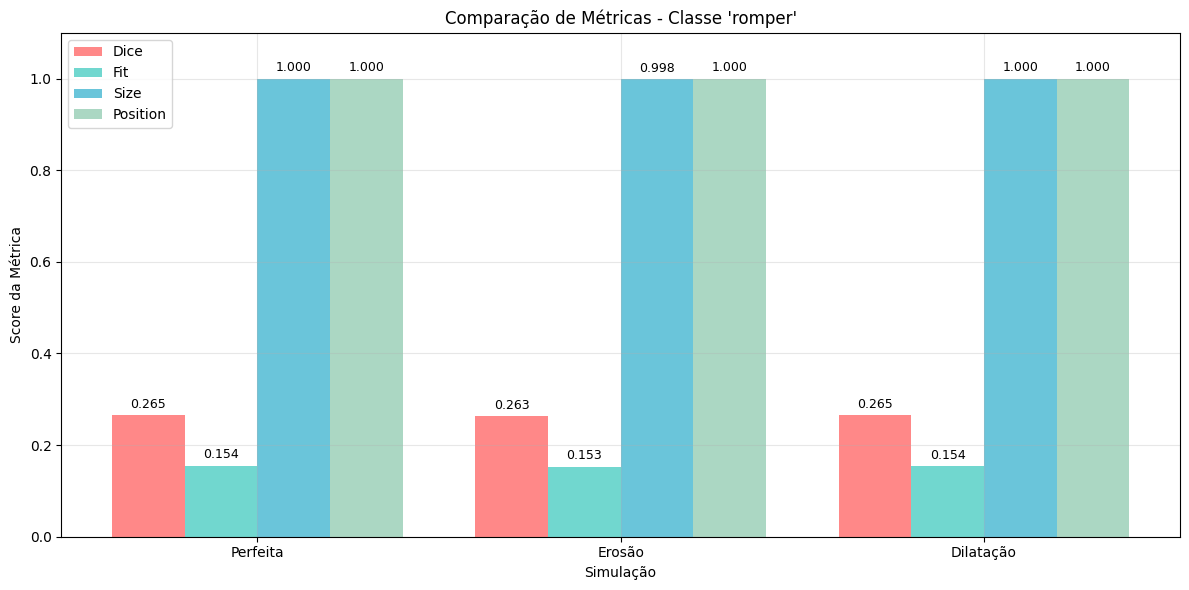

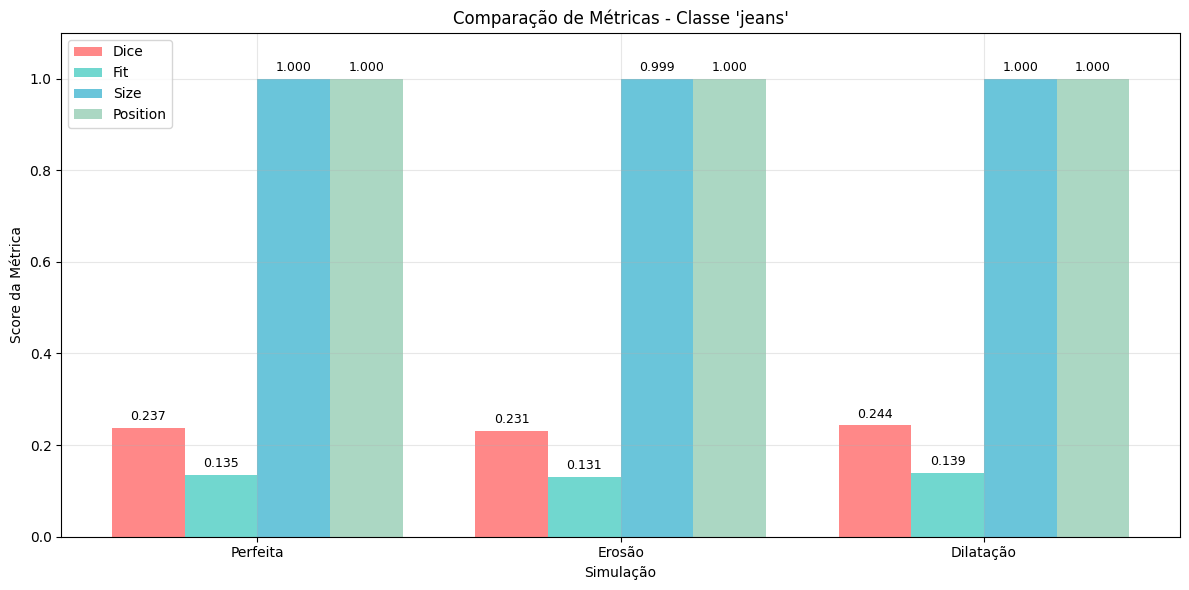

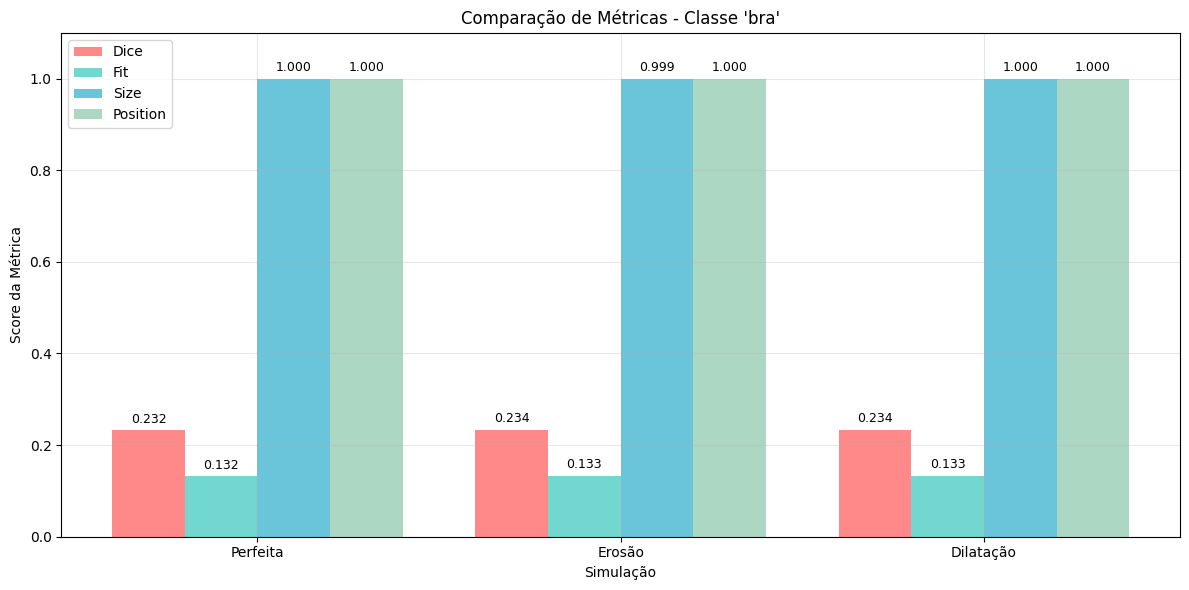

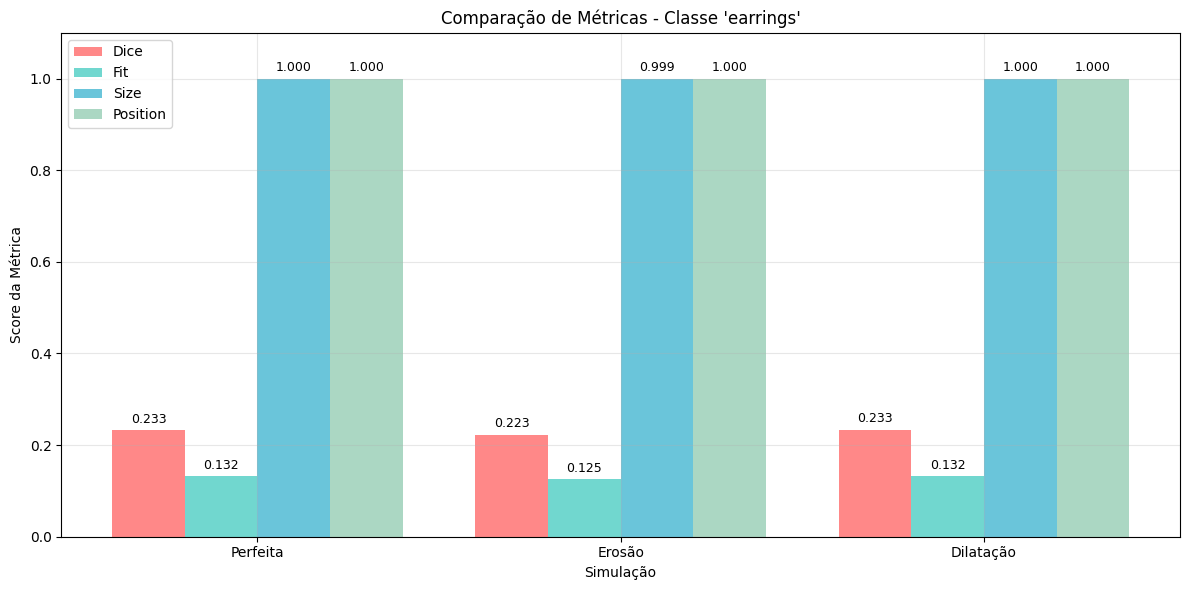

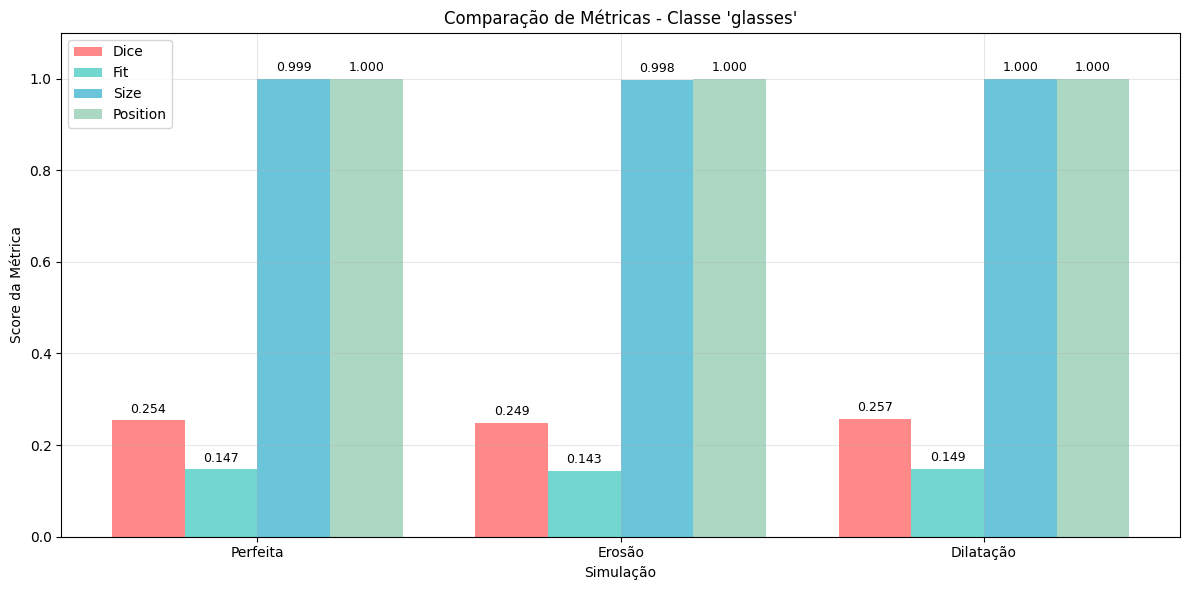

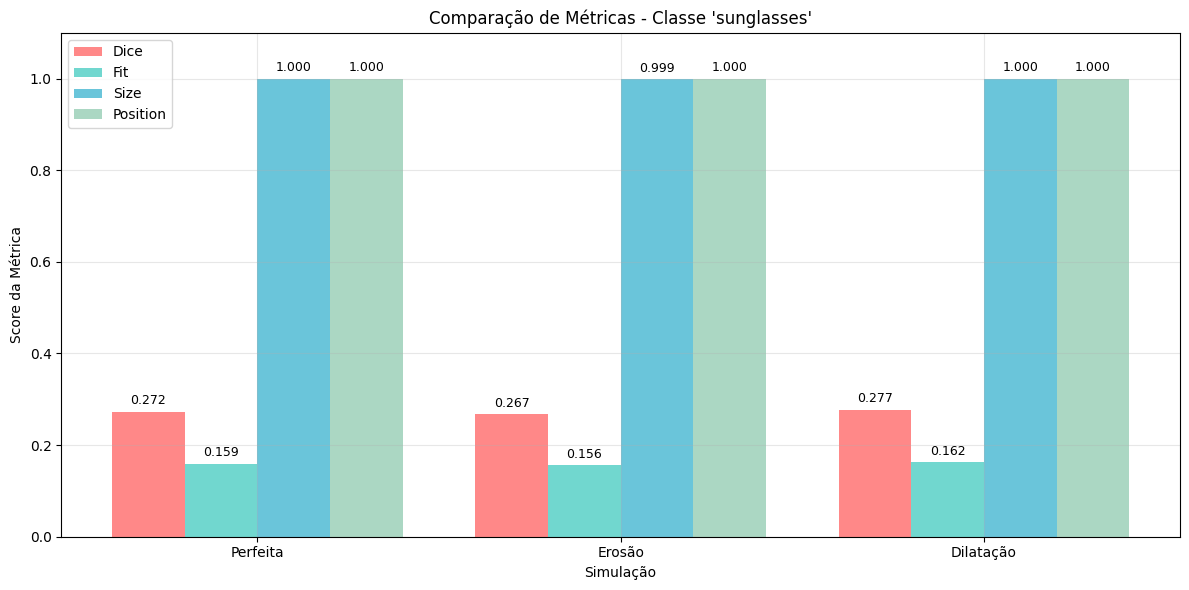

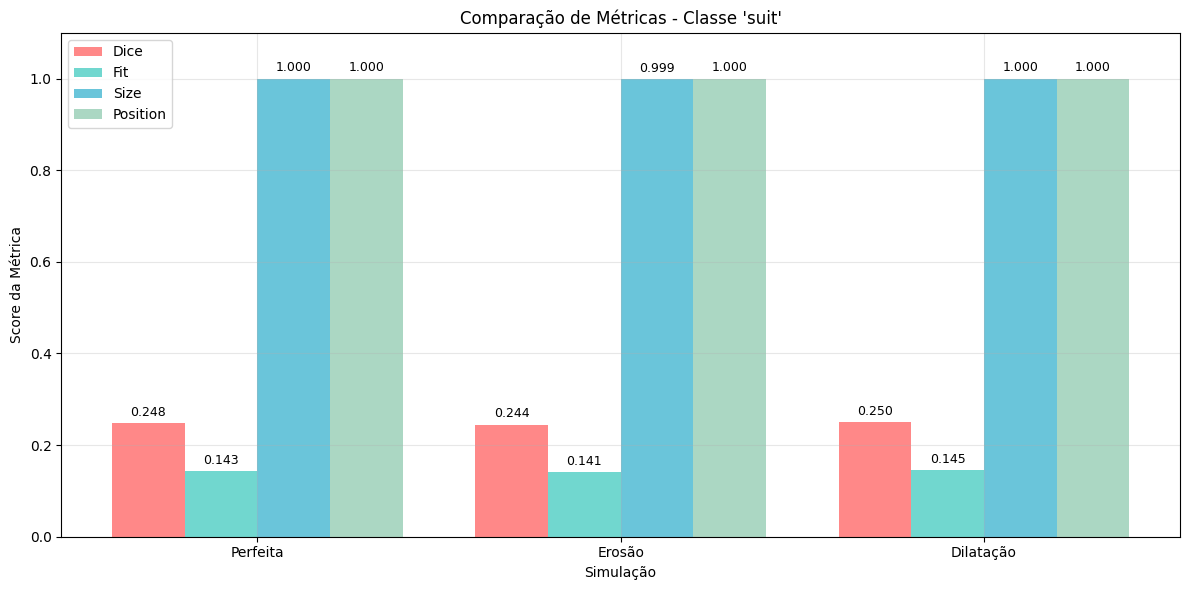

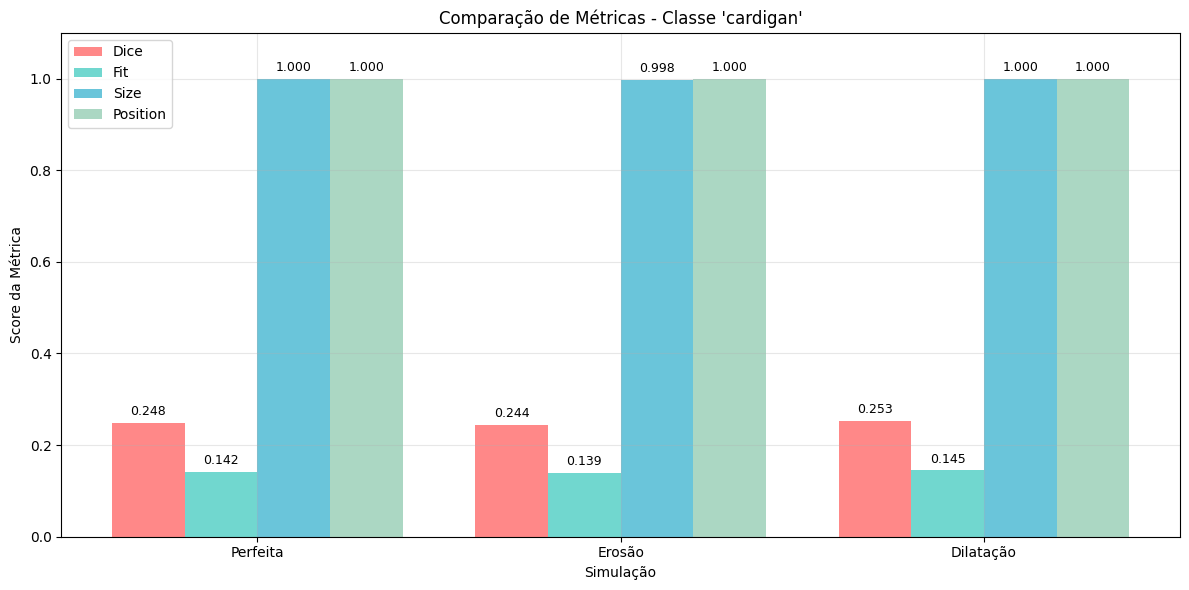

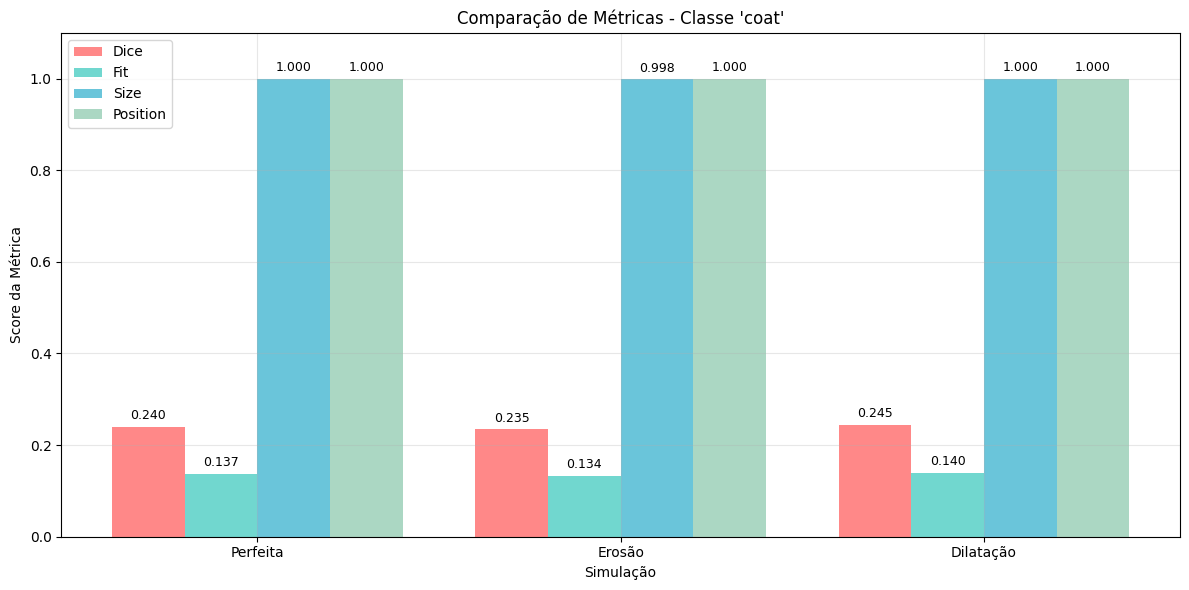

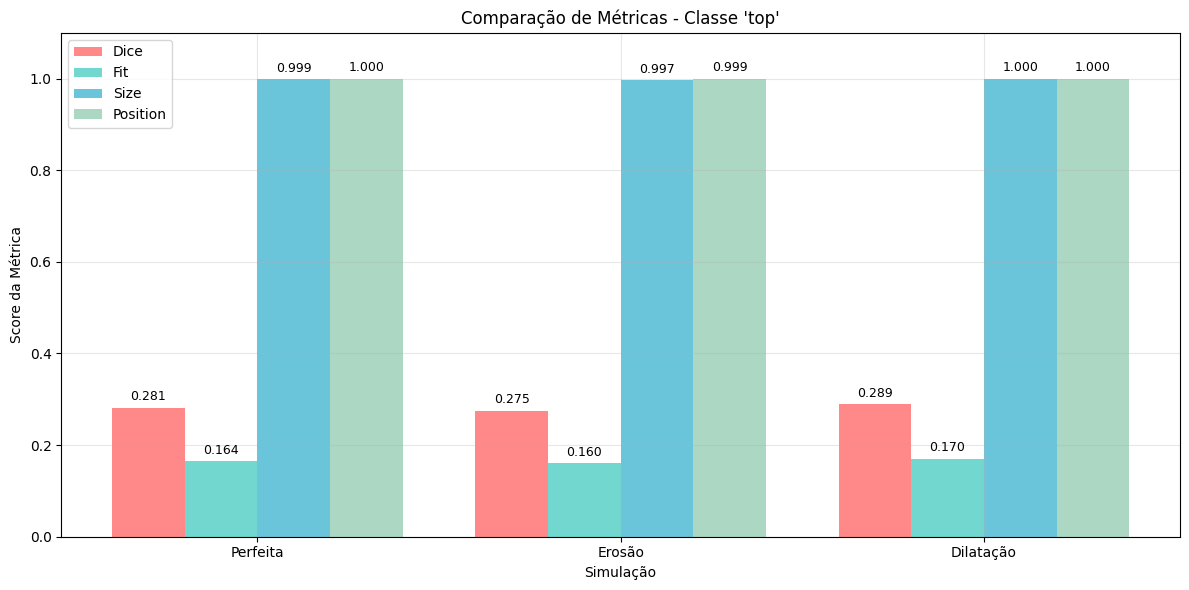

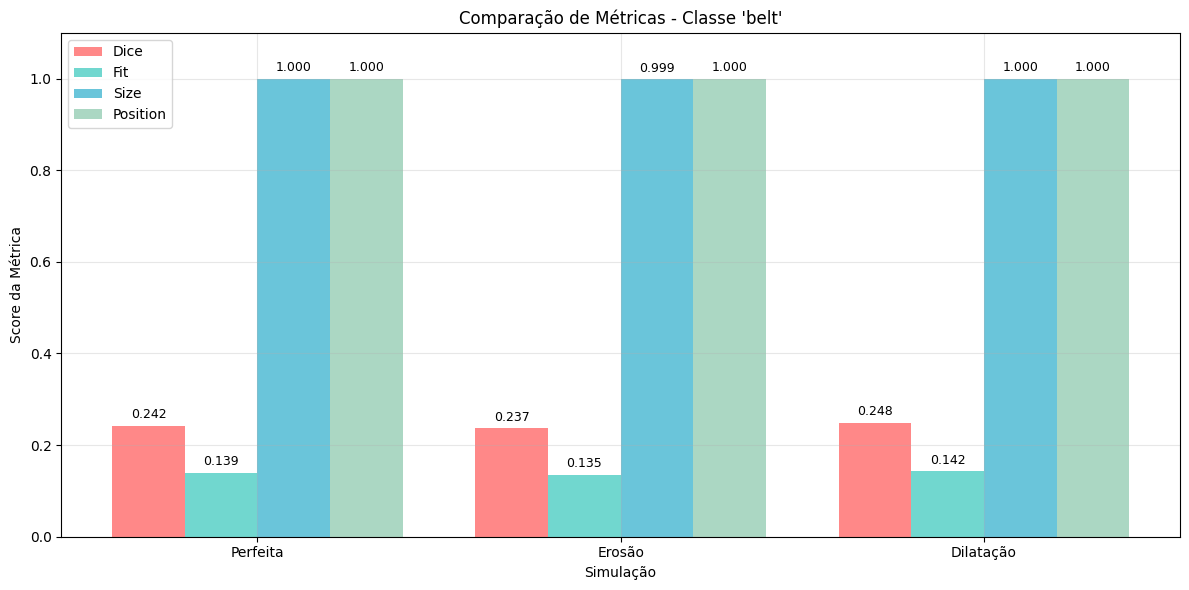

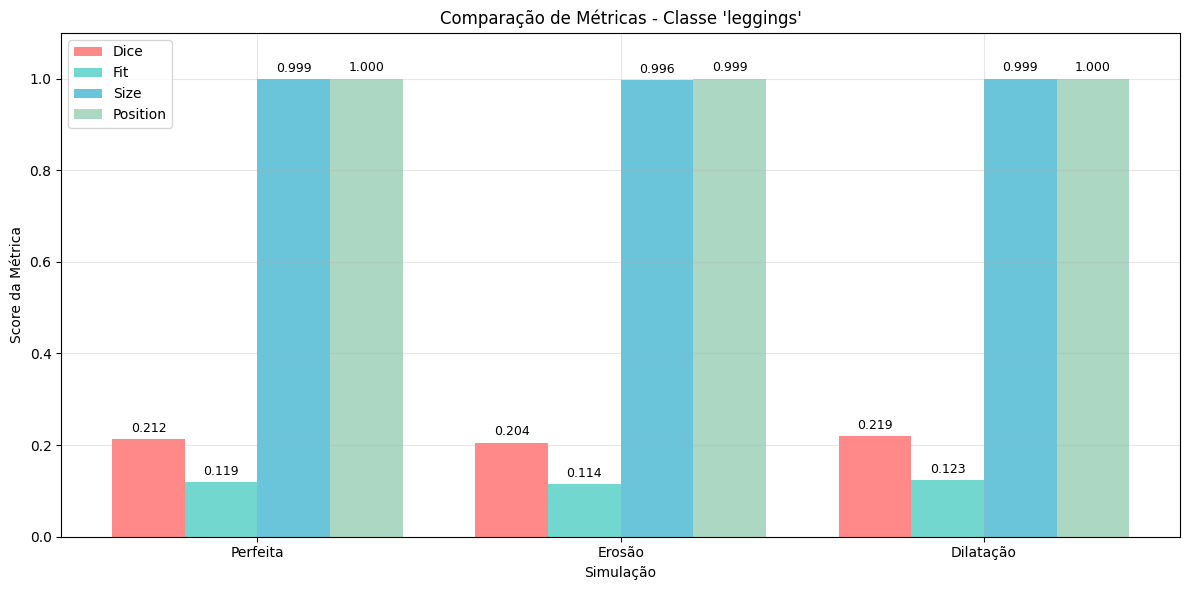

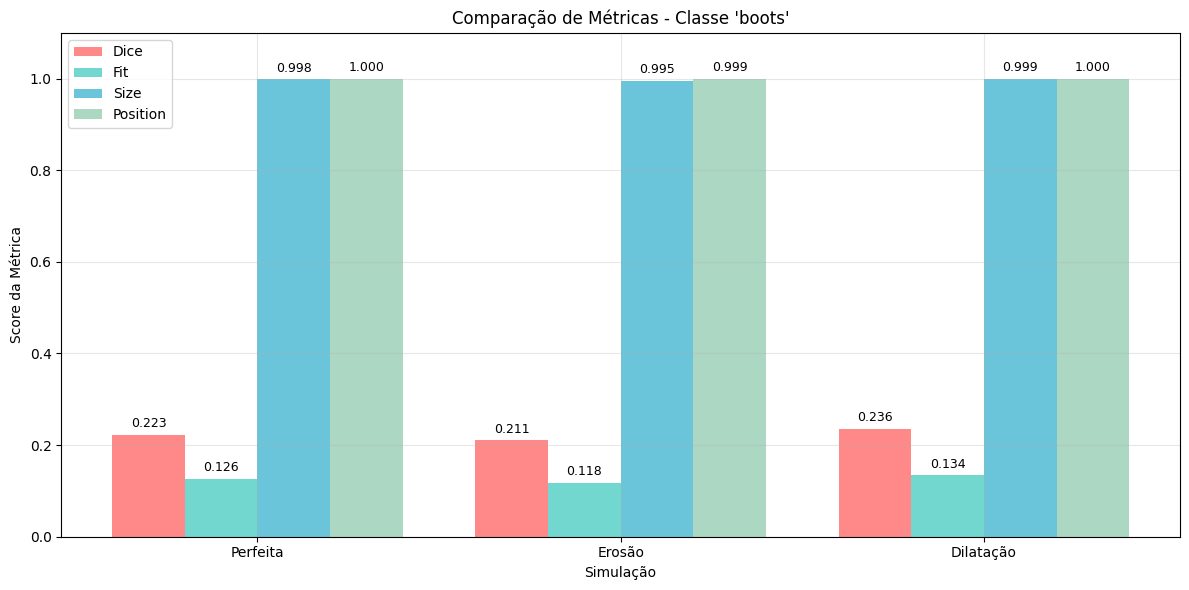

TESTE POR CLASSE CONCLUÍDO!


In [72]:
# =========================
# ANÁLISE DE MÉTRICAS POR CLASSE
# =========================
import matplotlib.pyplot as plt
from collections import defaultdict

def testar_metricas_por_classe(df_valido, n_imgs_por_classe=10):
    """
    Testa métricas por classe e gera resultados agregados.
    """
    todas_classes = set([cls for sublist in df_valido['classes'] for cls in sublist])
    resultados_classes = defaultdict(dict)

    for classe in todas_classes:
        df_classe = df_valido[df_valido['classes'].apply(lambda x: classe in x)].head(n_imgs_por_classe)
        if df_classe.empty:
            continue

        resultados = testar_metricas_clothing_dataset(df_classe, n=len(df_classe))
        # Avaliar simulações
        results_list = [
            evaluate_segmentation_complete(
                [ler_imagem_gray(df_classe.iloc[i]['image_path_full']) for i in range(len(df_classe))],
                resultados['gold']
            ),
            evaluate_segmentation_complete(resultados['seg_erosao'], resultados['gold']),
            evaluate_segmentation_complete(resultados['seg_dilatacao'], resultados['gold'])
        ]

        resultados_classes[classe]['results_list'] = results_list
        resultados_classes[classe]['dados_teste'] = resultados

    return resultados_classes

def plot_metrics_por_classe(resultados_classes):
    """
    Gera gráficos comparativos por classe.
    """
    metricas = ['mean_dice','mean_fit','mean_size','mean_position']
    metricas_labels = ['Dice','Fit','Size','Position']
    colors = ['#FF6B6B','#4ECDC4','#45B7D1','#96CEB4']

    for classe, dados in resultados_classes.items():
        results_list = dados['results_list']
        if not results_list:
            continue

        x = range(len(results_list))
        width = 0.2
        fig, ax = plt.subplots(figsize=(12,6))

        for i, metrica in enumerate(metricas):
            values = [res[metrica] if res else 0 for res in results_list]
            positions = [pos + width*i for pos in x]
            bars = ax.bar(positions, values, width, label=metricas_labels[i], color=colors[i], alpha=0.8)
            for bar, value in zip(bars, values):
                ax.text(bar.get_x()+bar.get_width()/2., value+0.01,f'{value:.3f}', ha='center', va='bottom', fontsize=9)

        ax.set_title(f"Comparação de Métricas - Classe '{classe}'")
        ax.set_xlabel('Simulação')
        ax.set_ylabel('Score da Métrica')
        ax.set_xticks([pos + width*1.5 for pos in x])
        ax.set_xticklabels(['Perfeita','Erosão','Dilatação'])
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0,1.1)
        plt.tight_layout()
        plt.show()

# -------------------------
# EXECUÇÃO
# -------------------------
print("EXECUTANDO TESTE DAS MÉTRICAS POR CLASSE")
print("="*60)

resultados_classes = testar_metricas_por_classe(df_valido, n_imgs_por_classe=10)
plot_metrics_por_classe(resultados_classes)
print("TESTE POR CLASSE CONCLUÍDO!")


CÉLULA 10: Mapeamento e Análise do DataFrame Atual FULL

In [1]:
# =========================
# MÓDULO PARA TODAS AS IMAGENS VÁLIDAS
# =========================
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# MÉTRICAS
# -------------------------
def compute_dice_similarity(array, arrayRef):
    imand = np.bitwise_and(array.astype("uint8"), arrayRef.astype("uint8"))
    sumand = 2 * np.sum(imand)
    sumor = np.sum(array) + np.sum(arrayRef)
    return sumand / float(sumor)

def compute_fit_adjust(array, arrayRef):
    imand = np.bitwise_and(array.astype("uint8"), arrayRef.astype("uint8"))
    imor = np.bitwise_or(array.astype("uint8"), arrayRef.astype("uint8"))
    return np.sum(imand) / float(np.sum(imor))

def compute_size_adjust(array, arrayRef):
    imArea1 = np.count_nonzero(arrayRef)
    imArea2 = np.count_nonzero(array)
    return 1 - abs(imArea1 - imArea2) / (imArea1 + imArea2)

def compute_position_adjust(arraySeg, arrayRef):
    indsSeg = np.where(arraySeg > 0)
    indsRef = np.where(arrayRef > 0)
    centroidRefY = indsRef[0].mean()
    centroidRefX = indsRef[1].mean()
    centroidSegY = indsSeg[0].mean()
    centroidSegX = indsSeg[1].mean()
    subCentroidY = abs(centroidSegY - centroidRefY) / arrayRef.shape[0]
    subCentroidX = abs(centroidSegX - centroidRefX) / arrayRef.shape[1]
    return 1 - (subCentroidY + subCentroidX) / 3

# -------------------------
# FUNÇÕES AUXILIARES
# -------------------------
def ler_imagem_gray(path):
    if os.path.exists(path):
        return cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return None

def aplicar_simulacao(img, tipo="original"):
    if tipo == "erosao":
        kernel = np.ones((3,3), np.uint8)
        return cv2.erode(img, kernel, iterations=1)
    elif tipo == "dilatacao":
        kernel = np.ones((3,3), np.uint8)
        return cv2.dilate(img, kernel, iterations=1)
    return img.copy()

def calcular_metricas_imagem(img, lbl):
    if img is None or lbl is None:
        return None
    return {
        "dice": compute_dice_similarity(img, lbl),
        "fit": compute_fit_adjust(img, lbl),
        "size": compute_size_adjust(img, lbl),
        "position": compute_position_adjust(img, lbl)
    }

# -------------------------
# PIPELINE PARA TODAS AS IMAGENS
# -------------------------
def testar_metricas_todas(df_valido):
    results = []
    seg_erosao = []
    seg_dilatacao = []
    gold_imgs = []

    for _, row in df_valido.iterrows():
        img = ler_imagem_gray(row['image_path_full'])
        lbl = ler_imagem_gray(row['label_path_full'])
        if img is None or lbl is None:
            continue
        results.append(calcular_metricas_imagem(img, lbl))
        gold_imgs.append(lbl)
        seg_erosao.append(aplicar_simulacao(img, "erosao"))
        seg_dilatacao.append(aplicar_simulacao(img, "dilatacao"))

    return {
        "results": results,
        "seg_erosao": seg_erosao,
        "seg_dilatacao": seg_dilatacao,
        "gold": gold_imgs
    }

def evaluate_segmentation_complete(seg_list, gold_list):
    metrics = {"dice": [], "fit": [], "size": [], "position": []}
    for img, lbl in zip(seg_list, gold_list):
        m = calcular_metricas_imagem(img, lbl)
        if m is not None:
            for k in metrics:
                metrics[k].append(m[k])
    return {f"mean_{k}": np.mean(v) if v else 0 for k, v in metrics.items()}

def plot_metrics_comparison(results_list, labels=["Perfeita","Erosão","Dilatação"]):
    metrics = ['mean_dice','mean_fit','mean_size','mean_position']
    metric_labels = ['Dice','Fit','Size','Position']
    x = range(len(results_list))
    width = 0.2
    colors = ['#FF6B6B','#4ECDC4','#45B7D1','#96CEB4']

    fig, ax = plt.subplots(figsize=(12,8))
    for i, metrica in enumerate(metrics):
        values = [res[metrica] if res else 0 for res in results_list]
        positions = [pos + width*i for pos in x]
        bars = ax.bar(positions, values, width, label=metric_labels[i], color=colors[i], alpha=0.8)
        for bar, value in zip(bars, values):
            ax.text(bar.get_x()+bar.get_width()/2., value+0.01,f'{value:.3f}', ha='center', va='bottom', fontsize=9)
    ax.set_xlabel('Simulação')
    ax.set_ylabel('Score')
    ax.set_title('Comparação de Métricas')
    ax.set_xticks([pos+width*1.5 for pos in x])
    ax.set_xticklabels(labels)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0,1.1)
    plt.tight_layout()
    plt.show()

def visualizar_comparacao_clothing(dados_teste, idx=0):
    plt.figure(figsize=(12,4))
    imgs = [
        ler_imagem_gray(df_valido.iloc[idx]['image_path_full']),
        dados_teste['seg_erosao'][idx],
        dados_teste['seg_dilatacao'][idx],
        dados_teste['gold'][idx]
    ]
    titles = ["Perfeita","Erosão","Dilatação","Gold"]
    for i, img in enumerate(imgs):
        plt.subplot(1,4,i+1)
        plt.imshow(img, cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# -------------------------
# EXECUÇÃO DIRETA
# -------------------------
print(" EXECUTANDO TESTE DAS MÉTRICAS COM TODAS AS IMAGENS VÁLIDAS")
print("="*60)

dados_teste = testar_metricas_todas(df_valido)

if dados_teste and dados_teste['results']:
    results_list = [
        evaluate_segmentation_complete(
            [ler_imagem_gray(row['image_path_full']) for _, row in df_valido.iterrows()],
            dados_teste['gold']
        ),
        evaluate_segmentation_complete(dados_teste['seg_erosao'], dados_teste['gold']),
        evaluate_segmentation_complete(dados_teste['seg_dilatacao'], dados_teste['gold'])
    ]
    plot_metrics_comparison(results_list)
    # Visualizar as primeiras 5 imagens como exemplo
    for i in range(min(5, len(dados_teste['results']))):
        visualizar_comparacao_clothing(dados_teste, i)
else:
    print(" Não foi possível executar o teste. Verifique df_valido e caminhos de imagem.")


 EXECUTANDO TESTE DAS MÉTRICAS COM TODAS AS IMAGENS VÁLIDAS


NameError: name 'df_valido' is not defined